In [ ]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: duenchombo1 (duenchombo1-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
# Init wandb

import wandb
# from wandb.sdk.wandb_settings import Settings

import numpy as np
import math
from matplotlib import pyplot as plt
# Loading the fashion-MNIST dataset
from keras.datasets import fashion_mnist
# Setting seed value
np.random.seed(1)

# Load dataset (train data and test data)
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()

# Summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


In [ ]:
# Number of classes in the Fashion-MNIST dataset
N_CLASSES = np.unique(trainy).shape[0]    # 10 as known from the keras documentation

# Captions/Labels for the output classes present in Fashion-MNIST dataset
IMG_LABELS = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


def getSampleImages(nClass, imgLabels, X, y, nSamples):
  '''
  The function takes few samples of each class from the dataset provided and passes it to the WANDB for it log the images

  Arguments :
    nClass -- Number of output classes in the dataset
    imgLabels -- List of labels for the output classes (numbered from 0 to nClass - 1)
    X -- The input data containing images in the form of matrices
    y -- The output data containing the class to which an input belongs
    nSamples -- Number of samples of each class to be taken. If that many samples not present in dataset, maximum number of samples present (from that class) will be taken

  Returns :
    -- None --
  '''

  # Initialise empty list to store the input data sampled from each class
  sampleImgsX = [[] for _ in range(nClass)]

  # Take sample image(s) from each class
  for i in range(y.shape[0]):
    if len(sampleImgsX[y[i]]) < nSamples :
      sampleImgsX[y[i]].append(X[i])


  # Getting a list of sample images of each class to be saved to wandb
  sampleImgsList = []
  for i in range(nClass):
    for j in range(nSamples):
      sampleImgsList.append(wandb.Image(sampleImgsX[i][j], caption = imgLabels[i]))

  np.random.shuffle(sampleImgsList)
  wandb.log({"example" : sampleImgsList})


# Question 1 -- Showing 3 sample images from training set of downloaded Fashion-MNIST dataset in WANDB
# ---------------- Uncomment the below code to run -----------------

run = wandb.init(project="assignment_1", entity="duenchombo1-indian-institute-of-technology-madras",reinit=True)
getSampleImages(N_CLASSES, IMG_LABELS, trainX, trainy, 1)
run.finish()

In [ ]:
def relu(X):
  # Calculates the Rectified Linear Unit (ReLU) function
  return np.maximum(X,0)

def sigmoid(X):
  # Calculates the sigmoid function
  return np.exp(-np.logaddexp(0, -X))

def softmax(X):
  # Calculates the softmax function
  e_X = np.exp(X - np.max(X, axis = 0))
  return e_X / e_X.sum(axis = 0)

def tanh(X):
  return np.tanh(X)

def linear(W, X, b):
  # Calculates the linear function
  return W @ X + b

def grad_relu(X):
  # Calculates the gradient of Rectified Linear Unit (ReLU) function
  return X > 0

def grad_sigmoid(X):
  # Calculates the gradient of sigmoid function
  return sigmoid(X) * (1 - sigmoid(X))

def grad_tanh(X):
  # Calculates the gradient of tanh function
  return 1 - np.tanh(X)**2

def Softmax_CrossEntropy_grad(Y_pred, Y):
  # Calculates the gradient of the output layer with softmax activation and cross entropy loss
  # layer -- The dictionary for the output layer contianing info about it
  # y -- True output
  return -(Y - Y_pred)

def Softmax_SquaredError_grad(Y_pred, Y):
  return ((Y_pred - Y) - ((Y_pred - Y) * Y_pred).sum(axis = 0)) * Y_pred

In [ ]:
def random_initialisation(shape):
  # Initialising a random matrix with given dimensions (shape) as tuple
  np.random.seed(0)
  return np.random.randn(*shape)*0.1

def xavier_initialisation(shape):
  # Initialising a matrix by xavier initialisation with given dimensions (shape) as tuple
  np.random.seed(0)
  bound = (6/(shape[0]+shape[1]))**(0.5)
  return bound*(2*np.random.rand(*shape)-1)

In [ ]:
def initialize_network(n_L, preActFns_L, actFns_L, gradActFns_L, gradOutputFn, weight_initialisation):
  '''
  The function initializes the neural network and the appropriate parameters

  Arguments :
    n_L -- an array whose ith element represents the number of neurons in the ith layer (0 - Input Layer, last element - Output Layer)
    preActFns_L -- an array who ith element is the Pre Activation function of the (i+1)th layer of the neural network
    actFns_L -- an array who ith element is the Activation function of the (i+1)th layer of the neural network
    gradActFns_L -- an array who ith element is the gradient of the Activation function of the (i+1)th layer of the neural network
    gradOutputFn -- Function to calculate gradients wrt a_L (output layer) in back-propagation
    weight_initialisation -- Function to initialise weights of the layers

  Returns :
    network -- the initialized network as an array of dictionaries for the hidden and output layers of the neural network
  '''

  L = len(n_L)-1

  assert(L >= 1)
  assert(len(preActFns_L) == L)
  assert(len(actFns_L) == L)

  network = list()
  for i in range(1,L+1):
    # Dictionary for each layer representing it's constituents
    layer = {'weights':weight_initialisation((n_L[i],n_L[i-1])),  # Weight matrix for (i-1)th to ith layer transition
             'biases':np.zeros((n_L[i],1)),                       # Bias vector for (i-1)th to ith layer transition
             'pre_activation_fn':preActFns_L[i-1],                # Pre-activation function for neurons of the ith layer
             'activation_fn':actFns_L[i-1],                       # Activation function for neurons of the ith layer
             'no_neurons':n_L[i],                                 # Number of neurons in ith layer
             'cache': []                                          # Array of cached pre-activation and activation output for each layer to be used in back-propagation (will be filled in forward-propagation)
            }
    network.append(layer)
    if i < L:
      network[-1]['grad_activation_fn'] = gradActFns_L[i-1]       # Function calculating Gradient of the Activation function for the ith (hidden) layer

  network[-1]['grad_output_fn'] = gradOutputFn                    # Function calculating Gradient of the Output layer (Gradient of Loss function wrt a_L)

  return network

In [ ]:
def pre_activation(H_prev, W, b, pre_activation_fn):
  # Calculates the pre-activation output and caches the required values. Returns the output and cache.

  A = pre_activation_fn(W, H_prev, b)

  assert(A.shape[0] == W.shape[0])
  pre_act_cache = H_prev                    # Caching the pre-activation ouptut to be used in backpropagation

  return A, pre_act_cache

def feedforward_neuron(H_prev, W, b, activation_fn, pre_activation_fn):
  # Calculates the activation output (using the pre-activation function above) and caches the required values. Returns the output and cache.

  A, pre_activation_cache = pre_activation(H_prev, W, b, pre_activation_fn)
  H = activation_fn(A)

  assert (H.shape[0] == W.shape[0])
  cache = (pre_activation_cache, A)         # Caching the pre-activation and activation output to use it in back-propagation

  return H, cache

In [ ]:
def forward_propagation(network, X):
    """
    Implement forward propagation for the given neural network

    Arguments :
      network -- Given neural network (as an array of dictionaries)
      X -- Input data from the training set as a matrix with ith column representing ith input training data

    Returns :
      Output from the neural network as a matrix with ith column representing output of ith input data
    """

    H = X                         # Initialising H to input
    L = len(network)              # Number of (hidden + output) layers in the neural network

    for l in range(0, L):
        H_prev = H
        H, cache = feedforward_neuron(H_prev, network[l]['weights'], network[l]['biases'], network[l]['activation_fn'], network[l]['pre_activation_fn'])
        network[l]['cache'] = cache

    assert(H.shape[0] == (network[L-1]['no_neurons']))

    return H

# HL = forward_propagation(trainX_reshaped, network)          # HL -- output from the neural network
# print(HL)

In [ ]:
def back_propagation(network, Y, Y_pred, weight_decay, grad_reglr_fn):
  """
    Implement backward propagation for the given neural network

    Arguments :
      network -- Given neural network (as an array of dictionaries)
      Y -- True output matrix with ith column representing true output of ith input data
      Y_pred -- Output of neural network as a matrix in the same form as Y
      weight_decay -- Hyperparameter scaling regularisation term
      grad_reglr_fn -- Function calculating gradient of the regularisation function

    Returns :
      H -- Output from the neural network
  """

  L = len(network)
  assert(Y.shape[1] == Y_pred.shape[1])
  M = Y.shape[1]

  # Gradients wrt output layer (a_L)
  grad_a_k_L = network[L-1]['grad_output_fn'](Y_pred, Y)

  # Initialising gradients to be calculated in the loop below
  grad_w_L = [np.zeros(2)] * L
  grad_b_L = [np.zeros(2)] * L
  grad_h_prev_L, grad_a_prev_L = 0, 0

  for k in range(L-1,-1,-1):
    # Gradients wrt Weights (W_k)
    grad_w_L[k] = (grad_a_k_L @ network[k]['cache'][0].T / M) + weight_decay * grad_reglr_fn(network[k]['weights'])

    # Gradients wrt Biases (b_k)
    grad_b_L[k] = np.mean(grad_a_k_L, axis=1)
    grad_b_L[k] = grad_b_L[k].reshape((grad_b_L[k].shape[0], 1))

    # Gradients wrt hidden layer
    # Gradients wrt h_(k-1)
    grad_h_prev_L = network[k]['weights'].T @ grad_a_k_L

    # Gradients wrt a_(k-1)
    if(k > 0):
      grad_act_fn_prev = network[k-1]['grad_activation_fn'](network[k-1]['cache'][1])
      grad_a_prev_L = grad_h_prev_L * grad_act_fn_prev

    grad_a_k_L = grad_a_prev_L

  return grad_w_L, grad_b_L

In [ ]:
def L2_regularisation(network):
  # Function that returns L2 regularisation loss for the given network
  L = len(network)
  ans = 0
  for k in range(L):
    ans += np.sum(network[k]['weights'] ** 2)

  return ans

def L1_regularisation(network):
  # Function that returns L1 regularisation loss for the given network
  L = len(network)
  ans = 0
  for k in range(L):
    ans += np.sum(np.absolute(network[k]['weights']))

  return ans

def grad_L2_regularisation(W):
  # Function that returns L2 regularisation gradient for the given Weight matrix / tensor
  return 2 * W

def grad_L1_regularisation(W):
  # Function that returns L1 regularisation gradient for the given Weight matrix / tensor
  return np.sign(W)

In [ ]:
def CrossEntropy_loss(Y_pred, Y_true):
  # Function that returns cross entropy loss
  assert(Y_pred.shape[1] == Y_true.shape[1])
  M = Y_pred.shape[1]
  return -(Y_true * np.log(Y_pred)).sum() / M

def SquaredError(Y_pred, Y_true):
  # Function that returns mean squared loss
  assert(Y_pred.shape[1] == Y_true.shape[1])
  M = Y_pred.shape[1]
  return ((Y_true - Y_pred) ** 2).sum() / (2.0 * M)

def overall_loss(network, Y_pred, Y_true, loss_fn = CrossEntropy_loss, weight_decay = 0, regularisation_fn = L2_regularisation):
  # Function that returns overall loss (Output layer cost function + Regularisation) for the network
  return loss_fn(Y_pred, Y_true) + weight_decay * regularisation_fn(network)


In [ ]:
def calc_accuracy_loss(network, X, Y, loss_fn = CrossEntropy_loss, weight_decay = 0, regularisation_fn = L2_regularisation):
  # Function that returns the accuracy and loss for a given network
  Y_pred = forward_propagation(network, X)
  loss = overall_loss(network, Y_pred, Y, loss_fn, weight_decay, regularisation_fn)
  assert(X.shape[1] == Y.shape[1])
  M = X.shape[1]
  accuracy = np.sum(np.argmax(Y_pred, axis = 0) == np.argmax(Y, axis = 0)) / M
  return accuracy, loss

In [ ]:
from tqdm import tqdm

def sgd_gradient_descent(X, Y, network, batch_size, eta, max_epochs, loss_fn = CrossEntropy_loss, weight_decay = 0,
                         regularisation_fn = L2_regularisation, grad_reglr_fn = grad_L2_regularisation, validX = None, validY = None):
  """
    Trains the neural network using Vanilla/Batch Gradient Descent

    Arguments :
      X -- Input training data matrix where ith column is the input data corresponding to ith training example
      Y -- True training output matrix where ith column is the output data corresponding to ith training example
      network -- Given neural network (as an array of dictionaries)
      eta -- Learning Rate
      max_epochs -- Number of iterations for convergence
      loss_fn -- Function used to calculate the loss in the neural network
      weight_decay -- Hyperparameter scaling regularisation term
      regularisation_fn -- (wat the name suggests)
      grad_reglr_fn -- Function calculating gradient of the regularisation function
      validX -- Validation input data (in same format as training data)
      validY -- Validation output data (in same format as training data)

    Returns :
      batch_loss_values -- List of average loss values after every batch of training
      train_stats -- List of tuple (training accuracy, average training loss) of entire dataset after every epoch of training
      valid_stats -- List of tuple (validation accuracy, average validation loss) of entire dataset after every epoch of training
  """
  assert(X.shape[1] == Y.shape[1])
  if validY is not None:
    assert(validX.shape[1] == validY.shape[1])

  batch_loss_values, train_stats, valid_stats = [], [], []
  L = len(network)
  batch_curr_loss, batch = 0, 0
  dw, db = [np.zeros_like(network[k]['weights']) for k in range(L)], [np.zeros_like(network[k]['biases']) for k in range(L)]

  for epoch in tqdm(range(max_epochs)):
    for i in range(0, X.shape[1], batch_size):
      batch += 1
      Y_true = Y[:,i:i+batch_size]
      Y_pred = forward_propagation(network, X[:,i:i+batch_size])
      batch_curr_loss = overall_loss(network, Y_pred, Y_true, loss_fn, weight_decay, regularisation_fn)
      dw, db = back_propagation(network, Y_true, Y_pred, weight_decay, grad_reglr_fn)
      batch_loss_values.append(batch_curr_loss)
      wandb.log({'batch': batch, 'epoch': epoch, 'batch_loss': batch_curr_loss})
      for k in range(L):
        network[k]['weights'] -= eta * dw[k]
        network[k]['biases'] -= eta * db[k]

    train_stats.append(calc_accuracy_loss(network, X, Y, loss_fn, weight_decay, regularisation_fn))
    if validX is not None:
      valid_stats.append(calc_accuracy_loss(network, validX, validY, loss_fn, weight_decay, regularisation_fn))

    wandb.log({'epoch': epoch, 'validation_accuracy': valid_stats[-1][0] if validX is not None else 0, 'accuracy': train_stats[-1][0],
              'validation_loss': valid_stats[-1][1] if validX is not None else 0, 'loss': train_stats[-1][1]})

  return batch_loss_values, train_stats, valid_stats

In [ ]:
def momentum_gradient_descent(X, Y, network, batch_size, eta, max_epochs, loss_fn = CrossEntropy_loss, beta = 0.9, weight_decay = 0,
                              regularisation_fn = L2_regularisation, grad_reglr_fn = grad_L2_regularisation, validX = None, validY = None):
  """
    Trains the neural network using Momentum Gradient Descent

    Arguments :
      X -- Input data matrix where ith column is the input data corresponding to ith training example
      Y -- True output matrix where ith column is the output data corresponding to ith training example
      network -- Given neural network (as an array of dictionaries)
      eta -- Learning Rate
      max_epochs -- Number of iterations for convergence
      loss_fn -- Function used to calculate the loss in the neural network
      beta -- Hyperparameter to tune dependency of gradient on history (standard value 0.9 used)
      weight_decay -- Hyperparameter scaling regularisation term
      regularisation_fn -- (wat the name suggests)
      grad_reglr_fn -- Function calculating gradient of the regularisation function
      validX -- Validation input data (in same format as training data)
      validY -- Validation output data (in same format as training data)

    Returns :
      batch_loss_values -- List of average loss values after every batch of training
      train_stats -- List of tuple (training accuracy, average training loss) of entire dataset after every epoch of training
      valid_stats -- List of tuple (validation accuracy, average validation loss) of entire dataset after every epoch of training
  """
  assert(X.shape[1] == Y.shape[1])
  if validY is not None:
    assert(validX.shape[1] == validY.shape[1])

  batch_loss_values, train_stats, valid_stats = [], [], []
  L = len(network)
  batch_curr_loss, batch = 0, 0
  dw, db, m_w, m_b = [np.zeros_like(network[k]['weights']) for k in range(L)], [np.zeros_like(network[k]['biases']) for k in range(L)], \
                     [np.zeros_like(network[k]['weights']) for k in range(L)], [np.zeros_like(network[k]['biases']) for k in range(L)]

  for epoch in tqdm(range(max_epochs)):
    for i in range(0, X.shape[1], batch_size):
      batch += 1
      Y_true = Y[:,i:i+batch_size]
      Y_pred = forward_propagation(network, X[:,i:i+batch_size])
      batch_curr_loss = overall_loss(network, Y_pred, Y_true, loss_fn, weight_decay, regularisation_fn)
      dw, db = back_propagation(network, Y_true, Y_pred, weight_decay, grad_reglr_fn)
      batch_loss_values.append(batch_curr_loss)
      wandb.log({'batch': batch, 'epoch': epoch, 'batch_loss': batch_curr_loss})
      for k in range(L):
        m_w[k] = m_w[k] * beta + dw[k] * eta
        m_b[k] = m_b[k] * beta + db[k] * eta
        network[k]['weights'] -= m_w[k]
        network[k]['biases'] -= m_b[k]

    train_stats.append(calc_accuracy_loss(network, X, Y, loss_fn, weight_decay, regularisation_fn))
    if validX is not None:
      valid_stats.append(calc_accuracy_loss(network, validX, validY, loss_fn, weight_decay, regularisation_fn))

    wandb.log({'epoch': epoch, 'validation_accuracy': valid_stats[-1][0] if validX is not None else 0, 'accuracy': train_stats[-1][0],
              'validation_loss': valid_stats[-1][1] if validX is not None else 0, 'loss': train_stats[-1][1]})

  return batch_loss_values, train_stats, valid_stats


def nesterov_gradient_descent(X, Y, network, batch_size, eta, max_epochs, loss_fn = CrossEntropy_loss, beta = 0.9, weight_decay = 0,
                              regularisation_fn = L2_regularisation, grad_reglr_fn = grad_L2_regularisation, validX = None, validY = None):
  """
    Trains the neural network using Nesterov Accelerated Gradient Descent

    Arguments :
      X -- Input data matrix where ith column is the input data corresponding to ith training example
      Y -- True output matrix where ith column is the output data corresponding to ith training example
      network -- Given neural network (as an array of dictionaries)
      eta -- Learning Rate
      max_epochs -- Number of iterations for convergence
      loss_fn -- Function used to calculate the loss in the neural network
      beta -- Hyperparameter to tune dependency of gradient on history (standard value 0.9 used)
      weight_decay -- Hyperparameter scaling regularisation term
      regularisation_fn -- (wat the name suggests)
      grad_reglr_fn -- Function calculating gradient of the regularisation function
      validX -- Validation input data (in same format as training data)
      validY -- Validation output data (in same format as training data)

    Returns :
      batch_loss_values -- List of average loss values after every batch of training
      train_stats -- List of tuple (training accuracy, average training loss) of entire dataset after every epoch of training
      valid_stats -- List of tuple (validation accuracy, average validation loss) of entire dataset after every epoch of training
  """
  assert(X.shape[1] == Y.shape[1])
  if validY is not None:
    assert(validX.shape[1] == validY.shape[1])
  batch_loss_values, train_stats, valid_stats = [], [], []
  L = len(network)
  batch_curr_loss, batch = 0, 0
  dw, db, m_w, m_b = [np.zeros_like(network[k]['weights']) for k in range(L)], [np.zeros_like(network[k]['biases']) for k in range(L)], \
                     [np.zeros_like(network[k]['weights']) for k in range(L)], [np.zeros_like(network[k]['biases']) for k in range(L)]

  lookahead_network = network[:]

  for epoch in tqdm(range(max_epochs)):
    for i in range(0, X.shape[1], batch_size):
      batch += 1
      Y_true = Y[:,i:i+batch_size]
      Y_pred_org = forward_propagation(network, X[:,i:i+batch_size])
      batch_curr_loss = overall_loss(network, Y_pred_org, Y_true, loss_fn, weight_decay, regularisation_fn)
      Y_pred = forward_propagation(lookahead_network, X[:,i:i+batch_size])
      dw, db = back_propagation(lookahead_network, Y_true, Y_pred, weight_decay, grad_reglr_fn)
      batch_loss_values.append(batch_curr_loss)
      wandb.log({'batch': batch, 'epoch': epoch, 'batch_loss': batch_curr_loss})
      for k in range(L):
        m_w[k] = m_w[k] * beta + dw[k] * eta
        m_b[k] = m_b[k] * beta + db[k] * eta
        network[k]['weights'] -= m_w[k]
        network[k]['biases'] -= m_b[k]
        lookahead_network[k]['weights'] -= (eta * dw[k] + beta * m_w[k])
        lookahead_network[k]['biases'] -= (eta * db[k] + beta * m_b[k])

    train_stats.append(calc_accuracy_loss(network, X, Y, loss_fn, weight_decay, regularisation_fn))
    if validX is not None:
      valid_stats.append(calc_accuracy_loss(network, validX, validY, loss_fn, weight_decay, regularisation_fn))

    wandb.log({'epoch': epoch, 'validation_accuracy': valid_stats[-1][0] if validX is not None else 0, 'accuracy': train_stats[-1][0],
              'validation_loss': valid_stats[-1][1] if validX is not None else 0, 'loss': train_stats[-1][1]})

  return batch_loss_values, train_stats, valid_stats

In [ ]:
def rmsprop_gradient_descent(X, Y, network, batch_size, eta, max_epochs, loss_fn = CrossEntropy_loss, eps = 1e-8, beta = 0.9,
                             weight_decay = 0, regularisation_fn = L2_regularisation, grad_reglr_fn = grad_L2_regularisation,
                             validX = None, validY = None):
  """
    Trains the neural network using RMSProp Gradient Descent

    Arguments :
      X -- Input data matrix where ith column is the input data corresponding to ith training example
      Y -- True output matrix where ith column is the output data corresponding to ith training example
      network -- Given neural network (as an array of dictionaries)
      eta -- Learning Rate
      max_epochs -- Number of iterations for convergence
      loss_fn -- Function used to calculate the loss in the neural network
      eps -- Epsilon hyperparameter
      beta -- Hyperparameter acting as decaying weight for learning rate update (standard value 0.9 used)
      weight_decay -- Hyperparameter scaling regularisation term
      regularisation_fn -- (wat the name suggests)
      grad_reglr_fn -- Function calculating gradient of the regularisation function
      validX -- Validation input data (in same format as training data)
      validY -- Validation output data (in same format as training data)

    Returns :
      batch_loss_values -- List of average loss values after every batch of training
      train_stats -- List of tuple (training accuracy, average training loss) of entire dataset after every epoch of training
      valid_stats -- List of tuple (validation accuracy, average validation loss) of entire dataset after every epoch of training
  """
  assert(X.shape[1] == Y.shape[1])
  if validY is not None:
    assert(validX.shape[1] == validY.shape[1])

  batch_loss_values, train_stats, valid_stats = [], [], []
  L = len(network)
  batch_curr_loss, batch = 0, 0

  dw, db, v_w, v_b = [np.zeros_like(network[k]['weights']) for k in range(L)], [np.zeros_like(network[k]['biases']) for k in range(L)], \
                     [np.zeros_like(network[k]['weights']) for k in range(L)], [np.zeros_like(network[k]['biases']) for k in range(L)]

  for epoch in tqdm(range(max_epochs)):
    for i in range(0, X.shape[1], batch_size):
        batch += 1
        Y_true = Y[:,i:i+batch_size]
        Y_pred = forward_propagation(network, X[:,i:i+batch_size])
        batch_curr_loss = overall_loss(network, Y_pred, Y_true, loss_fn, weight_decay, regularisation_fn)
        dw, db = back_propagation(network, Y_true, Y_pred, weight_decay, grad_reglr_fn)
        batch_loss_values.append(batch_curr_loss)
        wandb.log({'batch': batch, 'epoch': epoch, 'batch_loss': batch_curr_loss})
        for k in range(L):
          v_w[k] = v_w[k] * beta + (1-beta) * dw[k]**2
          v_b[k] = v_b[k] * beta + (1-beta) * db[k]**2
          network[k]['weights'] -= (eta / np.sqrt(v_w[k] + eps)) * dw[k]
          network[k]['biases'] -= (eta / np.sqrt(v_b[k] + eps)) * db[k]

    train_stats.append(calc_accuracy_loss(network, X, Y, loss_fn, weight_decay, regularisation_fn))
    if validX is not None:
      valid_stats.append(calc_accuracy_loss(network, validX, validY, loss_fn, weight_decay, regularisation_fn))
    wandb.log({'epoch': epoch, 'validation_accuracy': valid_stats[-1][0] if validX is not None else 0, 'accuracy': train_stats[-1][0],
              'validation_loss': valid_stats[-1][1] if validX is not None else 0, 'loss': train_stats[-1][1]})

  return batch_loss_values, train_stats, valid_stats

In [ ]:
def adam_gradient_descent(X, Y, network, batch_size, eta, max_epochs, loss_fn = CrossEntropy_loss, eps = 1e-8, beta1 = 0.9,
                          beta2 = 0.999, weight_decay = 0, regularisation_fn = L2_regularisation, grad_reglr_fn = grad_L2_regularisation,
                          validX = None, validY = None):
  """
    Trains the neural network using Adam Gradient Descent

    Arguments :
      X -- Input data matrix where ith column is the input data corresponding to ith training example
      Y -- True output matrix where ith column is the output data corresponding to ith training example
      network -- Given neural network (as an array of dictionaries)
      eta -- Learning Rate
      max_epochs -- Number of iterations for convergence
      loss_fn -- Function used to calculate the loss in the neural network
      eps -- Epsilon hyperparameter
      beta1 -- Hyperparameter acting as decaying weight for momentum update (standard value 0.9 used)
      beta2 -- Hyperparameter acting as decaying weight for learning rate update (standard value 0.999 used)
      weight_decay -- Hyperparameter scaling regularisation term
      regularisation_fn -- (wat the name suggests)
      grad_reglr_fn -- Function calculating gradient of the regularisation function
      validX -- Validation input data (in same format as training data)
      validY -- Validation output data (in same format as training data)

    Returns :
      batch_loss_values -- List of average loss values after every batch of training
      train_stats -- List of tuple (training accuracy, average training loss) of entire dataset after every epoch of training
      valid_stats -- List of tuple (validation accuracy, average validation loss) of entire dataset after every epoch of training
  """
  assert(X.shape[1] == Y.shape[1])
  if validY is not None:
    assert(validX.shape[1] == validY.shape[1])

  batch_loss_values, train_stats, valid_stats = [], [], []
  L = len(network)
  batch_curr_loss, batch = 0, 0
  dw, db, v_w, v_b, m_w, m_b, = [np.zeros_like(network[k]['weights']) for k in range(L)], [np.zeros_like(network[k]['biases']) for k in range(L)], \
                                [np.zeros_like(network[k]['weights']) for k in range(L)], [np.zeros_like(network[k]['biases']) for k in range(L)], \
                                [np.zeros_like(network[k]['weights']) for k in range(L)], [np.zeros_like(network[k]['biases']) for k in range(L)]

  for epoch in tqdm(range(max_epochs)):
    for i in range(0, X.shape[1], batch_size):
        batch += 1
        Y_true = Y[:,i:i+batch_size]
        Y_pred = forward_propagation(network, X[:,i:i+batch_size])
        batch_curr_loss = overall_loss(network, Y_pred, Y_true, loss_fn, weight_decay, regularisation_fn)
        dw, db = back_propagation(network, Y_true, Y_pred, weight_decay, grad_reglr_fn)
        batch_loss_values.append(batch_curr_loss)
        wandb.log({'batch': batch, 'epoch': epoch, 'batch_loss': batch_curr_loss})
        for k in range(L):
          m_w[k] = m_w[k] * beta1 + (1-beta1) * dw[k]
          m_b[k] = m_b[k] * beta1 + (1-beta1) * db[k]
          v_w[k] = v_w[k] * beta2 + (1-beta2) * dw[k]**2
          v_b[k] = v_b[k] * beta2 + (1-beta2) * db[k]**2
          m_w_hat = m_w[k] / (1 - math.pow(beta1, batch))
          m_b_hat = m_b[k] / (1 - math.pow(beta1, batch))
          v_w_hat = v_w[k] / (1 - math.pow(beta2, batch))
          v_b_hat = v_b[k] / (1 - math.pow(beta2, batch))
          network[k]['weights'] -= (eta / np.sqrt(v_w_hat + eps)) * m_w_hat
          network[k]['biases'] -= (eta / np.sqrt(v_b_hat + eps)) * m_b_hat

    train_stats.append(calc_accuracy_loss(network, X, Y, loss_fn, weight_decay, regularisation_fn))
    if validX is not None:
      valid_stats.append(calc_accuracy_loss(network, validX, validY, loss_fn, weight_decay, regularisation_fn))
    wandb.log({'epoch': epoch, 'validation_accuracy': valid_stats[-1][0] if validX is not None else 0, 'accuracy': train_stats[-1][0],
              'validation_loss': valid_stats[-1][1] if validX is not None else 0, 'loss': train_stats[-1][1]})

  return batch_loss_values, train_stats, valid_stats

In [ ]:
# Nadam optimisation followed from this article : https://arxiv.org/pdf/1609.04747.pdf
def nadam_gradient_descent(X, Y, network, batch_size, eta, max_epochs, loss_fn = CrossEntropy_loss, eps = 1e-8, beta1 = 0.9,
                           beta2 = 0.999, weight_decay = 0, regularisation_fn = L2_regularisation, grad_reglr_fn = grad_L2_regularisation,
                           validX = None, validY = None):
  """
    Trains the neural network using Nadam Accelerated Gradient Descent

    Arguments :
      X -- Input data matrix where ith column is the input data corresponding to ith training example
      Y -- True output matrix where ith column is the output data corresponding to ith training example
      network -- Given neural network (as an array of dictionaries)
      eta -- Learning Rate
      max_epochs -- Number of iterations for convergence
      loss_fn -- Function used to calculate the loss in the neural network
      eps -- Epsilon hyperparameter
      beta1 -- Hyperparameter acting as decaying weight for momentum update (standard value 0.9 used)
      beta2 -- Hyperparameter acting as decaying weight for learning rate update (standard value 0.999 used)
      weight_decay -- Hyperparameter scaling regularisation term
      regularisation_fn -- (wat the name suggests)
      grad_reglr_fn -- Function calculating gradient of the regularisation function
      validX -- Validation input data (in same format as training data)
      validY -- Validation output data (in same format as training data)

    Returns :
      batch_loss_values -- List of average loss values after every batch of training
      train_stats -- List of tuple (training accuracy, average training loss) of entire dataset after every epoch of training
      valid_stats -- List of tuple (validation accuracy, average validation loss) of entire dataset after every epoch of training
  """
  assert(X.shape[1] == Y.shape[1])
  if validY is not None:
    assert(validX.shape[1] == validY.shape[1])

  batch_loss_values, train_stats, valid_stats = [], [], []
  L = len(network)
  batch_curr_loss, batch = 0, 0
  dw, db, m_w, m_b, v_w, v_b = [np.zeros_like(network[k]['weights']) for k in range(L)], [np.zeros_like(network[k]['biases']) for k in range(L)], \
                               [np.zeros_like(network[k]['weights']) for k in range(L)], [np.zeros_like(network[k]['biases']) for k in range(L)], \
                               [np.zeros_like(network[k]['weights']) for k in range(L)], [np.zeros_like(network[k]['biases']) for k in range(L)]


  for epoch in tqdm(range(max_epochs)):
    for i in range(0, X.shape[1], batch_size):
      batch += 1
      Y_true = Y[:,i:i+batch_size]
      Y_pred = forward_propagation(network, X[:,i:i+batch_size])
      batch_curr_loss = overall_loss(network, Y_pred, Y_true, loss_fn, weight_decay, regularisation_fn)
      dw, db = back_propagation(network, Y_true, Y_pred, weight_decay, grad_reglr_fn)
      batch_loss_values.append(batch_curr_loss)
      wandb.log({'batch': batch, 'epoch': epoch, 'batch_loss': batch_curr_loss})
      for k in range(L):
        m_w[k] = m_w[k] * beta1 + (1-beta1) * dw[k]
        m_b[k] = m_b[k] * beta1 + (1-beta1) * db[k]
        v_w[k] = v_w[k] * beta2 + (1-beta2) * dw[k]**2
        v_b[k] = v_b[k] * beta2 + (1-beta2) * db[k]**2
        m_w_hat = m_w[k] / (1 - math.pow(beta1, batch))
        m_b_hat = m_b[k] / (1 - math.pow(beta1, batch))
        v_w_hat = v_w[k] / (1 - math.pow(beta2, batch))
        v_b_hat = v_b[k] / (1 - math.pow(beta2, batch))
        network[k]['weights'] -= (eta / np.sqrt(v_w_hat + eps)) * (m_w_hat + (1-beta1) / (1 - math.pow(beta1, batch)) * dw[k])
        network[k]['biases'] -= (eta / np.sqrt(v_b_hat + eps)) * (m_b_hat + (1-beta1) / (1 - math.pow(beta1, batch)) * db[k])

    train_stats.append(calc_accuracy_loss(network, X, Y, loss_fn, weight_decay, regularisation_fn))
    if validX is not None:
      valid_stats.append(calc_accuracy_loss(network, validX, validY, loss_fn, weight_decay, regularisation_fn))

    wandb.log({'epoch': epoch, 'validation_accuracy': valid_stats[-1][0] if validX is not None else 0, 'accuracy': train_stats[-1][0],
              'validation_loss': valid_stats[-1][1] if validX is not None else 0, 'loss': train_stats[-1][1]})

  return batch_loss_values, train_stats, valid_stats


In [ ]:
def convert_to_onehot(Y, N) :
  # Converting output data Y to onehot representation
  Y_onehot = []
  for y in Y:
    curr_y = [0] * N
    curr_y[y] = 1
    Y_onehot.append(curr_y)

  return np.array(Y_onehot).T

def train_validation_split(X, Y, train_to_valid_ratio = 0.9):
  # Function to split the given input and output data into training and validation sets in the ratio given by train_to_valid_ratio
  assert(train_to_valid_ratio > 0 and train_to_valid_ratio < 1)
  np.random.seed(0)
  perm = np.random.permutation(trainX.shape[0])
  train_size = int(train_to_valid_ratio * len(perm))
  train_indices = perm[:train_size]
  valid_indices = perm[train_size:]

  return X[train_indices], Y[train_indices], X[valid_indices], Y[valid_indices]

def transform_NN_IO(X, Y, no_output_class):
  # Function to transform the input and output to a form compatible with the Neural Network functions
  X_norm = X.reshape(X.shape[0], (X.shape[1]*X.shape[2])).T / 255   # Input Training data with ith column being ith training example's data
  Y_onehot = convert_to_onehot(Y, no_output_class)                  # Converting y labels to onehot representation

  return X_norm, Y_onehot


In [ ]:
# Encoding the functions with strings for using in wrapper functions to call them in an easy manner
get_grad = {
    'sigmoid' : grad_sigmoid,
    'tanh' : grad_tanh,
    'relu' : grad_relu
}

get_gd_function = {
    'sgd' : sgd_gradient_descent,
    'momentum' : momentum_gradient_descent,
    'nesterov' : nesterov_gradient_descent,
    'rmsprop' : rmsprop_gradient_descent,
    'adam' : adam_gradient_descent,
    'nadam' : nadam_gradient_descent
}

get_activ_fn = {
    'sigmoid' : sigmoid,
    'tanh' : tanh,
    'relu' : relu
}

get_weight_init_fn = {
    'random': random_initialisation,
    'xavier': xavier_initialisation
}

get_regularisation_fn = {
    'L2': L2_regularisation,
    'L1': L1_regularisation
}

get_grad_reglr_fn = {
    'L2': grad_L2_regularisation,
    'L1': grad_L1_regularisation
}

get_output_grad_fn = {
    'cross-entropy': Softmax_CrossEntropy_grad,
    'squared-error': Softmax_SquaredError_grad
}

get_loss_fn = {
    'cross-entropy': CrossEntropy_loss,
    'squared-error': SquaredError
}


def train_NN(trainX, trainY, optimisation_fn, batch_size, learning_rate, max_epochs, no_hidden_layers, size_hidden_layer, weight_initialisation_fn,
             activation_fn, pre_activation_fn = linear, output_fn = softmax, grad_act_fn = grad_sigmoid,
             grad_output_fn = Softmax_CrossEntropy_grad, loss_fn = CrossEntropy_loss, weight_decay = 0, regularisation_fn = L2_regularisation,
             grad_reglr_fn = grad_L2_regularisation, validX = None, validY = None, testX = None, testY = None):
  '''
  Function that creates and trains the neural network for the given hyperparameters
  Returns :
    network -- List of dictionaries representing the neural network
    train_stats -- List of tuple of the form (training accuracy, training loss) after each epoch of the training
    valid_stats -- List of tuple of the form (validation accuracy, validation loss) after each epoch of the training
                   (empty list returned if no validation set given)
    test_stat -- Tuple (test accuracy, test loss) for the test set (None returned if no test set given)
  '''

  assert(trainX.shape[1] == trainY.shape[1])
  if validY is not None:
    assert(validX.shape[1] == validY.shape[1])
  if testY is not None:
    assert(testX.shape[1] == testY.shape[1])

  L = no_hidden_layers+1                                # Number of hidden layerws + Output layer in the neural network
  n_L = [size_hidden_layer] * (L+1)                     # List of number of neurons in the neural network

  n_L[0] = trainX.shape[0]
  n_L[L] = trainY.shape[0]

  pre_act_fns_L = [pre_activation_fn] * L               # List of Pre-activation functions of the hidden layers and output layer
  act_fns_L = [activation_fn] * (L-1) + [output_fn]     # List of Activation functions of the hidden layers and output layer
  grad_act_fns_L = [grad_act_fn] * (L-1)                # List of Gradients of the Activation functions, of the hidden layers

  network = initialize_network(n_L, pre_act_fns_L, act_fns_L, grad_act_fns_L, grad_output_fn, weight_initialisation_fn)
  batch_loss_values, train_stats, valid_stats = optimisation_fn(trainX, trainY, network, batch_size, learning_rate, max_epochs,
                                                                loss_fn, weight_decay = weight_decay, regularisation_fn = regularisation_fn,
                                                                grad_reglr_fn = grad_reglr_fn, validX = validX, validY = validY)
  test_stat = None
  if testY is not None:
    test_stat = calc_accuracy_loss(network, testX, testY, loss_fn, weight_decay, regularisation_fn)
    wandb.log({'test_accuracy': test_stat[0], 'test_loss': test_stat[1]})
    # Printing the test accuracy and loss
    print(f'Test set accuracy : {test_stat[0]} | Test set loss : {test_stat[1]}')

  # Plotting the loss values after each batch of training
  plt.plot(batch_loss_values)
  plt.show()
  # plt.plot(train_stats[:][0])
  # plt.show()
  # plt.plot(train_stats[:][1])
  # plt.show()

  return network, train_stats, valid_stats, test_stat

In [ ]:
def train_wrapper(trainX, trainY, optimizer, batch_size, learning_rate, max_epochs, no_hidden_layers, size_hidden_layer,
                  weight_initialisation, activation, loss, weight_decay = 0,
                  validX = None, validY = None, testX = None, testY = None, regularisation = 'L2'):
  '''
  This is a wrapper for the train_NN function so as to easily train the neural networks with minimal arguments that are necessary.
  Arguments :
    trainX -- (matrix) Input training data matrix with data as column vectors
    trainY -- (matrix) True training output data matrix with data as column vectors
    optimizer -- (string) Optimisation function. Takes values only in ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']
    batch_size -- (int) Batch size for training
    learning_rate -- (float) Hyperparameter eta for gradient terms in training
    max_epochs -- (int) Maximum number of epochs to train the neural network
    no_hidden_layers -- (int) Number of hidden layers in the neural network
    size_hidden_layer -- (int) Number of neurons in each hidden layer
    weight_initialisation -- (string) Weight initialisation method. Takes values only in ['random', 'xavier']
    activation -- (string) Activation function for each neuron. Takes values only in ['relu', 'sigmoid', 'tanh]
    loss -- (string) Loss function used. Takes values only in ['cross-entropy', 'squared-error']
    weight_decay -- (float) Hyperparameter lambda for regularisation term in training
    validX -- (matrix) Input validation data matrix with data as column vectors
    validY -- (matrix) True validation output data matrix with data as column vectors
    testX -- (matrix) Input testing data matrix with data as column vectors
    testY -- (matrix) True testing output data matrix with data as column vectors
    regularisation -- (string) Type of regularisation used. Takes values only in ['L2', 'L1']

  Returns :
    Output from train_NN function (train_stats, valid_stats, test_stat)
  '''
  # Setting the hyperparameters in the wandb
  wandb.config.update({'no_hidden_layers': no_hidden_layers,
                       'size_hidden_layer': size_hidden_layer,
                       'batch_size': batch_size,
                       'learning_rate': learning_rate,
                       'no_epochs': max_epochs,
                       'optimizer': optimizer,
                       'weight_decay': weight_decay,
                       'weight_initialisation': weight_initialisation,
                       'activation_fn': activation,
                       'regularisation': regularisation,
                       'loss': loss
                      })

  # Updating name of run
  wandb.run.name = f'hl_{no_hidden_layers}_bs_{batch_size}_ac_{activation}_op_{optimizer}'
  wandb.run.save()

  return train_NN(trainX, trainY, get_gd_function[optimizer], batch_size, learning_rate,
                  max_epochs, no_hidden_layers, size_hidden_layer, get_weight_init_fn[weight_initialisation],
                  get_activ_fn[activation], linear, softmax, get_grad[activation], get_output_grad_fn[loss],
                  get_loss_fn[loss], weight_decay, get_regularisation_fn[regularisation], get_grad_reglr_fn[regularisation],
                  validX, validY, testX, testY)

In [ ]:
# Transforming dataset to a form that can be used in the neural network functions
trainX_split, trainY_split, validX_split, validY_split = train_validation_split(trainX, trainy, 0.9)
trainX_tr, trainY_tr = transform_NN_IO(trainX_split, trainY_split, N_CLASSES)
validX_tr, validY_tr = transform_NN_IO(validX_split, validY_split, N_CLASSES)
testX_tr, testY_tr = transform_NN_IO(testX, testy, N_CLASSES)

# Questions 2,3 -- Training a neural network with given hyperparameters with cross entropy loss
# ---------------- Uncomment the below code to run -----------------

run = wandb.init(project="assignment_1", entity="duenchombo1-indian-institute-of-technology-madras",reinit=True)
network, *_ = train_wrapper(trainX_tr, trainY_tr, 'adam', 64, 1e-3, 20, 3, 64, 'xavier', 'relu', 'cross-entropy',
                            0.0005, validX_tr, validY_tr, testX_tr, testY_tr, 'L2')
run.finish()

In [ ]:
sweep_config = {
    'method': 'bayes',                   # Possible search : grid, random, bayes
    'metric': {
      'name': 'validation_accuracy',
      'goal': 'maximize'
    },
    'parameters': {
        'no_epochs': {
            'values': [5, 10]
        },
        'no_hidden_layers': {
            'values': [3, 4, 5]
        },
        'size_hidden_layer': {
            'values': [32, 64, 128]
        },
        'weight_decay' :{
            'values': [0, 0.0005, 0.005]
        },
        'learning_rate': {
            'values': [1e-1, 1e-2, 1e-3]
        },
        'optimizer': {
            'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam' ]
        },
        'batch_size': {
            'values': [16, 32, 64]
        },
        'weight_initialisation': {
            'values': ['random', 'xavier']
        },
        'activation_fn': {
            'values': ['relu', 'tanh', 'sigmoid']
        }
    }
}


In [ ]:
def sweep_wrapper(trainX, trainY, validX = None, validY = None, testX = None, testY = None, loss = 'cross-entropy'):
  # Wrapper function to call the train_NN function for sweeping with different hyperparameters
  # loss - (string) Loss function used. Takes values only in ['cross-entropy', 'squared-error']

  # Default values for hyper-parameters we're going to sweep over
  config_defaults =  {
      'no_epochs': 10,
      'no_hidden_layers': 4,
      'size_hidden_layer': 128,
      'weight_decay' : 0,
      'learning_rate': 1e-3,
      'optimizer': 'adam',
      'batch_size': 64,
      'weight_initialisation': 'random',
      'activation_fn': 'relu',
      'regularisation': 'L2',
      'loss': loss
  }

  # Initialize a new wandb run
  run = wandb.init(config=config_defaults, reinit=True)

  # Config is a variable that holds and saves hyperparameters and inputs
  config = wandb.config
  wandb.config.update({'no_classes': N_CLASSES})

  wandb.run.name = f'hl_{config.no_hidden_layers}_bs_{config.batch_size}_ac_{config.activation_fn}'
  wandb.run.save()

  # Sweep uses L2 regularisation as default as given in the question
  train_NN(trainX, trainY, get_gd_function[config.optimizer], config.batch_size, config.learning_rate,
           config.no_epochs, config.no_hidden_layers, config.size_hidden_layer, get_weight_init_fn[config.weight_initialisation],
           get_activ_fn[config.activation_fn], linear, softmax, get_grad[config.activation_fn],
           get_output_grad_fn[loss], get_loss_fn[loss], config.weight_decay, L2_regularisation, grad_L2_regularisation,
           validX, validY, testX, testY)

  run.finish()

Create sweep with ID: 4hcc7p8h
Sweep URL: https://wandb.ai/duenchombo1-indian-institute-of-technology-madras/assignment_1/sweeps/4hcc7p8h


wandb: Agent Starting Run: 75yqgza9 with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: random


100%|██████████| 10/10 [01:52<00:00, 11.29s/it]


Test set accuracy : 0.8717 | Test set loss : 0.7943308839631495


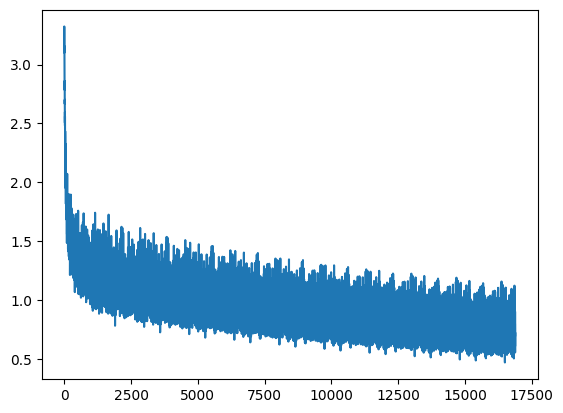

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7fu90qhh with config:
wandb: 	activation_fn: sigmoid
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	size_hidden_layer: 32
wandb: 	weight_decay: 0.005
wandb: 	weight_initialisation: random


100%|██████████| 10/10 [00:34<00:00,  3.44s/it]

Test set accuracy : 0.1 | Test set loss : 2.3490521478964013


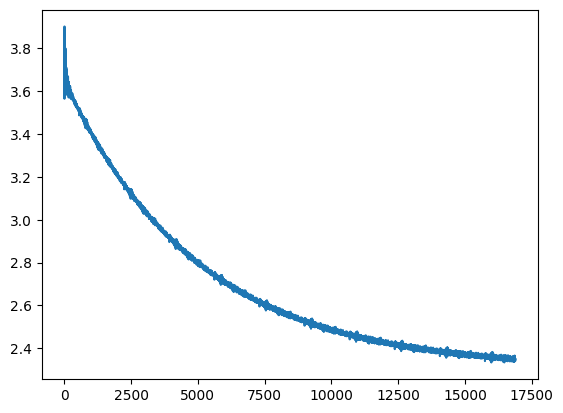

wandb: Agent Starting Run: lkz52ey9 with config:
wandb: 	activation_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.1
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	size_hidden_layer: 32
wandb: 	weight_decay: 0.005
wandb: 	weight_initialisation: random


100%|██████████| 10/10 [01:20<00:00,  8.01s/it]


Test set accuracy : 0.1 | Test set loss : 2.3378996683713735


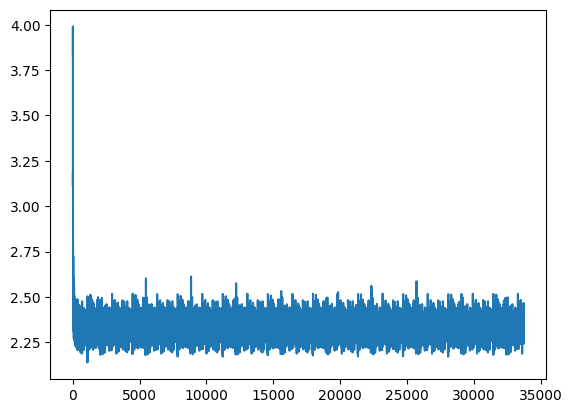

wandb: Agent Starting Run: n3xq2tuu with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	size_hidden_layer: 64
wandb: 	weight_decay: 0.005
wandb: 	weight_initialisation: random


100%|██████████| 5/5 [00:24<00:00,  4.91s/it]

Test set accuracy : 0.8225 | Test set loss : 0.8906487864121981


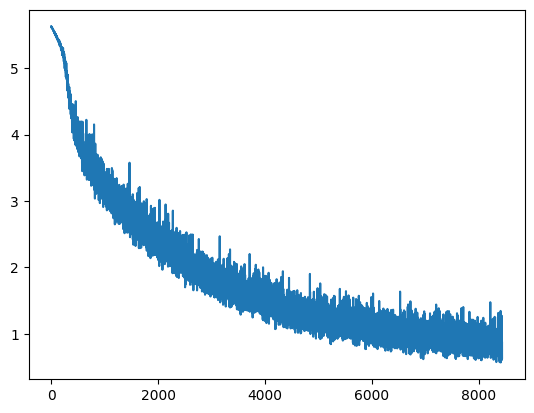

wandb: Agent Starting Run: 3he1sw55 with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [01:09<00:00,  6.96s/it]


Test set accuracy : 0.8463 | Test set loss : 0.5315594253444653


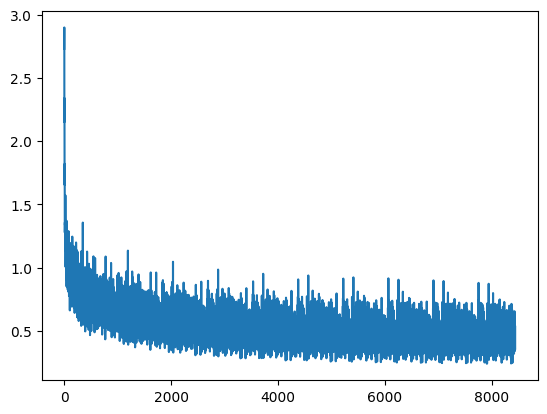

wandb: Agent Starting Run: x5ka9i0e with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0.005
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [01:35<00:00,  9.53s/it]


Test set accuracy : 0.8125 | Test set loss : 0.8135364773514495


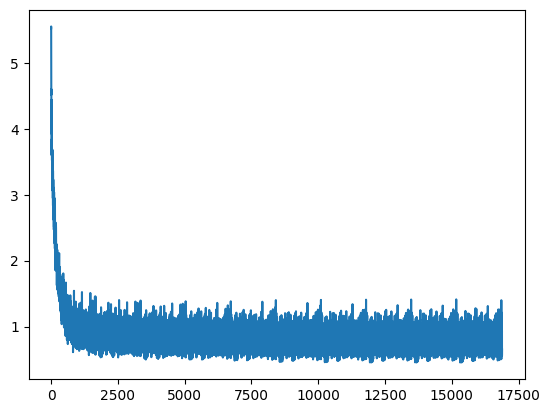

wandb: Agent Starting Run: zqdzzz3c with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [01:30<00:00,  9.08s/it]


Test set accuracy : 0.8695 | Test set loss : 0.4699085537773636


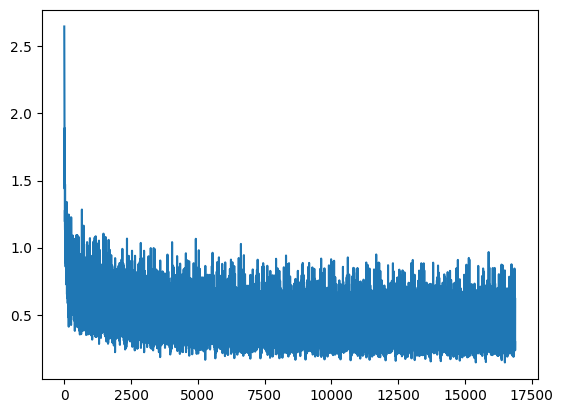

wandb: Agent Starting Run: njg7utzt with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random


100%|██████████| 5/5 [00:28<00:00,  5.60s/it]


Test set accuracy : 0.8688 | Test set loss : 0.36945641091473724


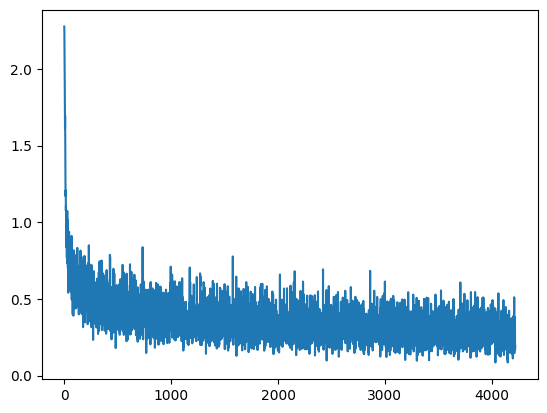

wandb: Agent Starting Run: kfq6s04e with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:45<00:00,  4.59s/it]


Test set accuracy : 0.7587 | Test set loss : 1.0673194926848448


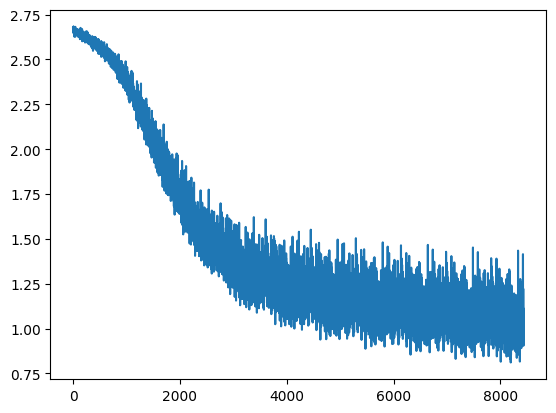

wandb: Agent Starting Run: ouc1yuni with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0.005
wandb: 	weight_initialisation: random


100%|██████████| 5/5 [00:36<00:00,  7.34s/it]


Test set accuracy : 0.8371 | Test set loss : 2.275138864938291


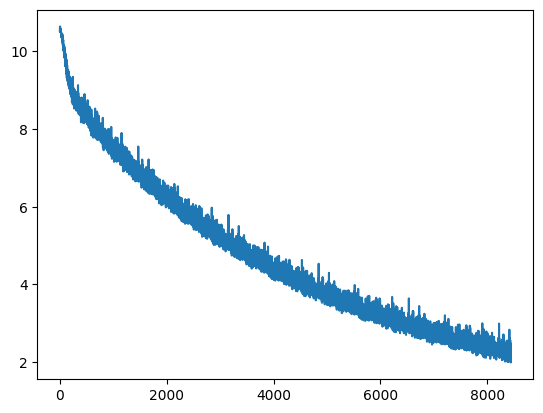

wandb: Agent Starting Run: am8mydm7 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [00:32<00:00,  6.47s/it]


Test set accuracy : 0.8554 | Test set loss : 0.4114218084052948


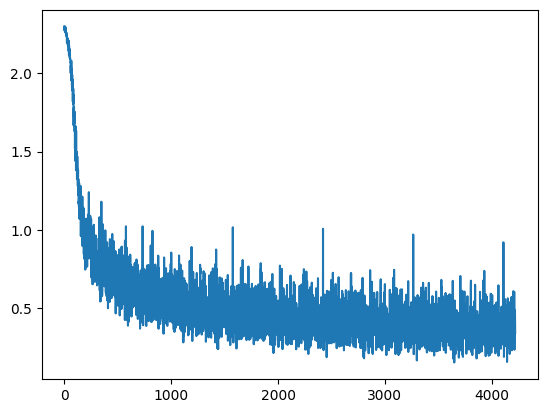

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: egjgfhdp with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [00:52<00:00, 10.53s/it]


Test set accuracy : 0.8615 | Test set loss : 0.49221561562706156


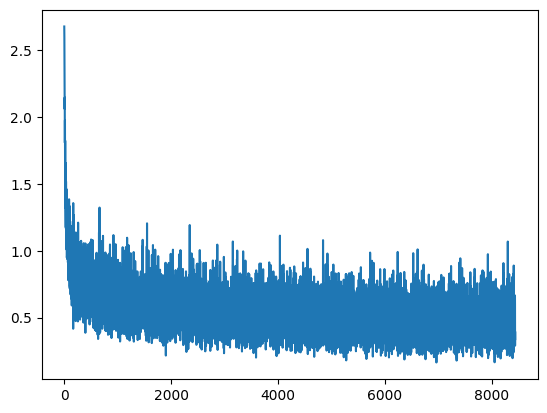

wandb: Agent Starting Run: e5ohjgv1 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0.005
wandb: 	weight_initialisation: random


100%|██████████| 10/10 [01:05<00:00,  6.53s/it]


Test set accuracy : 0.8465 | Test set loss : 0.7420072212027664


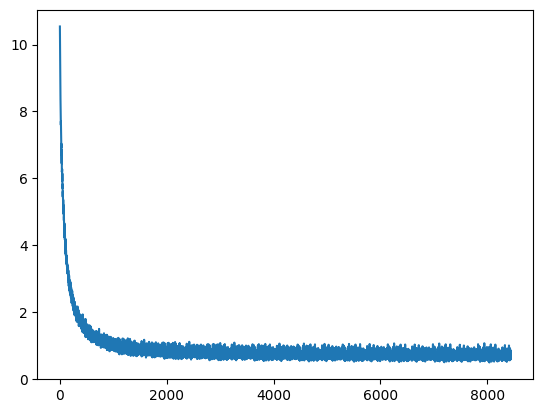

wandb: Agent Starting Run: apacz716 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [01:35<00:00,  9.53s/it]


Test set accuracy : 0.8328 | Test set loss : 0.4710893413733402


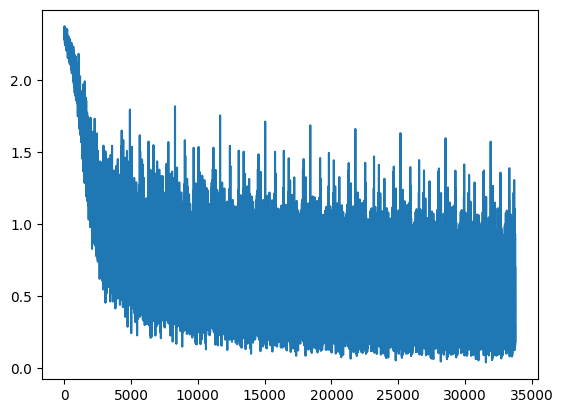

wandb: Agent Starting Run: 480ufqsh with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [01:04<00:00,  6.43s/it]


Test set accuracy : 0.8675 | Test set loss : 0.6867681925705411


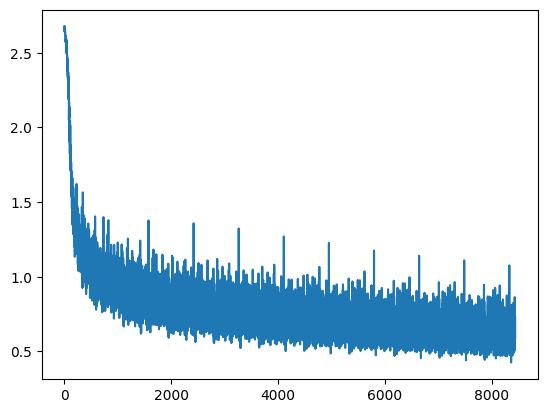

wandb: Agent Starting Run: i9cke3rk with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [01:32<00:00,  9.30s/it]


Test set accuracy : 0.8756 | Test set loss : 0.38128443338263196


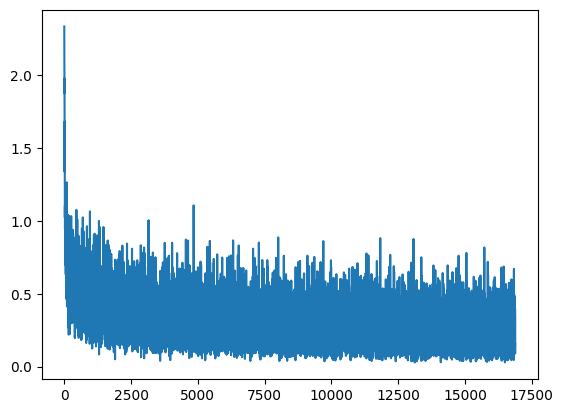

wandb: Agent Starting Run: 0rxo8dzm with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: random


100%|██████████| 5/5 [00:31<00:00,  6.36s/it]


Test set accuracy : 0.8665 | Test set loss : 0.5343689591314605


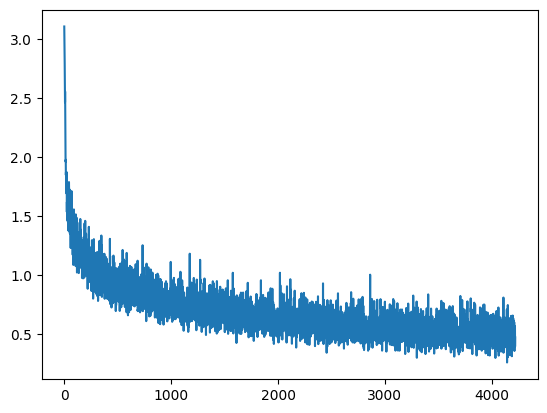

wandb: Agent Starting Run: 460lo8rv with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: random


100%|██████████| 10/10 [01:30<00:00,  9.10s/it]


Test set accuracy : 0.871 | Test set loss : 0.47048489957305406


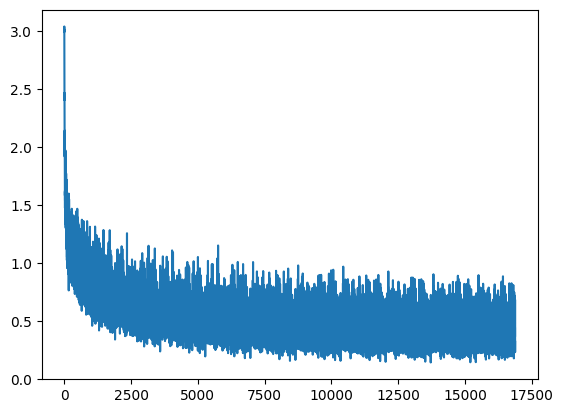

wandb: Agent Starting Run: 4vkyc7bw with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: random


100%|██████████| 5/5 [01:06<00:00, 13.29s/it]


Test set accuracy : 0.8417 | Test set loss : 0.5720894161950877


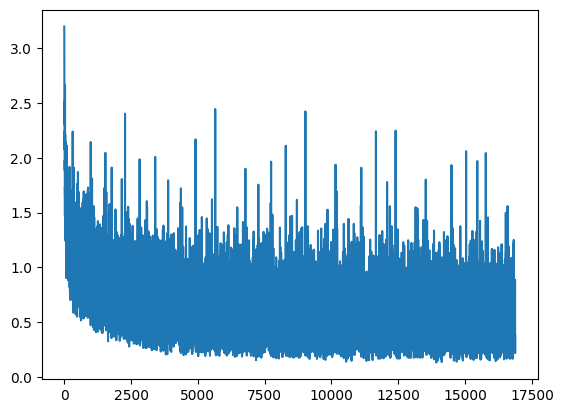

wandb: Agent Starting Run: plw77o92 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random


 60%|██████    | 3/5 [00:28<00:18,  9.43s/it]<ipython-input-14-75e18b72ee2a>:5: RuntimeWarning: divide by zero encountered in log
  return -(Y_true * np.log(Y_pred)).sum() / M
<ipython-input-14-75e18b72ee2a>:5: RuntimeWarning: invalid value encountered in multiply
  return -(Y_true * np.log(Y_pred)).sum() / M
100%|██████████| 5/5 [00:46<00:00,  9.22s/it]


Test set accuracy : 0.8592 | Test set loss : 0.49115097103477984


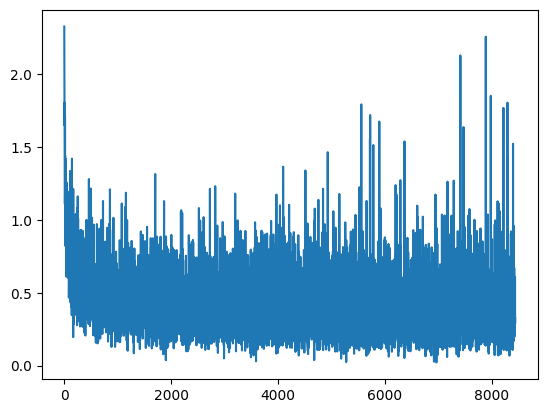

wandb: Agent Starting Run: wvjdp654 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random


100%|██████████| 5/5 [00:26<00:00,  5.28s/it]


Test set accuracy : 0.8527 | Test set loss : 0.4216583964622903


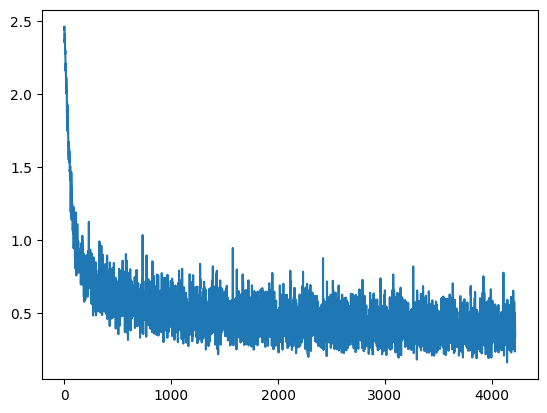

wandb: Agent Starting Run: hlp5tst3 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random


100%|██████████| 10/10 [00:50<00:00,  5.06s/it]


Test set accuracy : 0.8658 | Test set loss : 0.3795018629334601


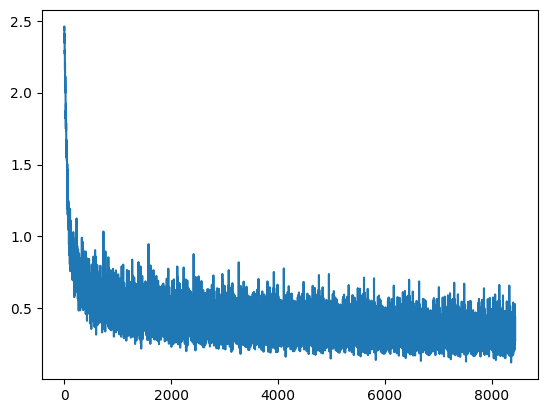

wandb: Agent Starting Run: dd4gh3td with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:52<00:00,  5.23s/it]


Test set accuracy : 0.8796 | Test set loss : 0.36901059907359696


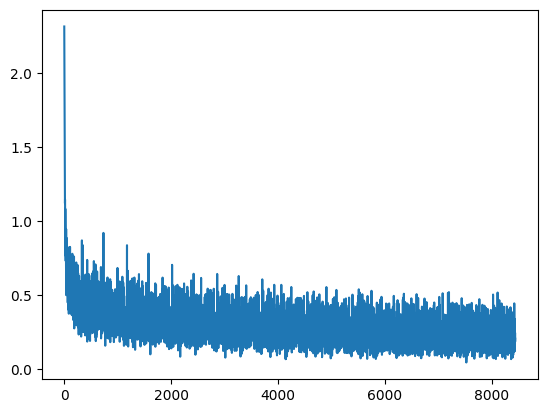

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6di2nw21 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [00:54<00:00, 10.88s/it]


Test set accuracy : 0.8065 | Test set loss : 0.9379759534216465


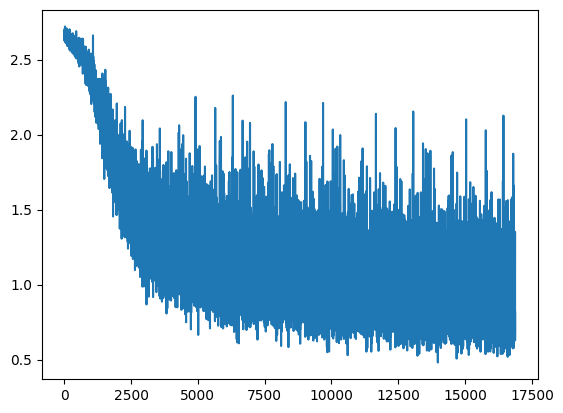

wandb: Agent Starting Run: go9ml397 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random


100%|██████████| 5/5 [01:09<00:00, 13.84s/it]


Test set accuracy : 0.8732 | Test set loss : 0.36219015314064296


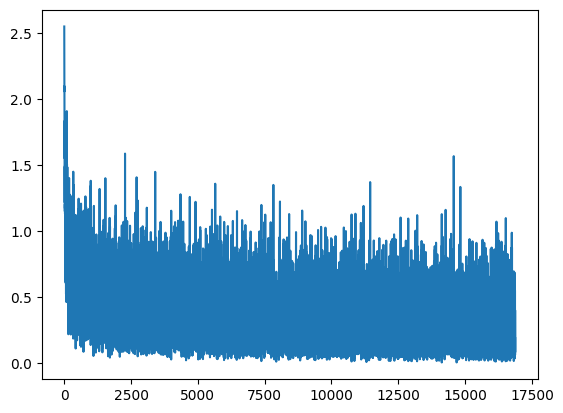

wandb: Agent Starting Run: fm2736pg with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [00:55<00:00, 11.05s/it]


Test set accuracy : 0.8611 | Test set loss : 0.6447097871576646


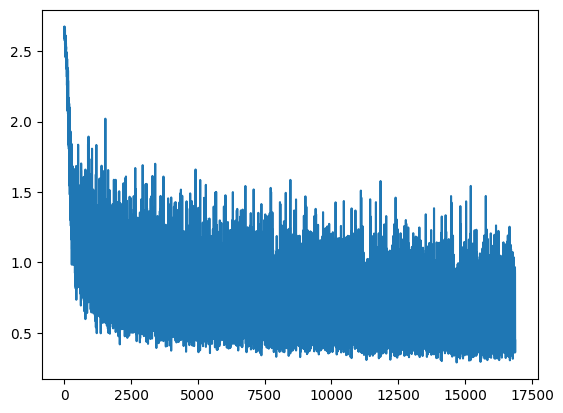

wandb: Agent Starting Run: ad9dx9uq with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:58<00:00,  5.82s/it]


Test set accuracy : 0.8485 | Test set loss : 0.5247770624153337


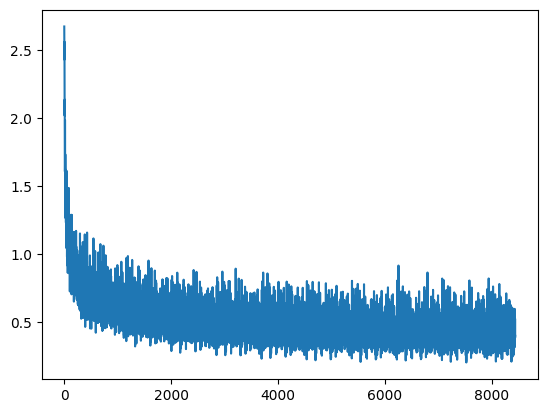

wandb: Agent Starting Run: o4wic7pl with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [00:46<00:00,  9.37s/it]


Test set accuracy : 0.8736 | Test set loss : 0.35948071942911014


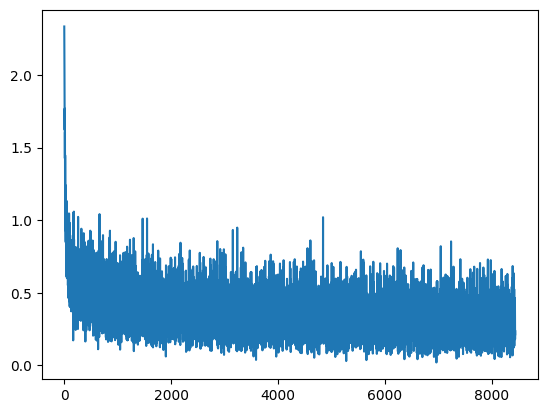

wandb: Agent Starting Run: fqks4xza with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random


100%|██████████| 5/5 [01:10<00:00, 14.12s/it]


Test set accuracy : 0.8751 | Test set loss : 0.363239746866822


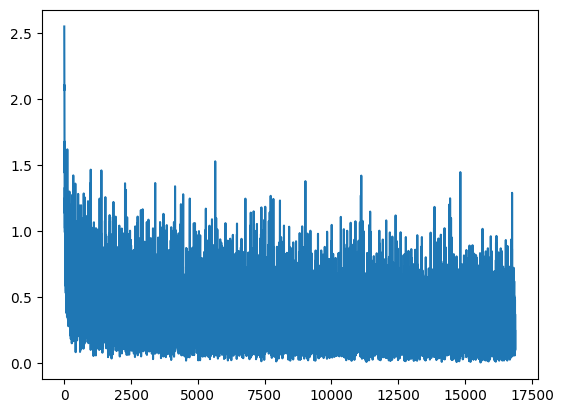

wandb: Agent Starting Run: a9mr25ur with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random


100%|██████████| 10/10 [01:09<00:00,  6.93s/it]


Test set accuracy : 0.8673 | Test set loss : 0.552050684771548


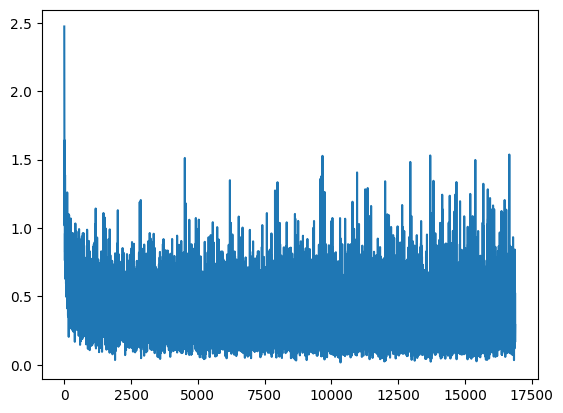

wandb: Agent Starting Run: u3zj801j with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.01
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random


100%|██████████| 5/5 [00:49<00:00,  9.94s/it]


Test set accuracy : 0.8411 | Test set loss : 0.5077683720857129


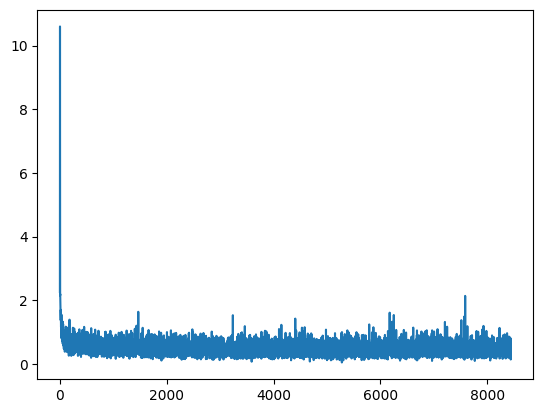

wandb: Agent Starting Run: rt1xpfat with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random


100%|██████████| 5/5 [00:26<00:00,  5.36s/it]


Test set accuracy : 0.8771 | Test set loss : 0.3566440759442376


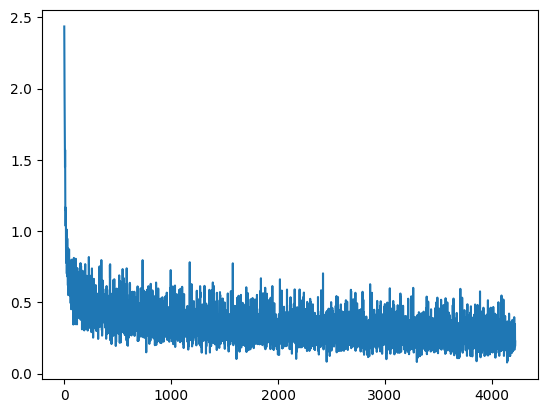

wandb: Agent Starting Run: 7cl70sht with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [01:10<00:00,  7.06s/it]


Test set accuracy : 0.8675 | Test set loss : 0.6867681925705411


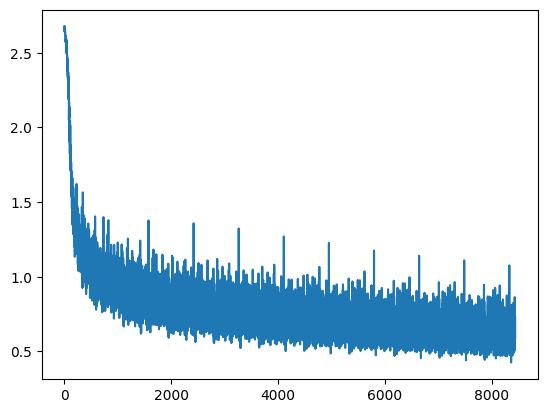

wandb: Agent Starting Run: kbcrr7xv with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.01
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [00:26<00:00,  5.26s/it]


Test set accuracy : 0.8272 | Test set loss : 0.508219221555221


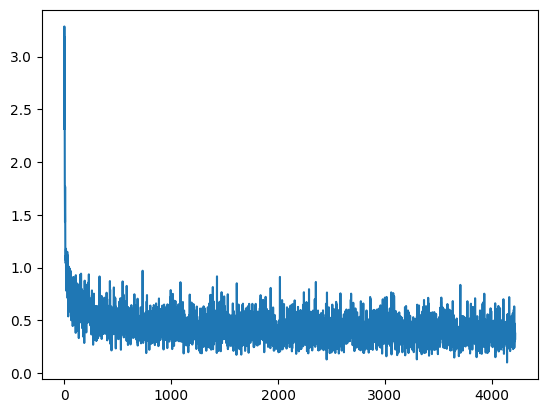

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jy42lv0y with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random


100%|██████████| 5/5 [01:08<00:00, 13.75s/it]


Test set accuracy : 0.845 | Test set loss : 0.6150070412620591


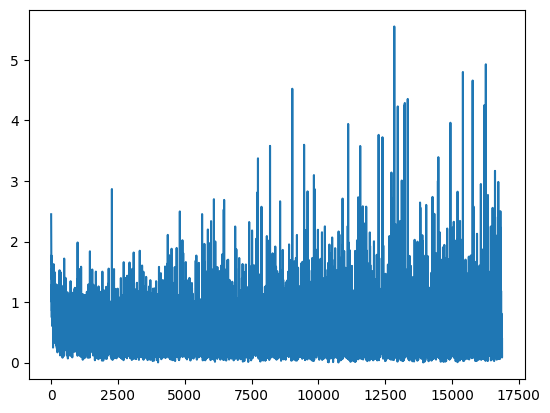

wandb: Agent Starting Run: cmnm2ozy with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0.005
wandb: 	weight_initialisation: random


100%|██████████| 5/5 [00:46<00:00,  9.36s/it]


Test set accuracy : 0.8059 | Test set loss : 0.8156562536531717


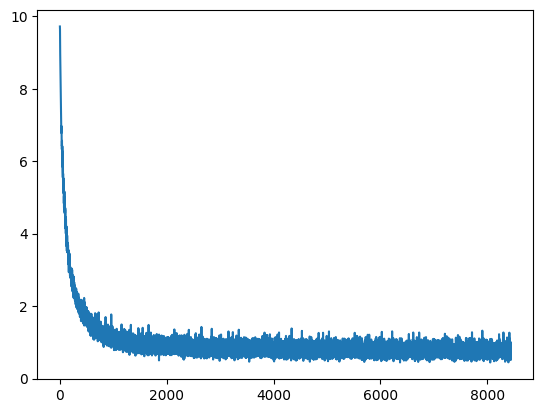

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3zewdaso with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:51<00:00,  5.12s/it]


Test set accuracy : 0.8698 | Test set loss : 0.3815271859118591


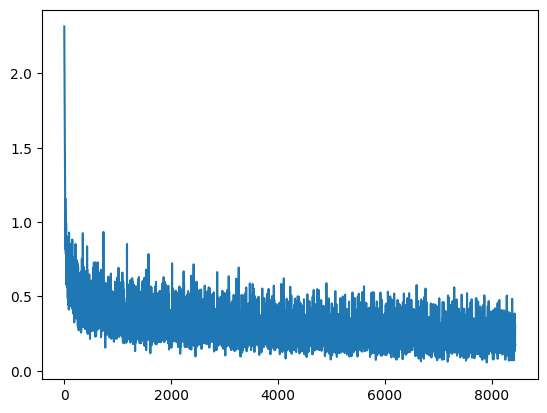

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n8z3oi61 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [00:26<00:00,  5.22s/it]


Test set accuracy : 0.8651 | Test set loss : 0.3904691901571642


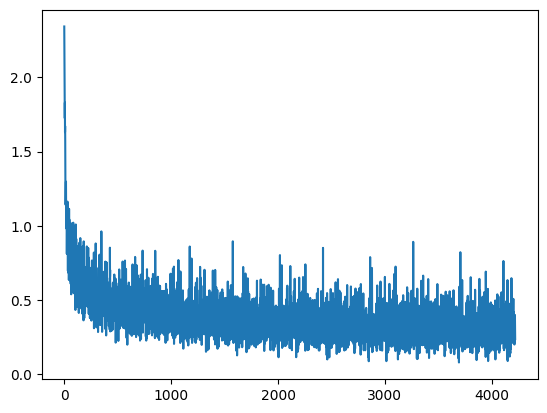

wandb: Agent Starting Run: g4cquhmc with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random


100%|██████████| 5/5 [00:31<00:00,  6.28s/it]


Test set accuracy : 0.8624 | Test set loss : 0.4676128905694546


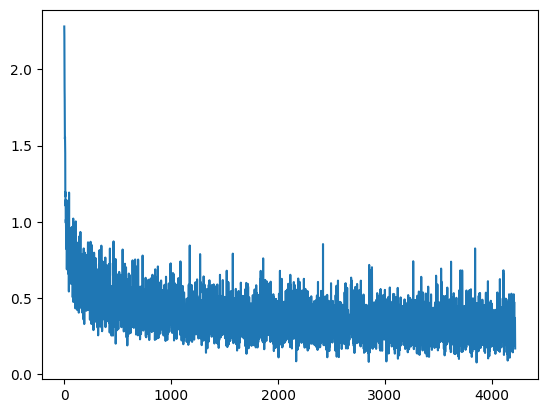

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 001dzo92 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [00:42<00:00,  8.53s/it]


Test set accuracy : 0.8638 | Test set loss : 0.4721034839805362


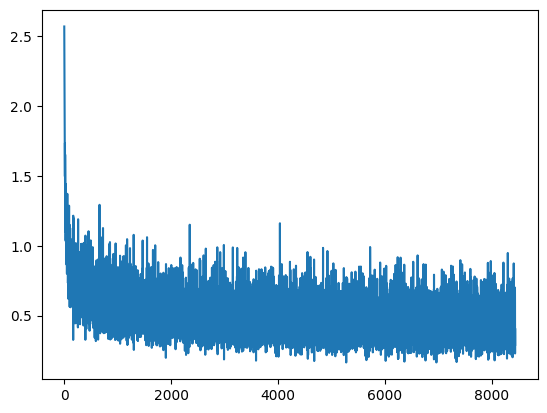

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1gmxn8co with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random


100%|██████████| 5/5 [00:29<00:00,  5.87s/it]


Test set accuracy : 0.8694 | Test set loss : 0.35983873386643134


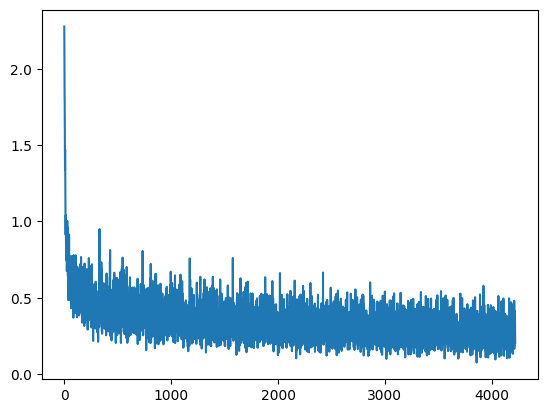

wandb: Agent Starting Run: p7h3u72x with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.01
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random


100%|██████████| 5/5 [00:27<00:00,  5.51s/it]


Test set accuracy : 0.84 | Test set loss : 0.45189770300523535


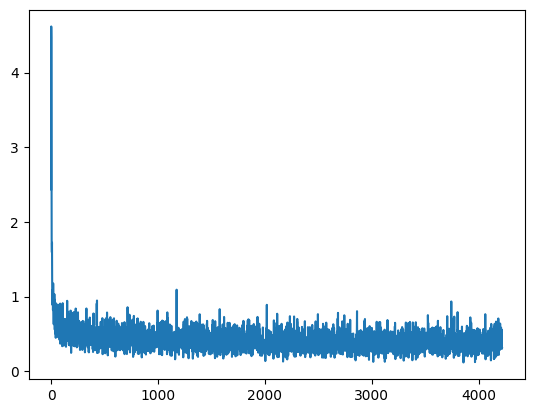

wandb: Agent Starting Run: 50k3d56y with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [00:23<00:00,  4.73s/it]


Test set accuracy : 0.8709 | Test set loss : 0.37094631707930914


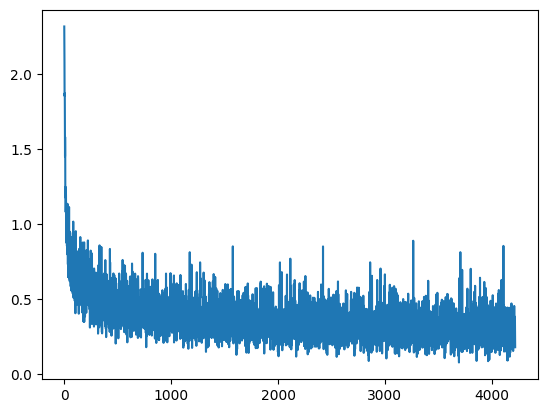

wandb: Agent Starting Run: k9vj5097 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.01
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [01:24<00:00, 16.98s/it]


Test set accuracy : 0.819 | Test set loss : nan


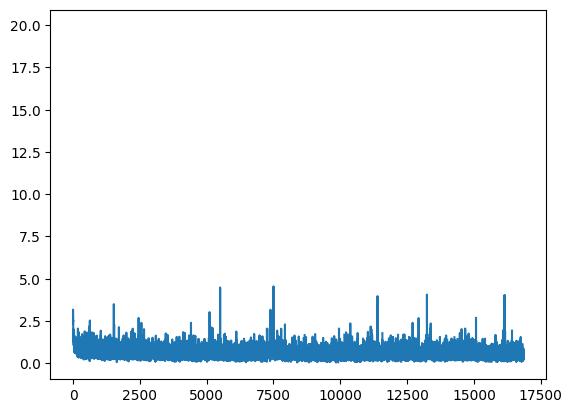

wandb: Agent Starting Run: 35rdyhe2 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [00:49<00:00,  9.91s/it]


Test set accuracy : 0.8654 | Test set loss : 0.3737487316753155


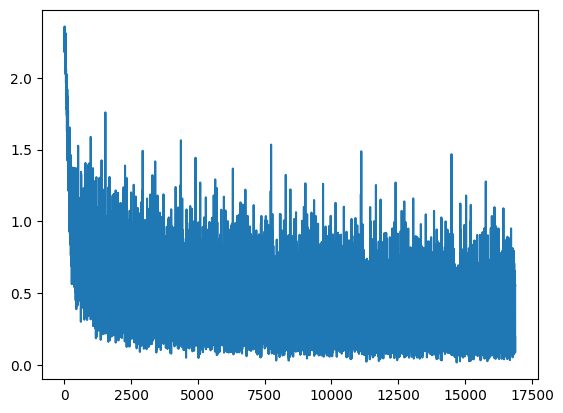

wandb: Agent Starting Run: jwgjav2j with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [00:29<00:00,  5.93s/it]


Test set accuracy : 0.8555 | Test set loss : 0.41107473540639977


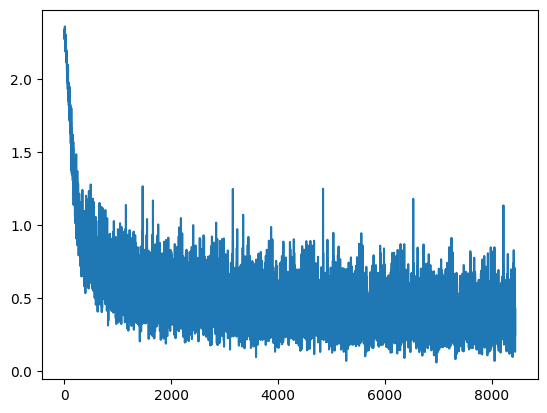

wandb: Agent Starting Run: tpb1yvap with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random


100%|██████████| 5/5 [00:26<00:00,  5.35s/it]


Test set accuracy : 0.8771 | Test set loss : 0.3566440759442376


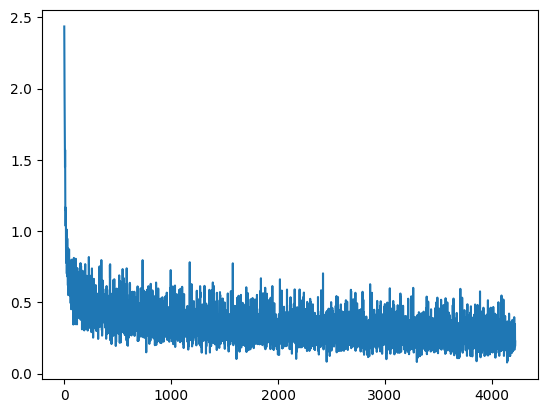

wandb: Agent Starting Run: co0w84u3 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.01
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [00:43<00:00,  8.65s/it]


Test set accuracy : 0.8503 | Test set loss : 0.44222884685747693


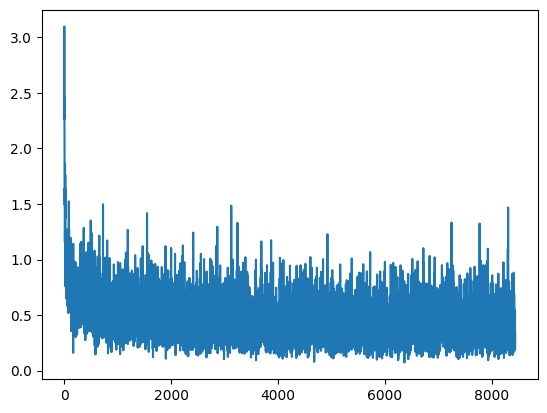

wandb: Agent Starting Run: abe5kbjw with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [00:49<00:00,  9.83s/it]


Test set accuracy : 0.8358 | Test set loss : 0.5619088208639904


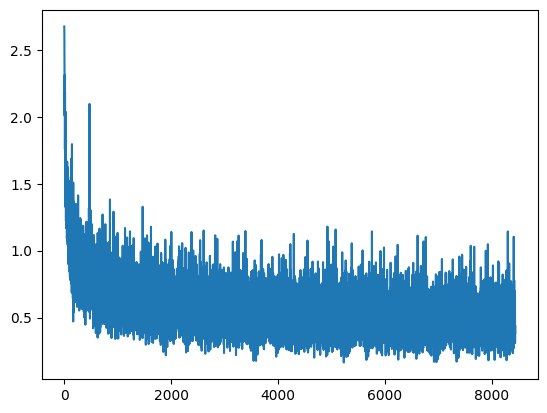

wandb: Agent Starting Run: e379wvzc with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random


100%|██████████| 5/5 [00:40<00:00,  8.09s/it]


Test set accuracy : 0.8748 | Test set loss : 0.3524903694336989


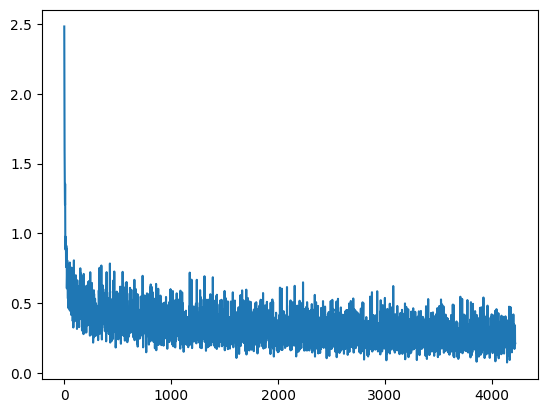

wandb: Agent Starting Run: 9plhysfz with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.1
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random


100%|██████████| 5/5 [01:13<00:00, 14.79s/it]


Test set accuracy : 0.1 | Test set loss : 2.3158029921208874


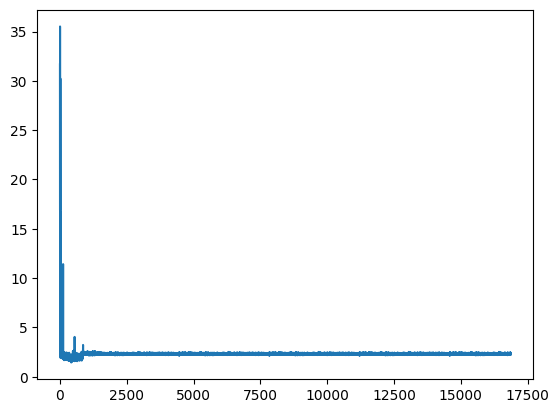

wandb: Agent Starting Run: 27lkhyj7 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: random


100%|██████████| 5/5 [00:34<00:00,  6.98s/it]


Test set accuracy : 0.866 | Test set loss : 0.5292108096377162


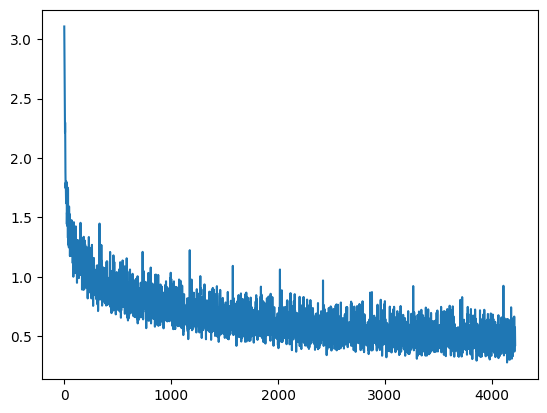

wandb: Agent Starting Run: aeryom9o with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random


100%|██████████| 5/5 [00:31<00:00,  6.39s/it]


Test set accuracy : 0.8608 | Test set loss : 0.3874636049771469


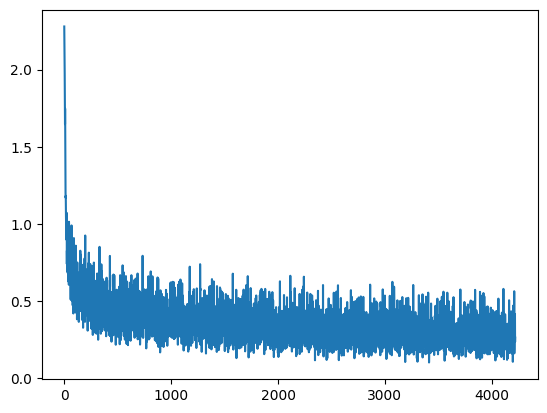

wandb: Agent Starting Run: 87prrp5m with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random


100%|██████████| 10/10 [01:28<00:00,  8.87s/it]


Test set accuracy : 0.8725 | Test set loss : 0.3816076358098125


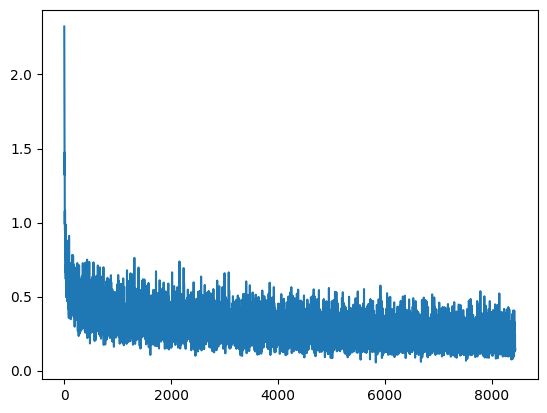

wandb: Agent Starting Run: xf8v7c9a with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [00:41<00:00,  8.32s/it]


Test set accuracy : 0.8639 | Test set loss : 0.38190679136926453


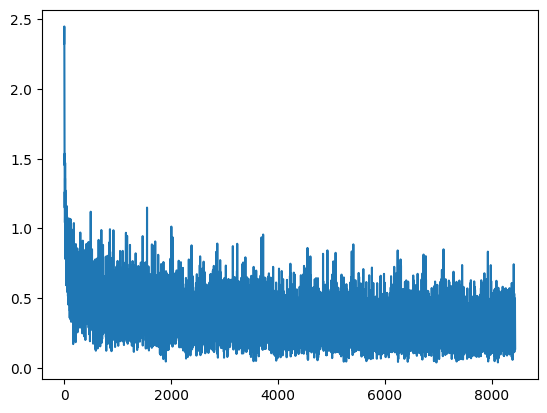

wandb: Agent Starting Run: y7w1ygz1 with config:
wandb: 	activation_fn: sigmoid
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [01:03<00:00, 12.75s/it]


Test set accuracy : 0.8524 | Test set loss : 0.4318809495880843


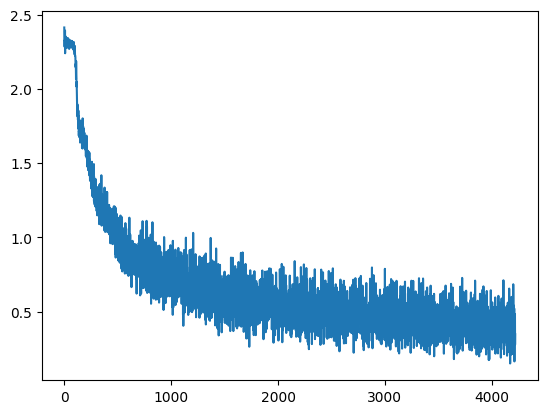

wandb: Agent Starting Run: dpn72za8 with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [01:04<00:00, 12.84s/it]


Test set accuracy : 0.8658 | Test set loss : 0.37125791087627275


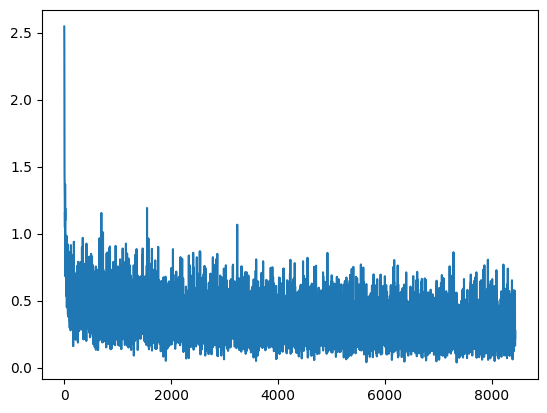

wandb: Agent Starting Run: ajdevfhh with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [01:15<00:00, 15.00s/it]


Test set accuracy : 0.8474 | Test set loss : 0.5603121856104266


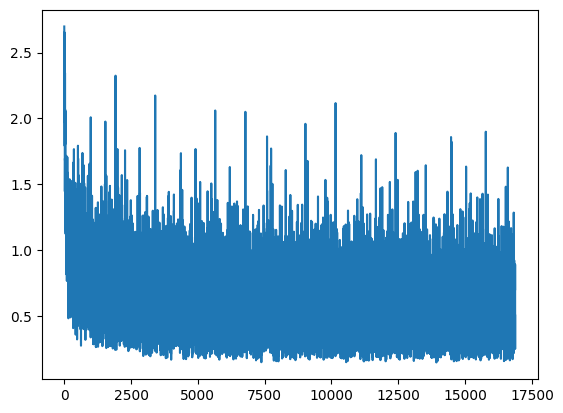

wandb: Agent Starting Run: cjvbsd25 with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random


100%|██████████| 10/10 [01:16<00:00,  7.63s/it]


Test set accuracy : 0.8572 | Test set loss : 0.39657042443143503


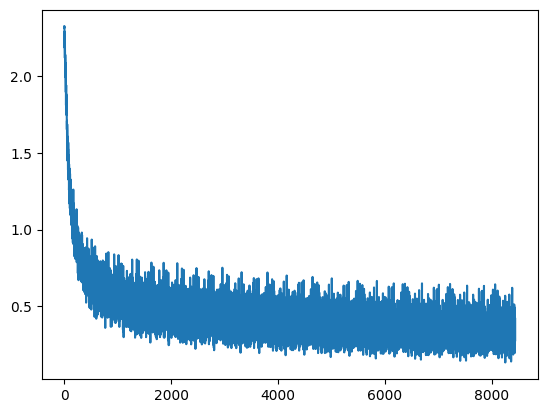

wandb: Agent Starting Run: 7kkawpe6 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random


100%|██████████| 5/5 [00:32<00:00,  6.49s/it]


Test set accuracy : 0.8608 | Test set loss : 0.3874636049771469


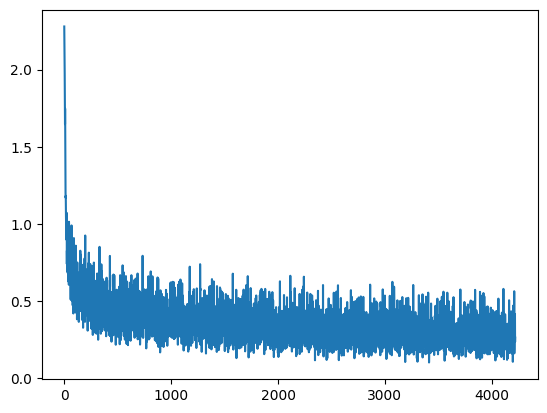

wandb: Agent Starting Run: yx2tn55i with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [00:45<00:00,  9.12s/it]


Test set accuracy : 0.8611 | Test set loss : 0.49878835699373764


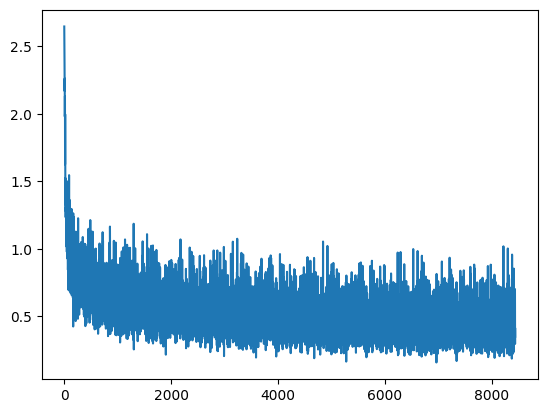

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: a0ekfklj with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [00:30<00:00,  6.14s/it]


Test set accuracy : 0.8737 | Test set loss : 0.35860586025066377


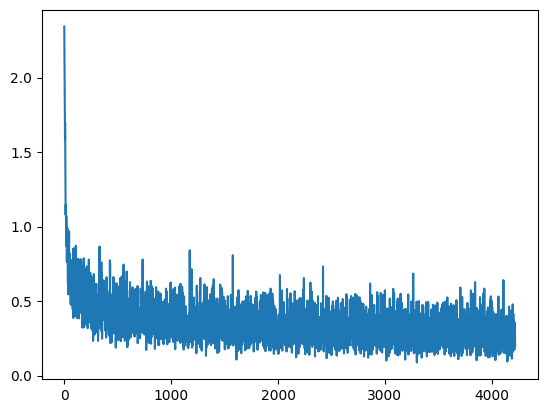

wandb: Agent Starting Run: vuqjzvsn with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [01:30<00:00,  9.08s/it]


Test set accuracy : 0.8692 | Test set loss : 0.39473590520264457


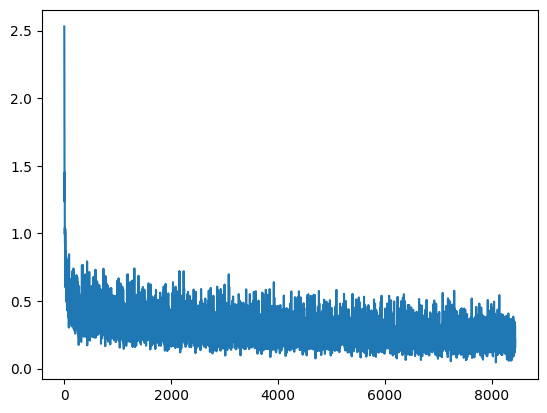

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yue5zieq with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: random


100%|██████████| 5/5 [00:32<00:00,  6.54s/it]


Test set accuracy : 0.866 | Test set loss : 0.5292108096377162


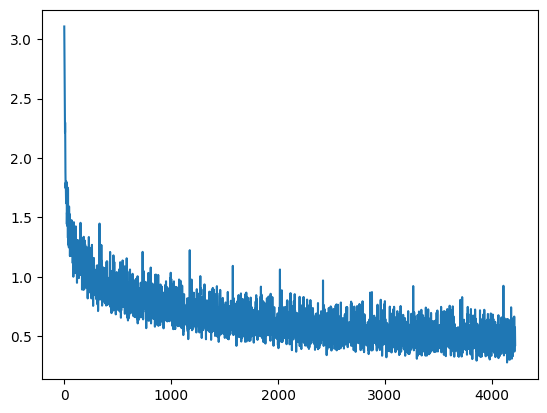

wandb: Agent Starting Run: pyujidvy with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random


100%|██████████| 10/10 [01:06<00:00,  6.68s/it]


Test set accuracy : 0.8722 | Test set loss : 0.41462659353061837


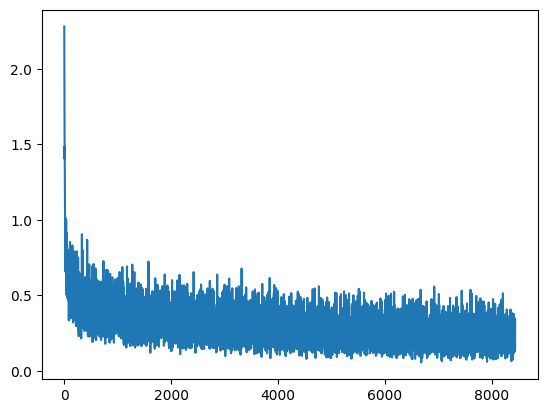

wandb: Agent Starting Run: rtazukav with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 64
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [00:15<00:00,  3.14s/it]


Test set accuracy : 0.8677 | Test set loss : 0.46934705762762785


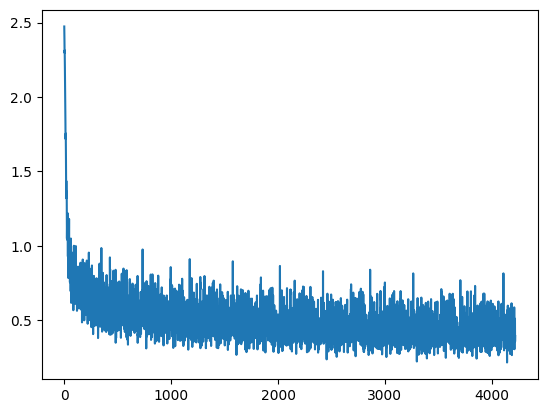

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tggatu2q with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	size_hidden_layer: 32
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [00:10<00:00,  2.03s/it]

Test set accuracy : 0.8449 | Test set loss : 0.4430072981566301


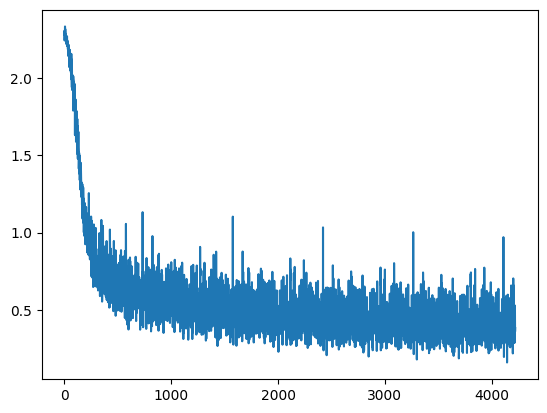

wandb: Agent Starting Run: 2s4ticm3 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 64
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [00:13<00:00,  2.78s/it]

Test set accuracy : 0.8728 | Test set loss : 0.3573518283283799


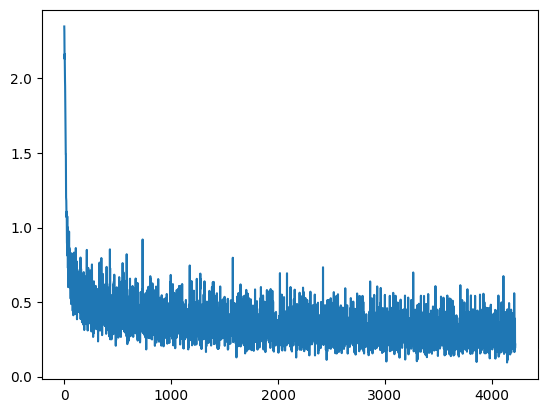

wandb: Agent Starting Run: 0fh5sc1i with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [00:33<00:00,  6.63s/it]


Test set accuracy : 0.87 | Test set loss : 0.4842421909049038


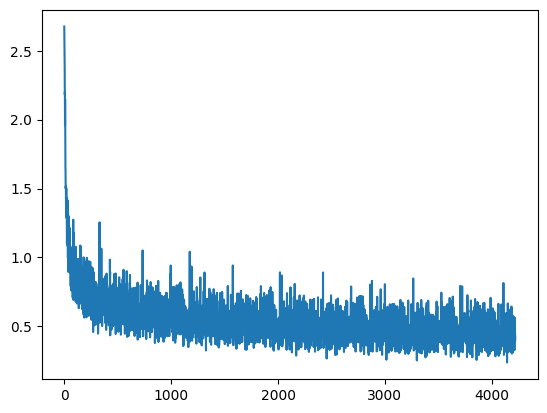

wandb: Agent Starting Run: 6v6huwy3 with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	size_hidden_layer: 64
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [00:22<00:00,  4.57s/it]


Test set accuracy : 0.8665 | Test set loss : 0.383638897479541


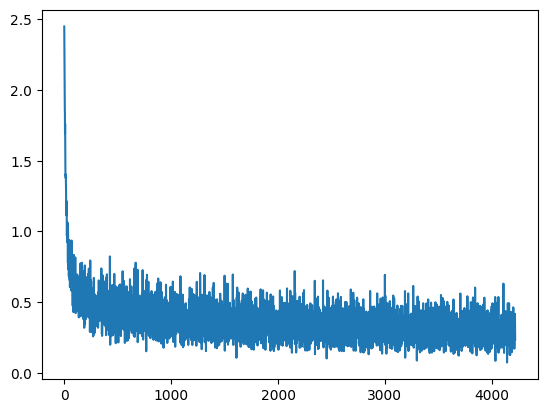

wandb: Agent Starting Run: ohdpuhwt with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random


100%|██████████| 5/5 [00:28<00:00,  5.73s/it]


Test set accuracy : 0.8694 | Test set loss : 0.35983873386643134


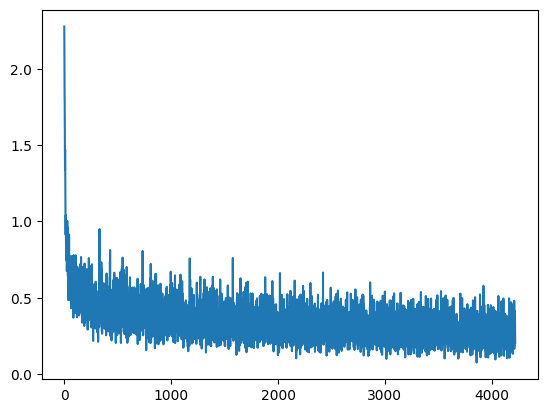

wandb: Agent Starting Run: gbb5qhn1 with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [00:45<00:00,  9.02s/it]


Test set accuracy : 0.8728 | Test set loss : 0.36457162057194104


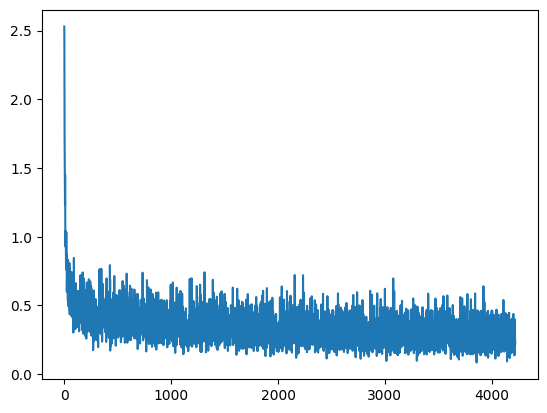

wandb: Agent Starting Run: qx3cy1js with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 32
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [00:17<00:00,  3.46s/it]


Test set accuracy : 0.8565 | Test set loss : 0.48673580074804934


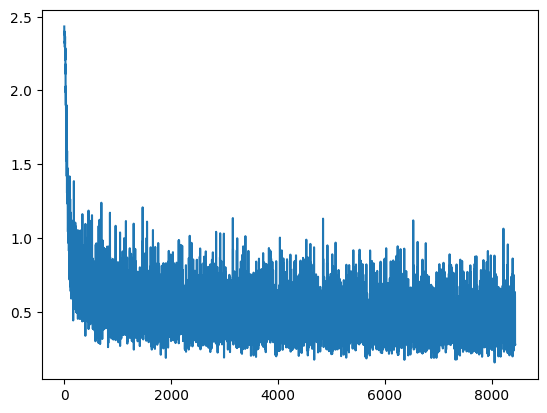

wandb: Agent Starting Run: 55y9pzah with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 64
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [00:16<00:00,  3.38s/it]


Test set accuracy : 0.869 | Test set loss : 0.47668175018017733


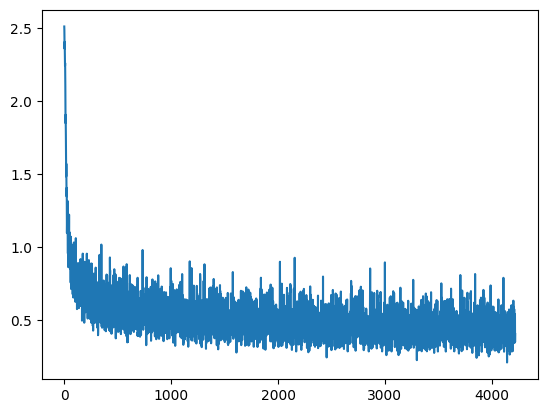

wandb: Agent Starting Run: dj6atwg1 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	size_hidden_layer: 64
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [00:16<00:00,  3.28s/it]

Test set accuracy : 0.8682 | Test set loss : 0.3765259417954065


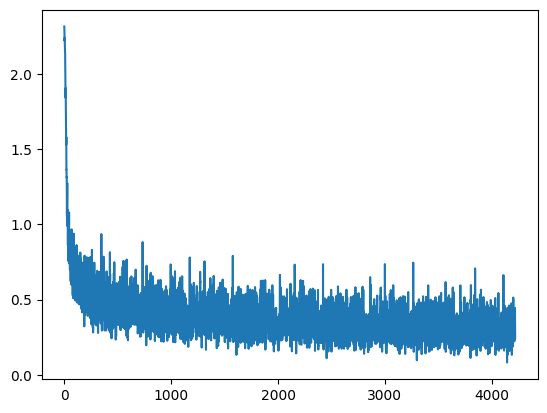

wandb: Agent Starting Run: 63hwclgy with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [00:33<00:00,  6.70s/it]


Test set accuracy : 0.8755 | Test set loss : 0.35109057400685223


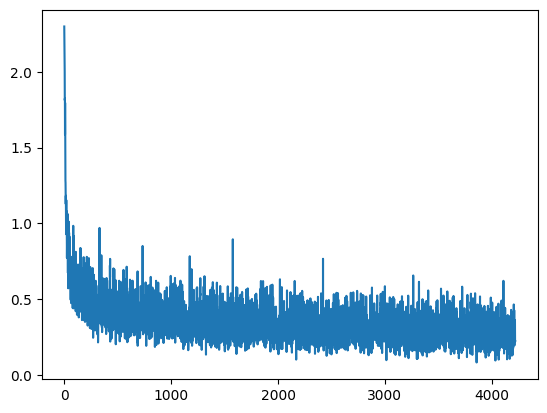

wandb: Agent Starting Run: aqe5qrqh with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 32
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random


100%|██████████| 5/5 [00:09<00:00,  1.97s/it]


Test set accuracy : 0.8506 | Test set loss : 0.42630013426514163


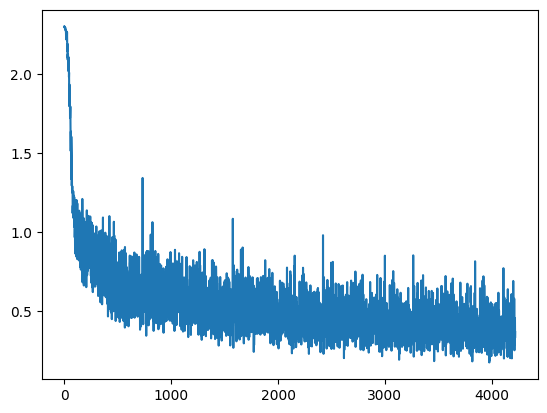

wandb: Agent Starting Run: hfq0r4o1 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0.005
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [00:44<00:00,  8.91s/it]


Test set accuracy : 0.8024 | Test set loss : 0.8607556496051223


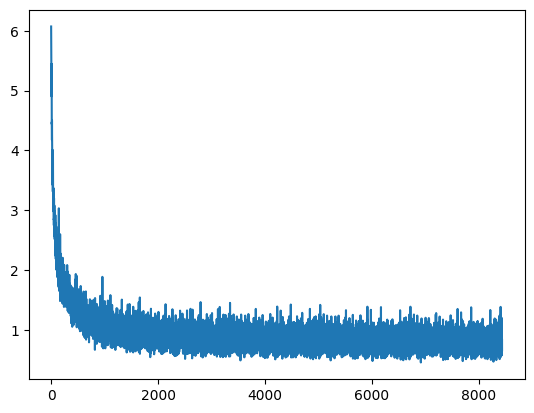

wandb: Agent Starting Run: br5eb4f1 with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [00:45<00:00,  9.06s/it]


Test set accuracy : 0.8728 | Test set loss : 0.36457162057194104


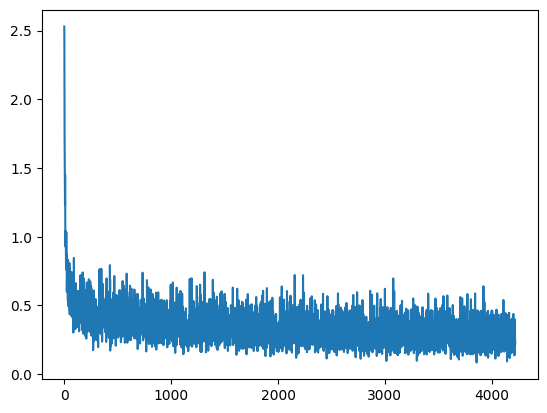

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z9ehxeec with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:58<00:00,  5.86s/it]


Test set accuracy : 0.8699 | Test set loss : 0.3885160289024094


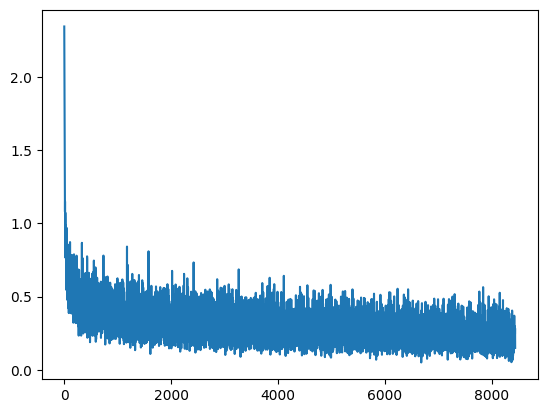

wandb: Agent Starting Run: 6yoz27wa with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [00:25<00:00,  5.16s/it]


Test set accuracy : 0.8719 | Test set loss : 0.46138463274984387


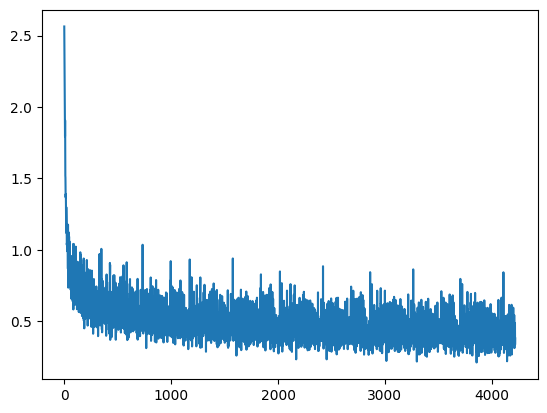

wandb: Agent Starting Run: 2wo075xb with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:58<00:00,  5.86s/it]


Test set accuracy : 0.8675 | Test set loss : 0.5104660420613218


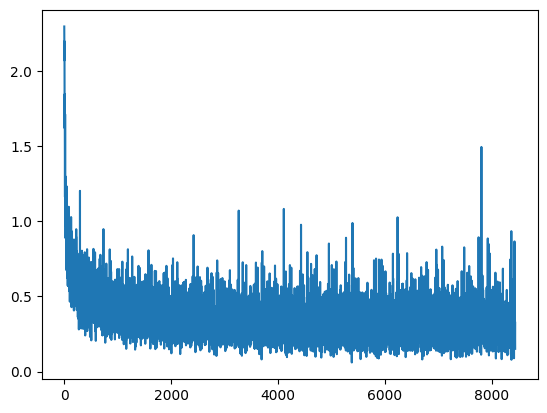

wandb: Agent Starting Run: utcssbrg with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 32
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


Test set accuracy : 0.8667 | Test set loss : 0.3819867059673846


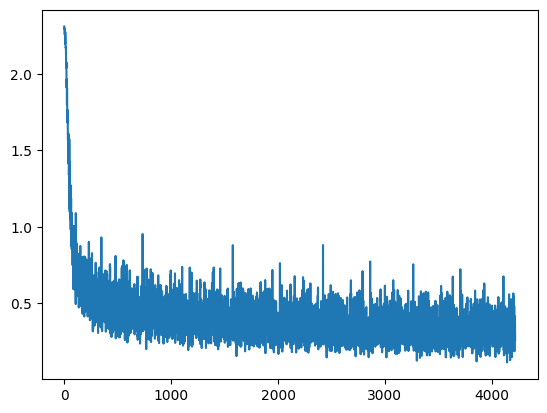

wandb: Agent Starting Run: 1qqz6466 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [00:24<00:00,  4.97s/it]


Test set accuracy : 0.8674 | Test set loss : 0.3662674313449172


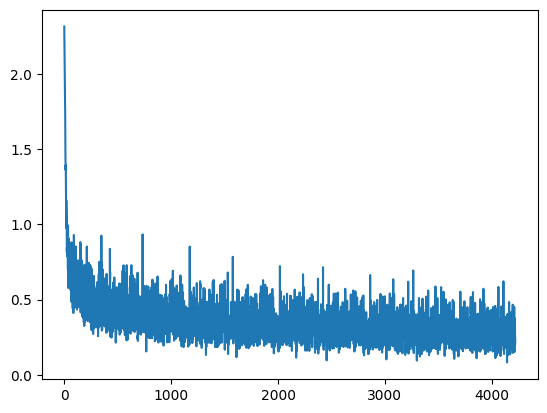

wandb: Agent Starting Run: q77bmot2 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [01:15<00:00,  7.52s/it]


Test set accuracy : 0.8559 | Test set loss : nan


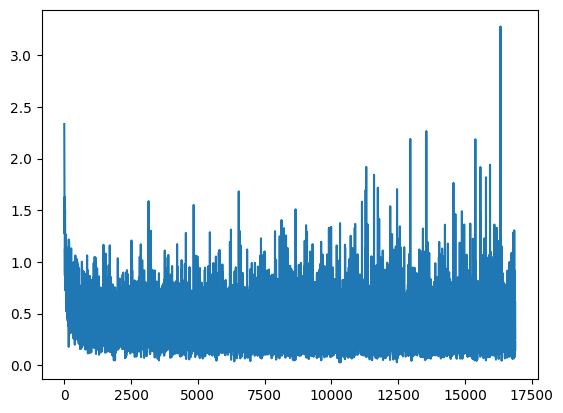

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2j4irky7 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [01:05<00:00,  6.51s/it]


Test set accuracy : 0.8732 | Test set loss : 0.46412976316786075


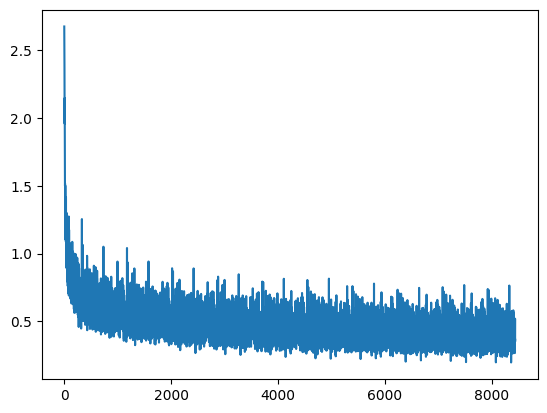

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: oensdq3o with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [01:30<00:00,  9.07s/it]


Test set accuracy : 0.8756 | Test set loss : 0.38128443338263196


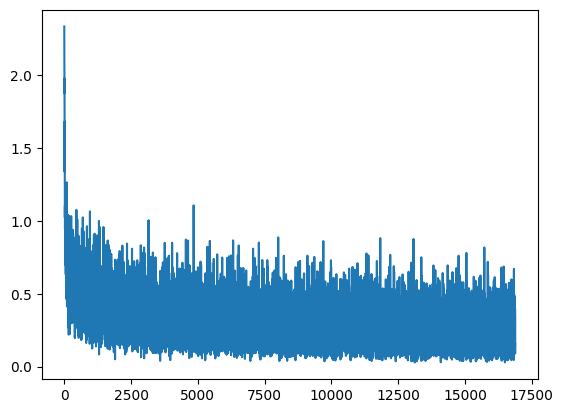

wandb: Agent Starting Run: ekvb9wc2 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [01:07<00:00,  6.71s/it]


Test set accuracy : 0.8761 | Test set loss : 0.3866472008501835


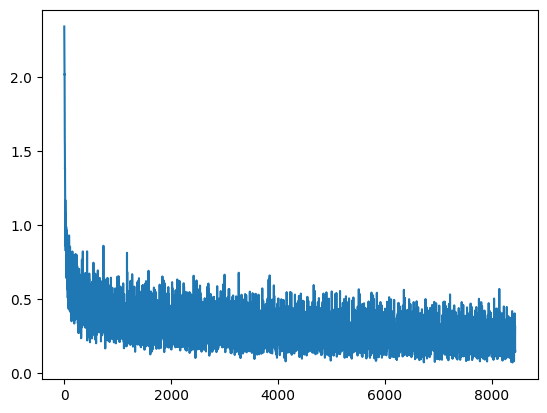

wandb: Agent Starting Run: s0vkb0xf with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	size_hidden_layer: 64
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


Test set accuracy : 0.8664 | Test set loss : 0.3903037334103635


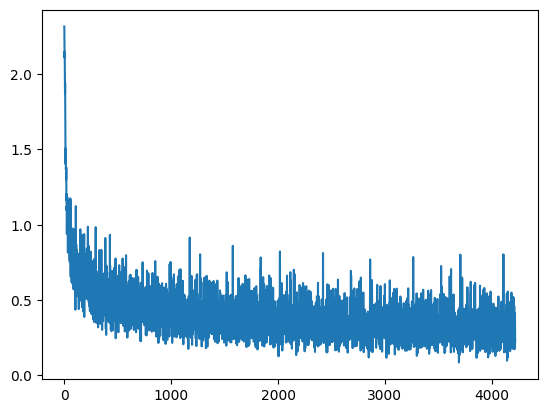

wandb: Agent Starting Run: mwbj52sf with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	size_hidden_layer: 32
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


Test set accuracy : 0.865 | Test set loss : 0.3879709341474008


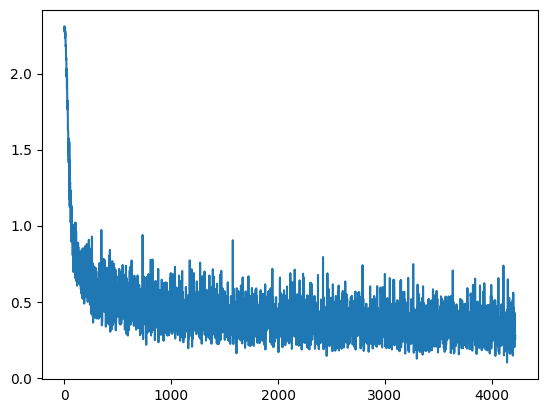

wandb: Agent Starting Run: 31b2pqbb with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 64
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [00:18<00:00,  3.76s/it]


Test set accuracy : 0.869 | Test set loss : 0.47668175018017733


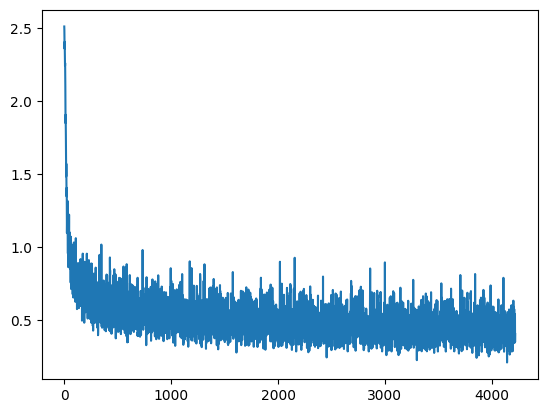

wandb: Agent Starting Run: 2i31ifnx with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [00:29<00:00,  5.97s/it]


Test set accuracy : 0.8528 | Test set loss : 0.7101627782587194


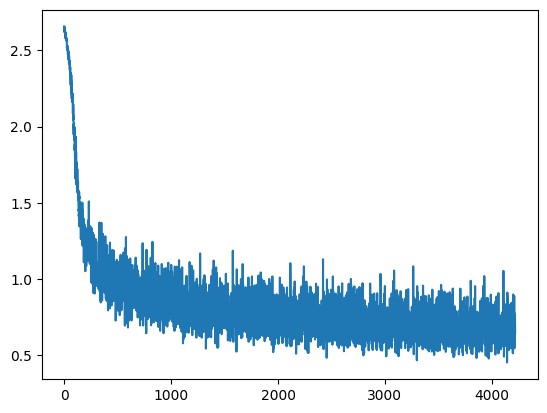

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lv8xda8u with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [00:43<00:00,  8.68s/it]


Test set accuracy : 0.8739 | Test set loss : 0.35069929558681084


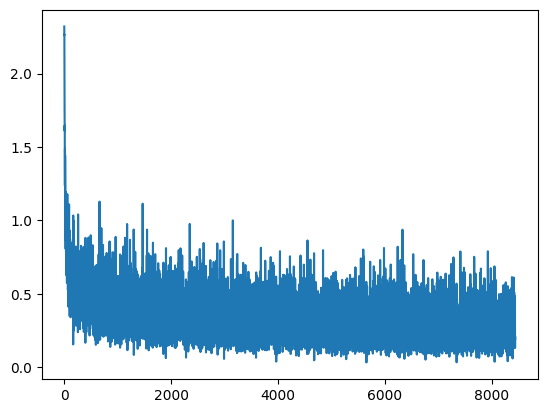

wandb: Agent Starting Run: la748iin with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 64
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [00:17<00:00,  3.45s/it]


Test set accuracy : 0.869 | Test set loss : 0.47668175018017733


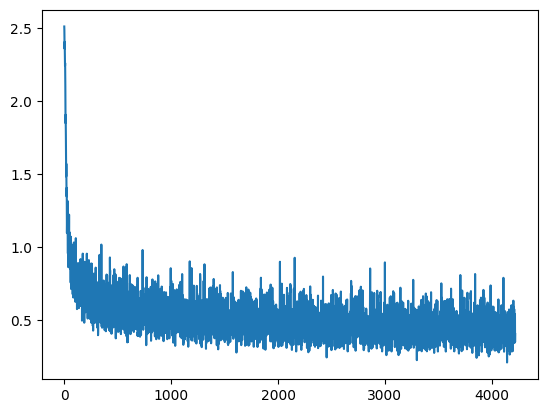

wandb: Agent Starting Run: xixhgjz9 with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 64
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [00:21<00:00,  4.36s/it]


Test set accuracy : 0.872 | Test set loss : 0.3632507620958964


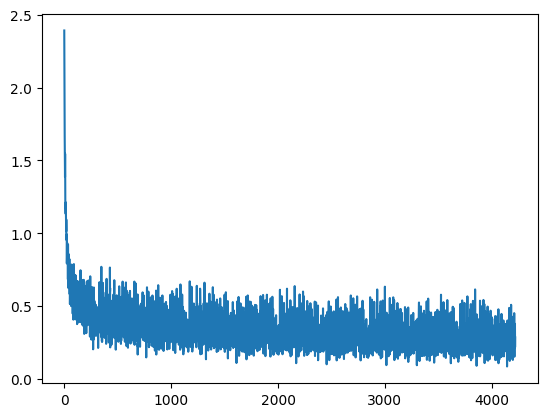

wandb: Agent Starting Run: 631wgnzj with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0.005
wandb: 	weight_initialisation: random


100%|██████████| 5/5 [00:33<00:00,  6.69s/it]


Test set accuracy : 0.8395 | Test set loss : 0.7707254661698169


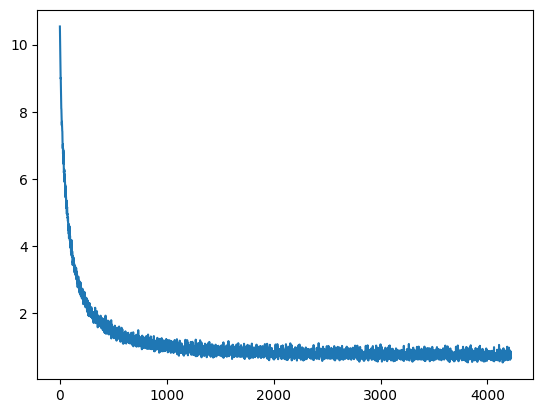

wandb: Agent Starting Run: s0thigjg with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 64
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random


100%|██████████| 5/5 [00:17<00:00,  3.40s/it]


Test set accuracy : 0.8649 | Test set loss : 0.37959057768120663


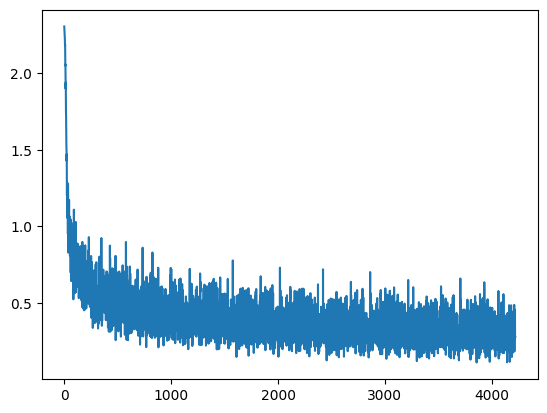

wandb: Agent Starting Run: 9j09x4z8 with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [01:04<00:00, 12.80s/it]


Test set accuracy : 0.8658 | Test set loss : 0.37125791087627275


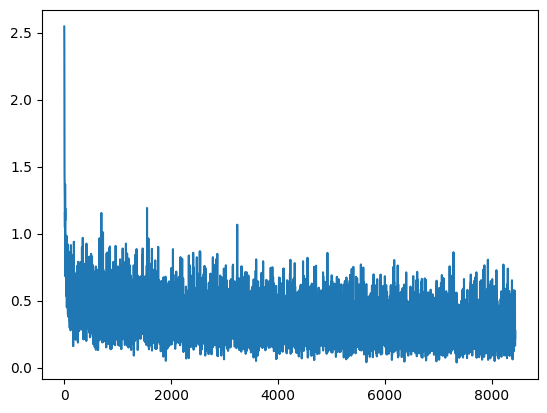

wandb: Agent Starting Run: x81107ze with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [01:02<00:00, 12.44s/it]


Test set accuracy : 0.8653 | Test set loss : 0.37557664255357764


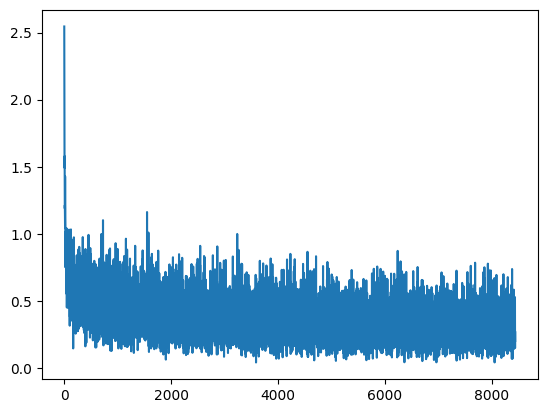

wandb: Agent Starting Run: e18t42ai with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [00:44<00:00,  8.83s/it]


Test set accuracy : 0.8616 | Test set loss : 0.38208833380876456


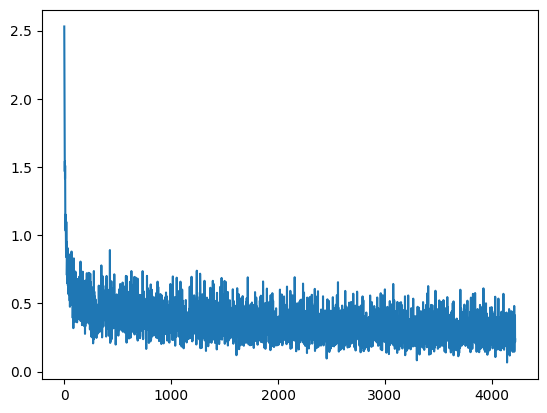

wandb: Agent Starting Run: 0cs0vi6i with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	size_hidden_layer: 64
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier
wandb: Ctrl + C detected. Stopping sweep.


In [ ]:
# Questions 4-6 -- Running a sweep across different hyperparameter configurations with cross entropy as the loss function
# ---------------- Uncomment the below code to run -----------------

sweep_id = wandb.sweep(sweep_config, project="assignment_1", entity="duenchombo1-indian-institute-of-technology-madras")
wandb.agent(sweep_id, lambda : sweep_wrapper(trainX_tr, trainY_tr, validX_tr, validY_tr, testX_tr, testY_tr, 'cross-entropy'))

# Question 6 (second part)
# The question asks for a recommendation for what configuration to use to get close to 95% accuracy.
# We tried the following setting and other modifications including increasing epochs to 60 and hidden layer size to 512.
# We reached a train accuracy of close to 94 %, but the validation and test accuracy stay close to 88%.
# This implies that the model may overfit if we increase the complexity further
# ---------------- Uncomment the below code to run -----------------

# network, *_ = train_wrapper(trainX_tr, trainY_tr, 'adam', 256, 5e-4, 40, 4, 256, 'xavier', 'relu', 'cross-entropy',
#                            0.0005, validX_tr, validY_tr, testX_tr, testY_tr, 'L2')


# Future steps to increase test accuracy are to increase the quantity and quality of training data by using methods like Data augmentation.
# (this will increase the size of the training data which might be useful for training the higher number of neurons
#  in a way that will generalise well to new examples)

In [ ]:
# Question 6 (second part)
# The question asks for a recommendation for what configuration to use to get close to 95% accuracy.
# We tried the following setting and other modifications including increasing epochs to 60 and hidden layer size to 512.
# We reached a train accuracy of close to 94 %, but the validation and test accuracy stay close to 88%.
# This implies that the model may overfit if we increase the complexity further
# ---------------- Uncomment the below code to run -----------------

network, *_ = train_wrapper(trainX_tr, trainY_tr, 'adam', 256, 5e-4, 40, 4, 256, 'xavier', 'relu', 'cross-entropy',
                           0.0005, validX_tr, validY_tr, testX_tr, testY_tr, 'L2')


# Future steps to increase test accuracy are to increase the quantity and quality of training data by using methods like Data augmentation.
# (this will increase the size of the training data which might be useful for training the higher number of neurons
#  in a way that will generalise well to new examples)

100%|██████████| 10/10 [01:19<00:00,  7.94s/it]


Test set accuracy : 0.8737 | Test set loss : 0.5016692806338972


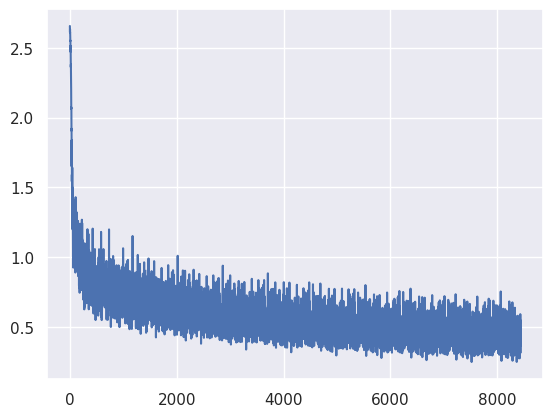

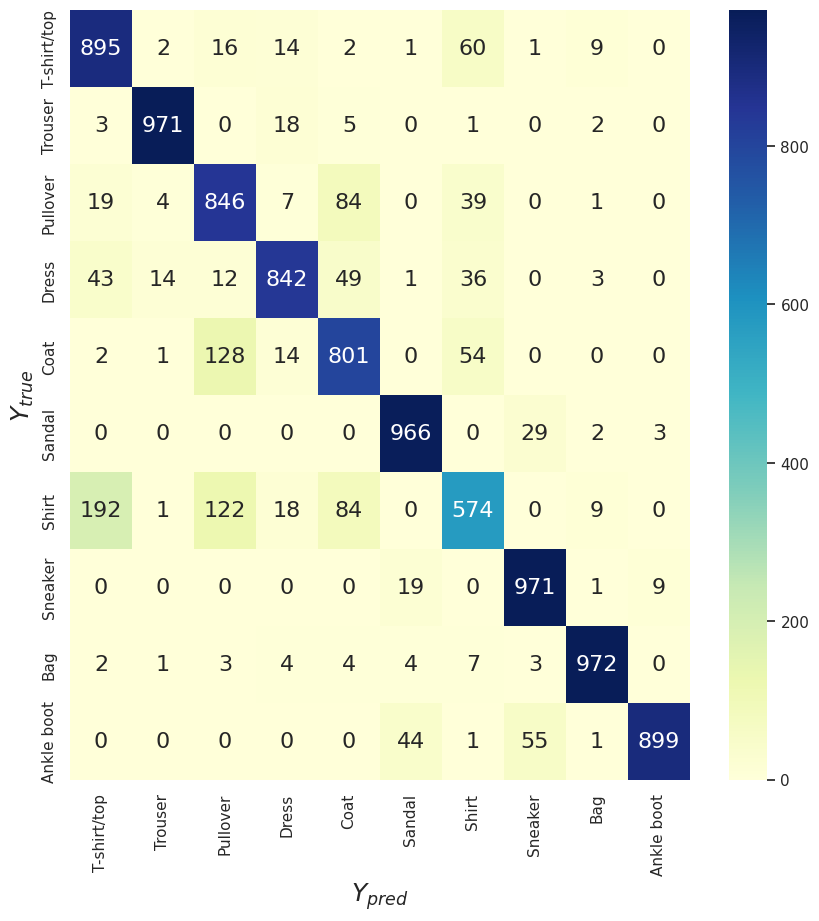

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import wandb

def plot_confusion_matrix(network, X, Y):
    Y_pred = forward_propagation(network, X)
    cm = confusion_matrix(np.argmax(Y, axis=0), np.argmax(Y_pred, axis=0))

    df_cm = pd.DataFrame(cm, index=[IMG_LABELS[i] for i in range(cm.shape[0])],
                            columns=[IMG_LABELS[i] for i in range(cm.shape[0])])

    plt.figure(figsize=(10,10))
    sn.set(font_scale=1.0)
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap='YlGnBu', fmt='g')

    plt.ylabel(r'$Y_{true}$', fontsize=18)
    plt.xlabel(r'$Y_{pred}$', fontsize=18)

    plt.savefig("confusion_matrix.png")  # ✅ Save the figure before logging
    plt.show()  # ✅ Ensure it displays in Colab

    # ✅ Log the saved figure to WandB
    wandb.log({'Confusion Matrix': wandb.Image("confusion_matrix.png")})

    plt.close()  # ✅ Close the figure to avoid duplication issues

# Initialize WandB logging
run = wandb.init(project="assignment_1", entity="duenchombo1-indian-institute-of-technology-madras", reinit=True)

network, *_ = train_wrapper(trainX_tr, trainY_tr, 'momentum', 64, 1e-2, 10, 4, 128, 'xavier', 'relu', 'cross-entropy',
                            0.0005, validX_tr, validY_tr, testX_tr, testY_tr, 'L2')

plot_confusion_matrix(network, testX_tr, testY_tr)

run.finish()


# Question 7 -- Training the neural network and printing the test accuracy and loss for the best choice of hyperparameters with cross entropy loss.
#               And plotting the confusion matrix for the output of this trained network
# ---------------- Uncomment the below code to run -----------------

# run = wandb.init( project="assignment_1", entity="duenchombo1-indian-institute-of-technology-madras", reinit=True)
# network, *_ = train_wrapper(trainX_tr, trainY_tr, 'momentum', 64, 1e-2, 10, 4, 128, 'xavier', 'relu', 'cross-entropy',
#                             0.0005, validX_tr, validY_tr, testX_tr, testY_tr, 'L2')
# plot_confusion_matrix(network, testX_tr, testY_tr)
# run.finish()

Create sweep with ID: sfl7m69n
Sweep URL: https://wandb.ai/duenchombo1-indian-institute-of-technology-madras/assignment_1/sweeps/sfl7m69n


wandb: Agent Starting Run: 2qdzvzm0 with config:
wandb: 	activation_fn: sigmoid
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.01
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	size_hidden_layer: 32
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random


100%|██████████| 10/10 [01:13<00:00,  7.31s/it]


Test set accuracy : 0.7854 | Test set loss : 0.15952408634056775


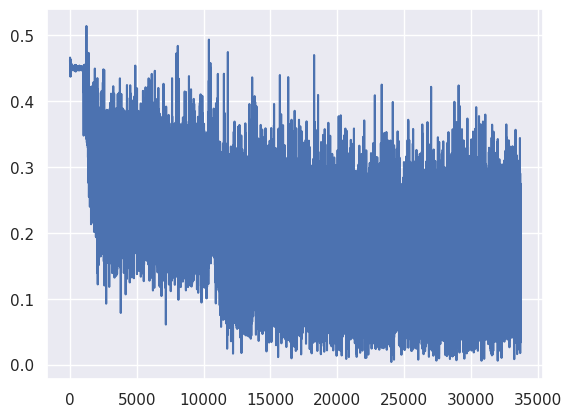

wandb: Agent Starting Run: httj0miv with config:
wandb: 	activation_fn: sigmoid
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	size_hidden_layer: 32
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [00:25<00:00,  5.09s/it]

Test set accuracy : 0.1 | Test set loss : 0.44983597292111244


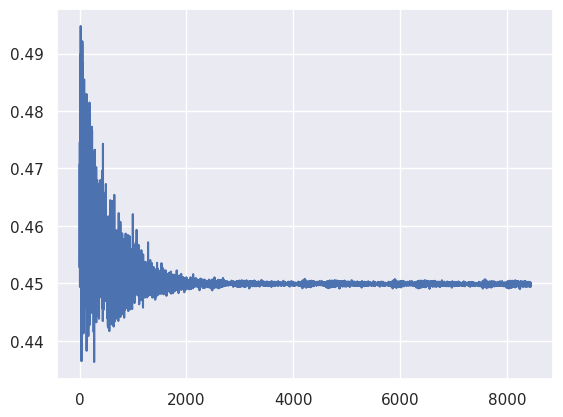

wandb: Agent Starting Run: 34q2m13v with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	size_hidden_layer: 32
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random


100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

Test set accuracy : 0.8495 | Test set loss : 0.1101430196149884


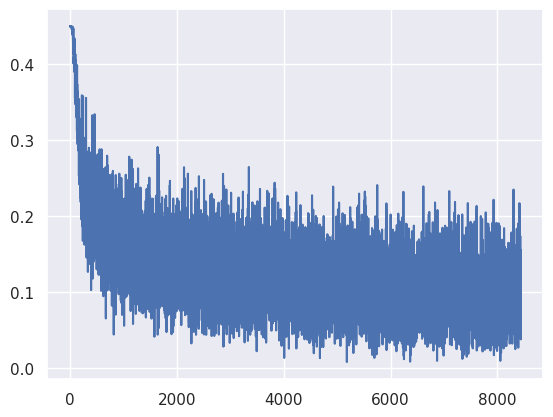

wandb: Agent Starting Run: isvff2g4 with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	size_hidden_layer: 32
wandb: 	weight_decay: 0.005
wandb: 	weight_initialisation: random


100%|██████████| 5/5 [00:26<00:00,  5.25s/it]

Test set accuracy : 0.1 | Test set loss : 0.4994445910530774


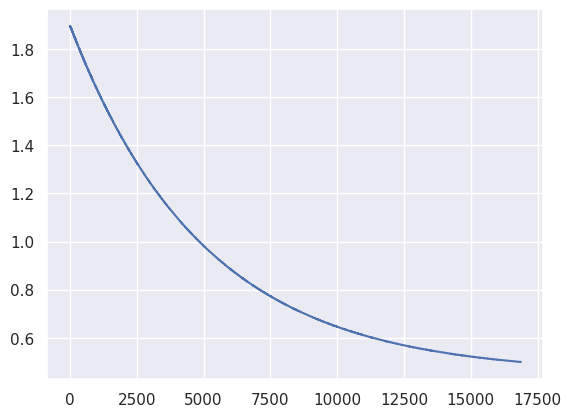

wandb: Agent Starting Run: 5gg98tzk with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	size_hidden_layer: 32
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [00:13<00:00,  2.70s/it]

Test set accuracy : 0.8532 | Test set loss : 0.16105236486279426


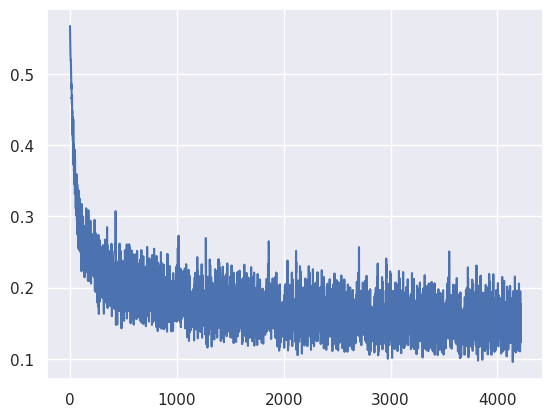

wandb: Agent Starting Run: im6d4z89 with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.01
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	size_hidden_layer: 32
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:25<00:00,  2.51s/it]


Test set accuracy : 0.8336 | Test set loss : 0.11946367205024055


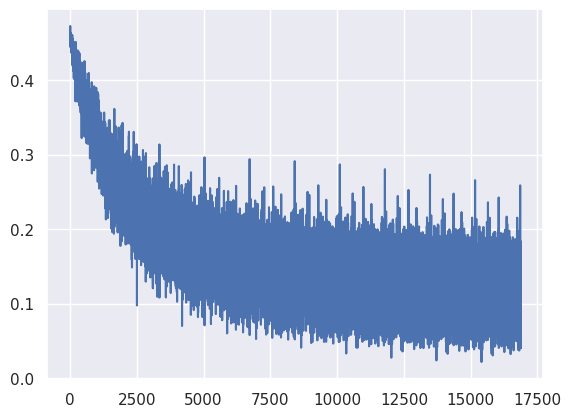

wandb: Agent Starting Run: 4ck64sal with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.1
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0.005
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [00:28<00:00,  5.74s/it]


Test set accuracy : 0.7255 | Test set loss : 0.3339390236982049


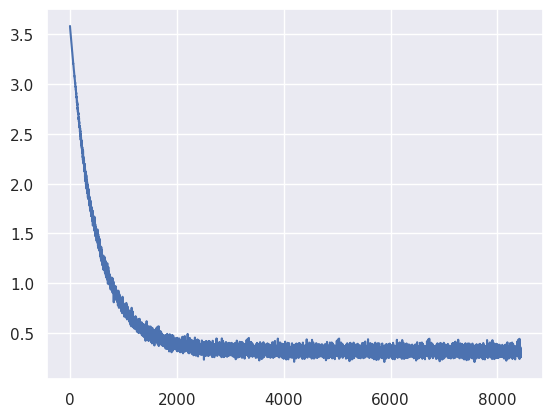

wandb: Agent Starting Run: old3s69c with config:
wandb: 	activation_fn: sigmoid
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.1
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [02:15<00:00, 13.58s/it]


Test set accuracy : 0.1 | Test set loss : 0.4500009186278591


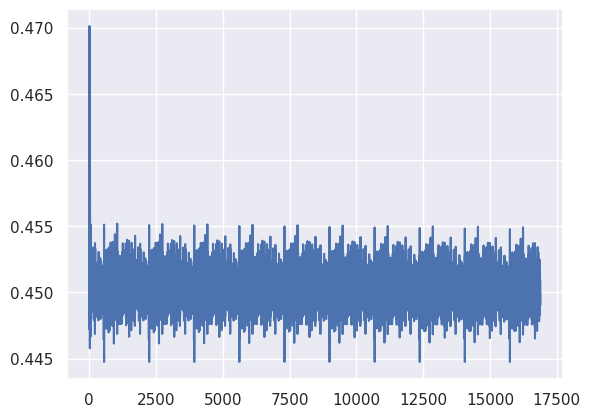

wandb: Agent Starting Run: sftysxwc with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.1
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	size_hidden_layer: 64
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random


100%|██████████| 10/10 [00:58<00:00,  5.83s/it]


Test set accuracy : 0.816 | Test set loss : 0.13641578854401804


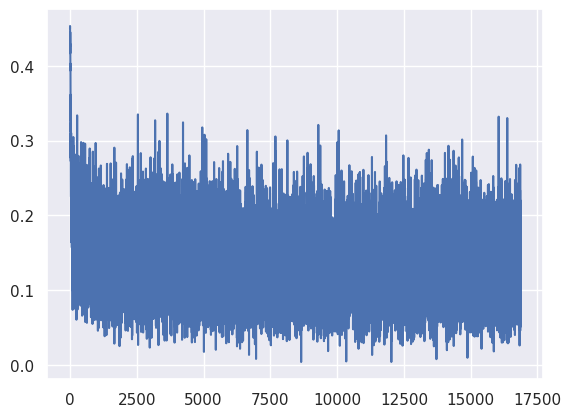

wandb: Agent Starting Run: ouu9bc7w with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.01
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	size_hidden_layer: 64
wandb: 	weight_decay: 0.005
wandb: 	weight_initialisation: random


100%|██████████| 5/5 [00:23<00:00,  4.76s/it]

Test set accuracy : 0.1 | Test set loss : 0.45007113166166635


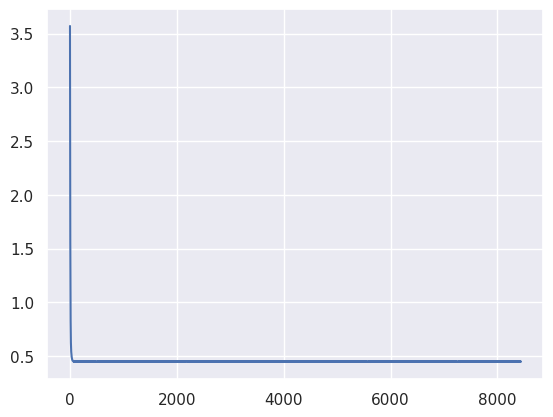

wandb: Agent Starting Run: 42lli8ki with config:
wandb: 	activation_fn: sigmoid
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.1
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0.005
wandb: 	weight_initialisation: random


100%|██████████| 5/5 [00:58<00:00, 11.70s/it]


Test set accuracy : 0.1 | Test set loss : 0.4515393141298924


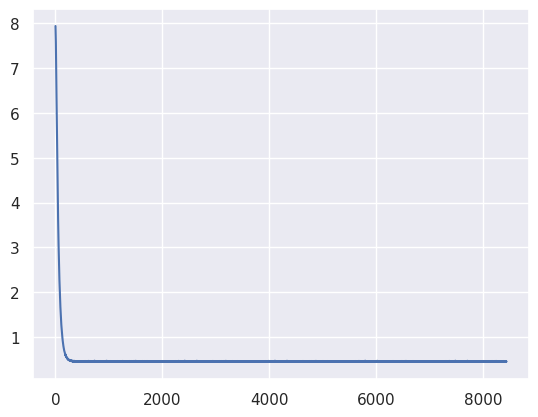

wandb: Agent Starting Run: eda8ngt3 with config:
wandb: 	activation_fn: sigmoid
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.01
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	size_hidden_layer: 32
wandb: 	weight_decay: 0.005
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:32<00:00,  3.30s/it]

Test set accuracy : 0.1 | Test set loss : 0.45016312452224505


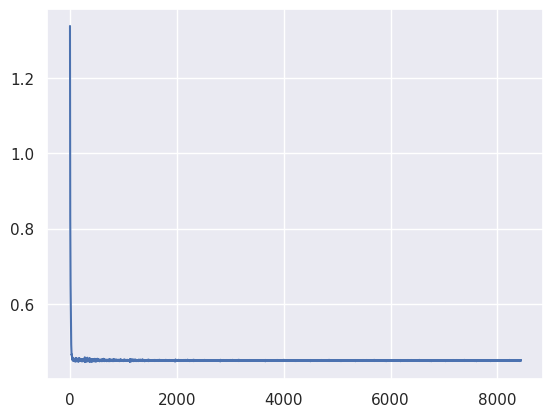

wandb: Agent Starting Run: ox6r2ark with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.01
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:50<00:00,  5.06s/it]


Test set accuracy : 0.8356 | Test set loss : 0.3152476610823318


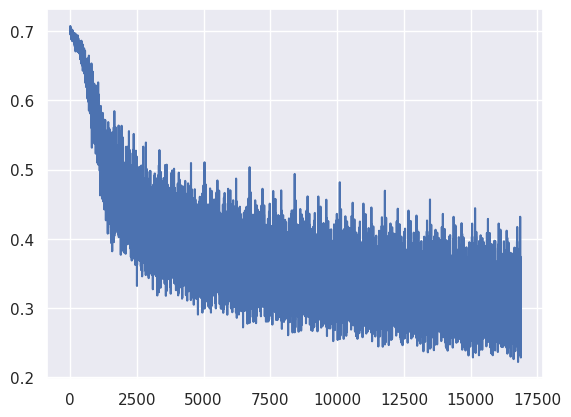

wandb: Agent Starting Run: 6r1r51u3 with config:
wandb: 	activation_fn: sigmoid
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 32
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:53<00:00,  5.33s/it]


Test set accuracy : 0.822 | Test set loss : 0.13453482296253494


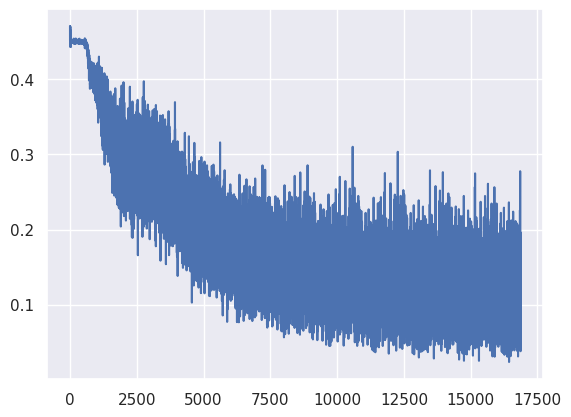

wandb: Agent Starting Run: lv1fp5aq with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.01
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [01:19<00:00,  7.92s/it]


Test set accuracy : 0.8505 | Test set loss : 0.15483324676140398


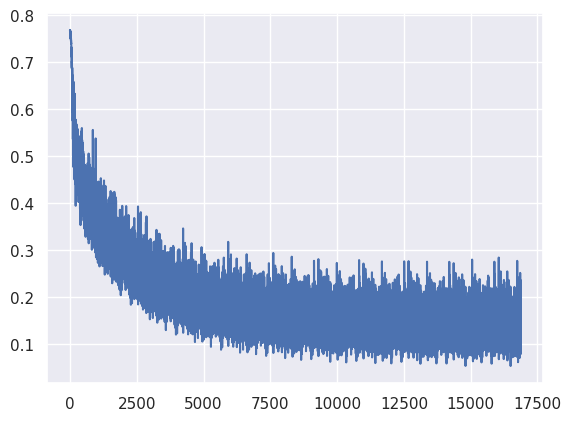

wandb: Agent Starting Run: qpt0c1nu with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [01:23<00:00,  8.30s/it]


Test set accuracy : 0.8413 | Test set loss : 0.3550993369106602


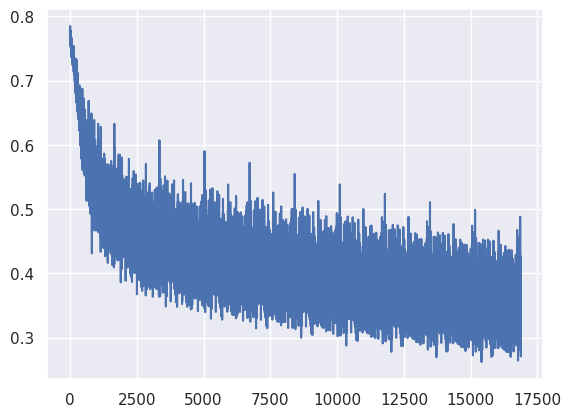

wandb: Agent Starting Run: w8himpff with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	size_hidden_layer: 64
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:45<00:00,  4.51s/it]


Test set accuracy : 0.86 | Test set loss : 0.10232151433596406


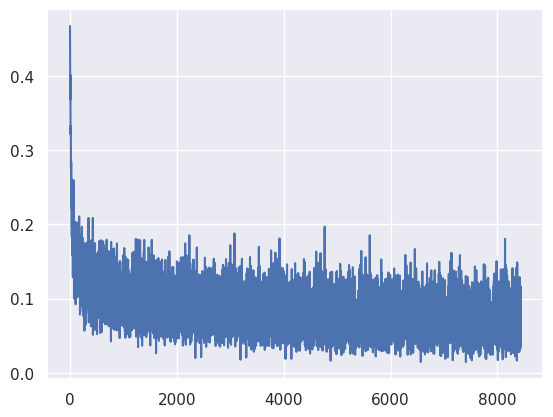

wandb: Agent Starting Run: u41xb36a with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.01
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [01:02<00:00,  6.27s/it]


Test set accuracy : 0.8495 | Test set loss : 0.20364868503229006


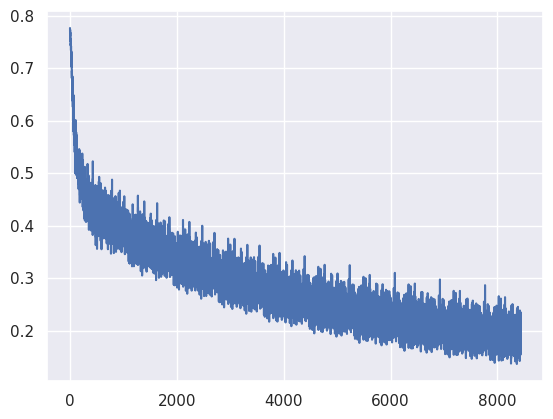

wandb: Agent Starting Run: 83bjyw1f with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:54<00:00,  5.46s/it]


Test set accuracy : 0.8765 | Test set loss : 0.0907710996081072


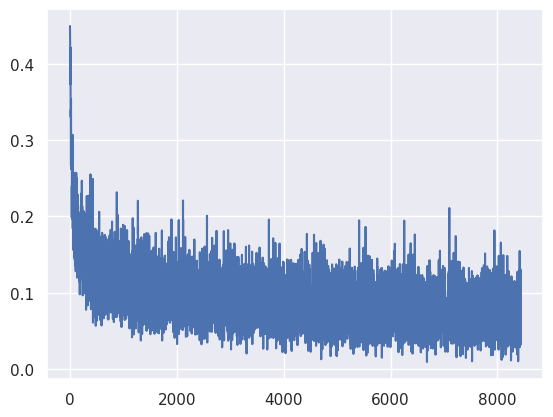

wandb: Agent Starting Run: xu6bqnn5 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 64
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:54<00:00,  5.45s/it]


Test set accuracy : 0.8692 | Test set loss : 0.09828940420709449


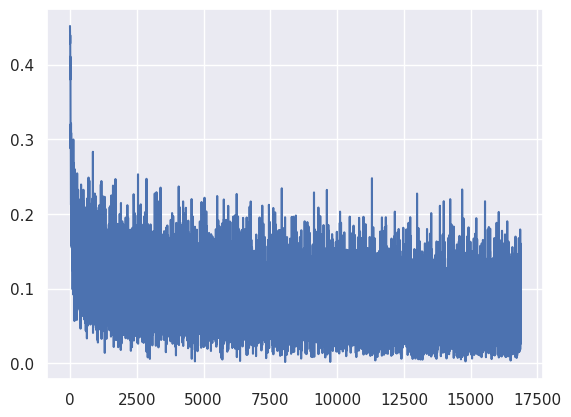

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jk200cel with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	size_hidden_layer: 64
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:45<00:00,  4.53s/it]


Test set accuracy : 0.86 | Test set loss : 0.10232151433596406


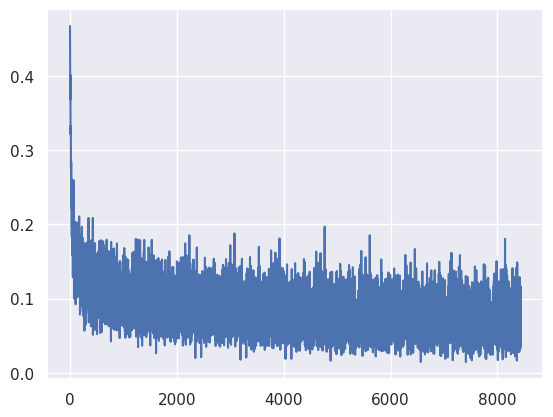

wandb: Agent Starting Run: kpcplcfz with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	size_hidden_layer: 64
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:45<00:00,  4.57s/it]


Test set accuracy : 0.86 | Test set loss : 0.10232151433596406


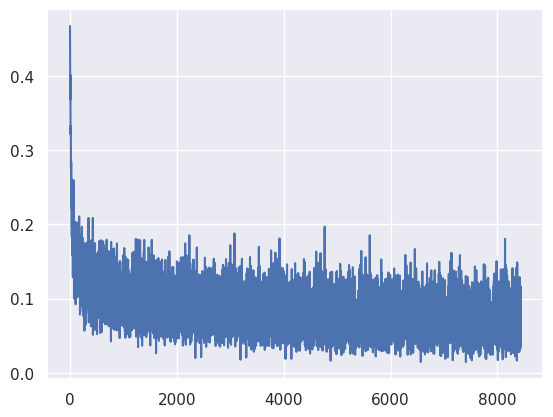

wandb: Agent Starting Run: qoja6xq3 with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [01:09<00:00,  6.94s/it]


Test set accuracy : 0.8213 | Test set loss : 0.1688608136734955


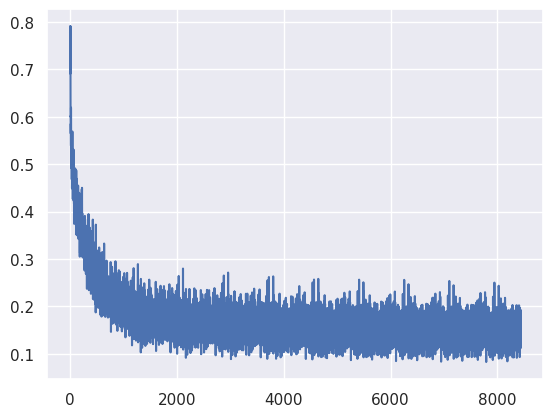

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4s0vvcfq with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.01
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	size_hidden_layer: 64
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:51<00:00,  5.16s/it]


Test set accuracy : 0.7811 | Test set loss : 0.17829975912821078


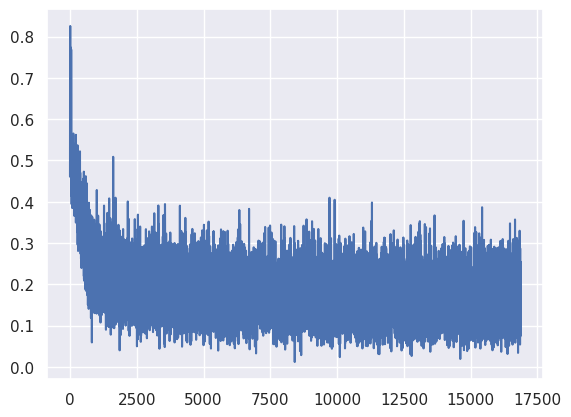

wandb: Agent Starting Run: jgtesgqh with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 32
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:21<00:00,  2.17s/it]


Test set accuracy : 0.8564 | Test set loss : 0.1043437116849452


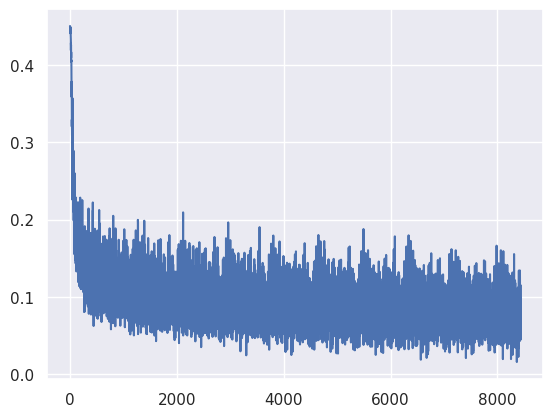

wandb: Agent Starting Run: chyq9zut with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	size_hidden_layer: 64
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:26<00:00,  2.63s/it]

Test set accuracy : 0.87 | Test set loss : 0.09616075050571729


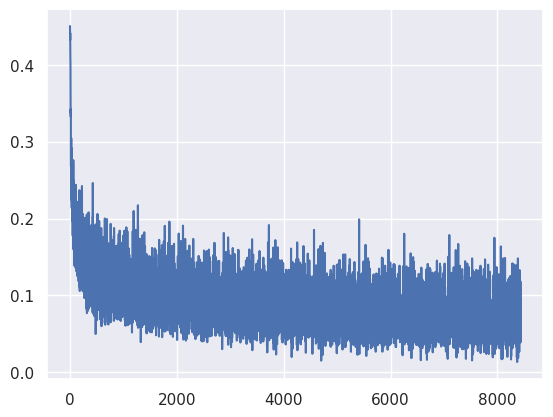

wandb: Agent Starting Run: mpvfa70i with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.01
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	size_hidden_layer: 64
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random


100%|██████████| 10/10 [01:05<00:00,  6.57s/it]


Test set accuracy : 0.1 | Test set loss : 0.4638304756677707


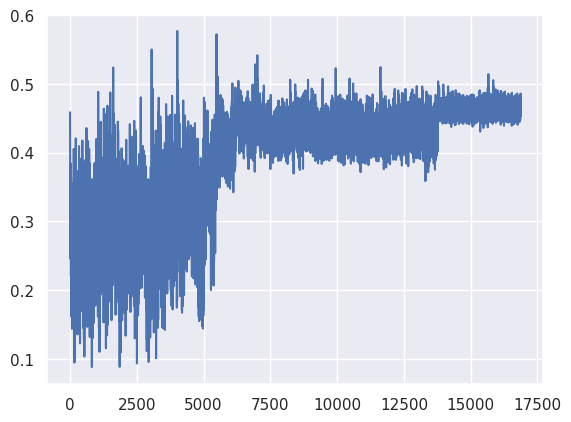

wandb: Agent Starting Run: 4hq1018o with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.1
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	size_hidden_layer: 64
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:27<00:00,  2.76s/it]

Test set accuracy : 0.8214 | Test set loss : 0.17252414231147828


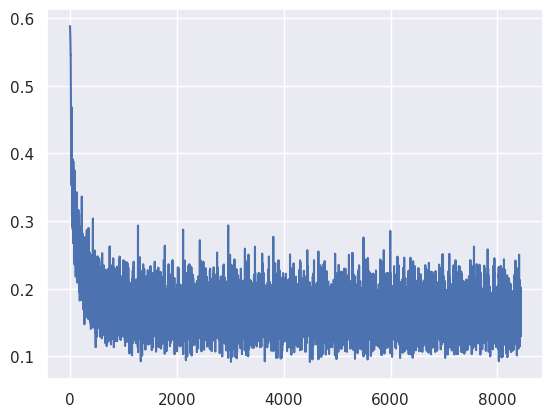

wandb: Agent Starting Run: sq4isk1p with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:43<00:00,  4.39s/it]


Test set accuracy : 0.822 | Test set loss : 0.13092781361996508


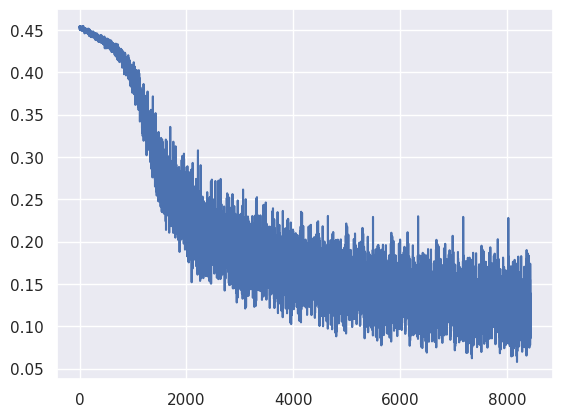

wandb: Agent Starting Run: m9738da6 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.01
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	size_hidden_layer: 64
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:24<00:00,  2.40s/it]

Test set accuracy : 0.8619 | Test set loss : 0.10212278468324644


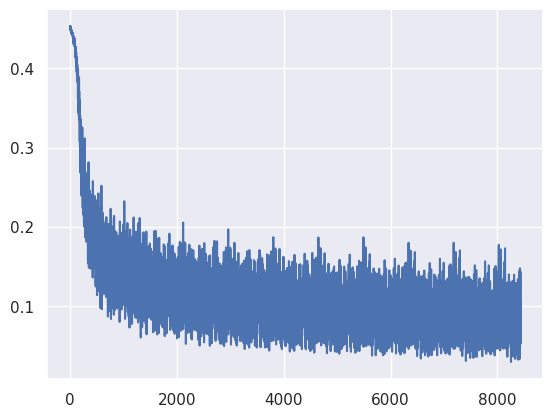

wandb: Agent Starting Run: f0ubgbw7 with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.01
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	size_hidden_layer: 64
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:31<00:00,  3.19s/it]


Test set accuracy : 0.8051 | Test set loss : 0.1413652906895113


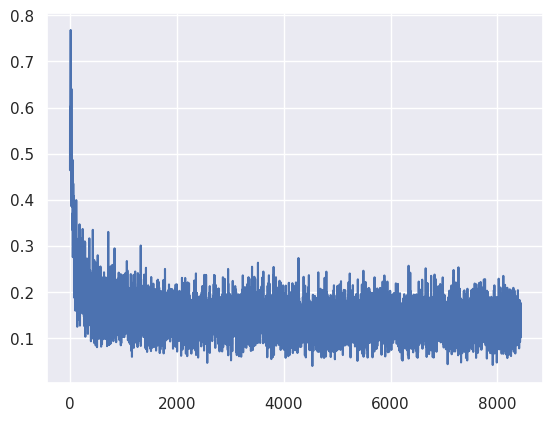

wandb: Agent Starting Run: elk74q0w with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.1
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	size_hidden_layer: 64
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random


100%|██████████| 10/10 [00:43<00:00,  4.35s/it]


Test set accuracy : 0.8441 | Test set loss : 0.11470969032142792


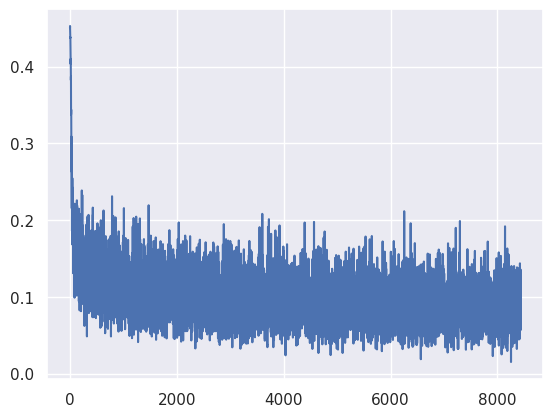

wandb: Agent Starting Run: bij7thm1 with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.1
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	size_hidden_layer: 64
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random


100%|██████████| 10/10 [00:51<00:00,  5.15s/it]


Test set accuracy : 0.8254 | Test set loss : 0.1339133886520052


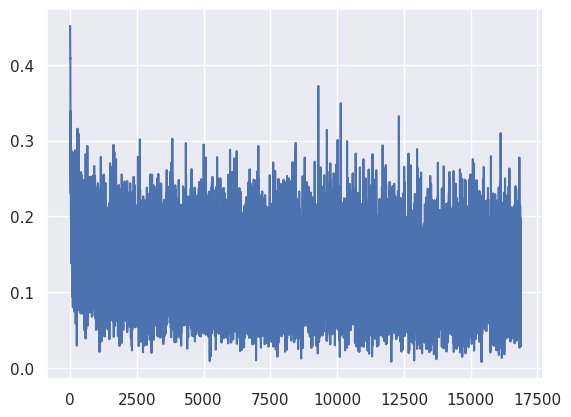

wandb: Agent Starting Run: z3rx4y7m with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.01
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	size_hidden_layer: 64
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:48<00:00,  4.83s/it]


Test set accuracy : 0.6467 | Test set loss : 0.3140298920447197


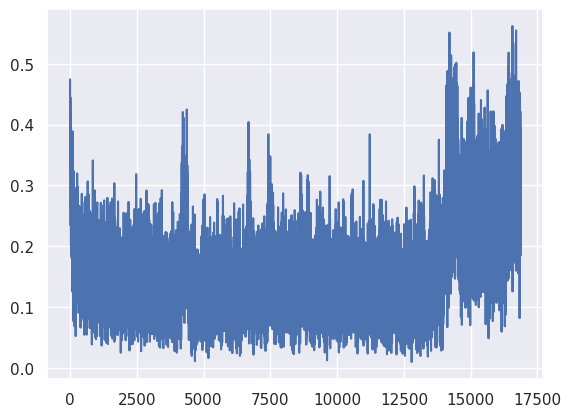

wandb: Agent Starting Run: j0iltanw with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.1
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	size_hidden_layer: 32
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:15<00:00,  1.50s/it]

Test set accuracy : 0.8666 | Test set loss : 0.09710924691253148


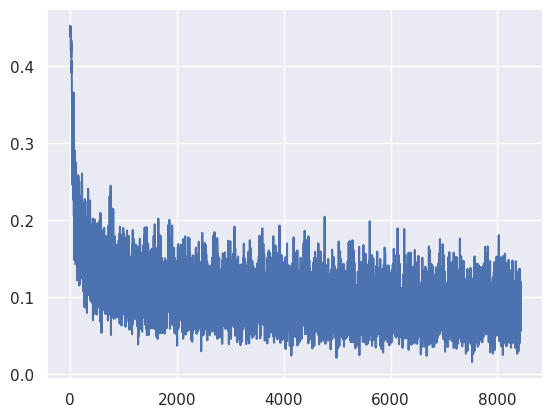

wandb: Agent Starting Run: 1yy3xcrk with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	size_hidden_layer: 64
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:20<00:00,  2.05s/it]


Test set accuracy : 0.8213 | Test set loss : 0.13140992588496414


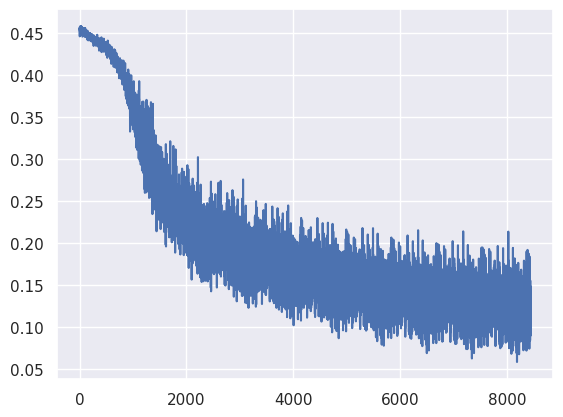

wandb: Agent Starting Run: uo82436d with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	size_hidden_layer: 32
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:21<00:00,  2.15s/it]

Test set accuracy : 0.864 | Test set loss : 0.10055976617200876


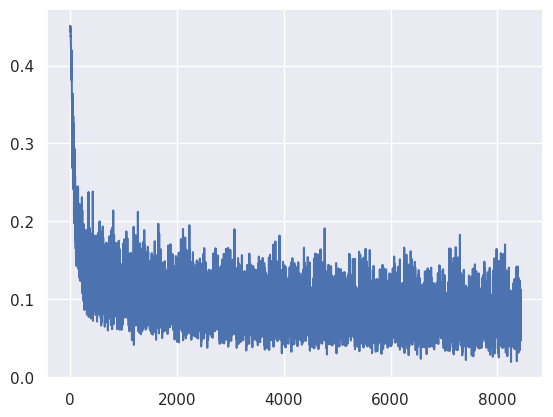

wandb: Agent Starting Run: loji2rcy with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.1
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	size_hidden_layer: 64
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:42<00:00,  4.29s/it]


Test set accuracy : 0.8624 | Test set loss : 0.10135251390576551


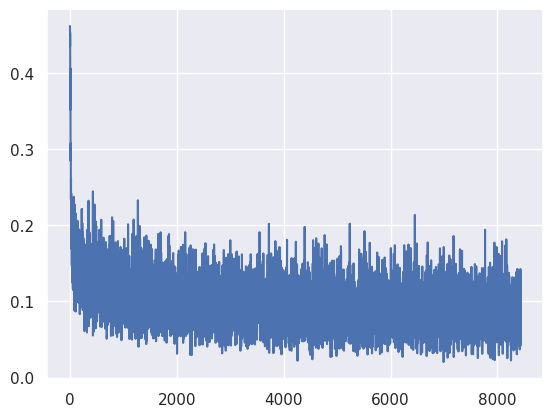

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h59j1gna with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.01
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [01:01<00:00,  6.17s/it]


Test set accuracy : 0.8318 | Test set loss : 0.12087678988465143


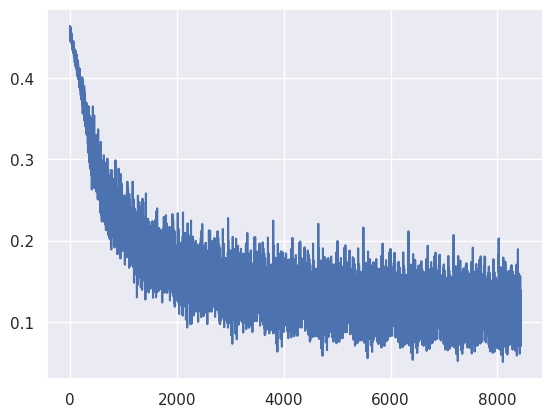

wandb: Agent Starting Run: 3cgzfiqa with config:
wandb: 	activation_fn: sigmoid
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.1
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	size_hidden_layer: 64
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [01:03<00:00,  6.35s/it]


Test set accuracy : 0.8602 | Test set loss : 0.10275107565812384


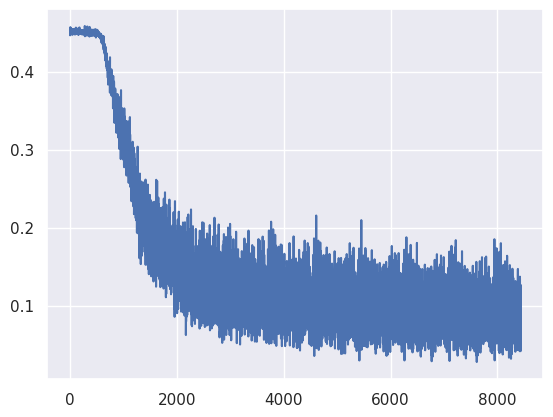

wandb: Agent Starting Run: ez1azyiq with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.1
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:38<00:00,  3.90s/it]


Test set accuracy : 0.8338 | Test set loss : 0.16519448637755718


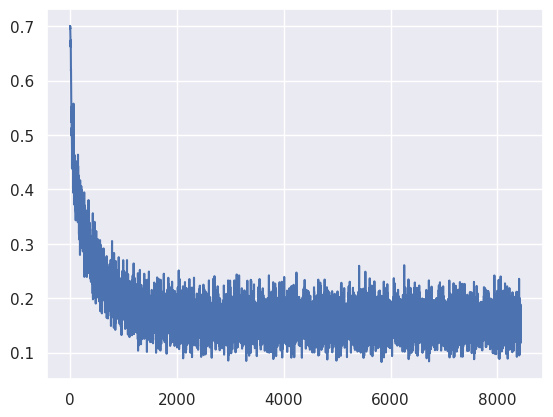

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3senn3uz with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.1
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	size_hidden_layer: 32
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:22<00:00,  2.25s/it]


Test set accuracy : 0.8628 | Test set loss : 0.09838072200038703


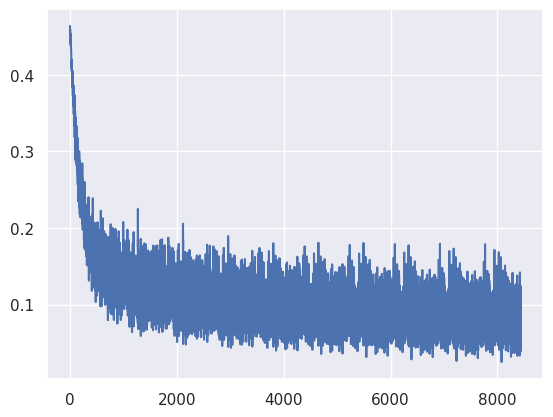

wandb: Agent Starting Run: x9jjzexu with config:
wandb: 	activation_fn: sigmoid
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.1
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	size_hidden_layer: 32
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:30<00:00,  3.09s/it]


Test set accuracy : 0.8091 | Test set loss : 0.1391549407005258


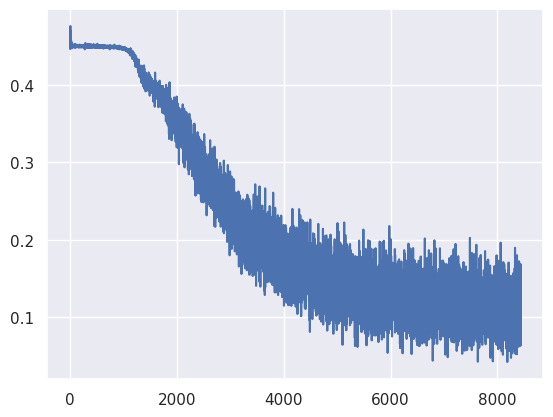

wandb: Agent Starting Run: 34c38v6q with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	size_hidden_layer: 32
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [00:09<00:00,  1.93s/it]

Test set accuracy : 0.8585 | Test set loss : 0.10173103891350102


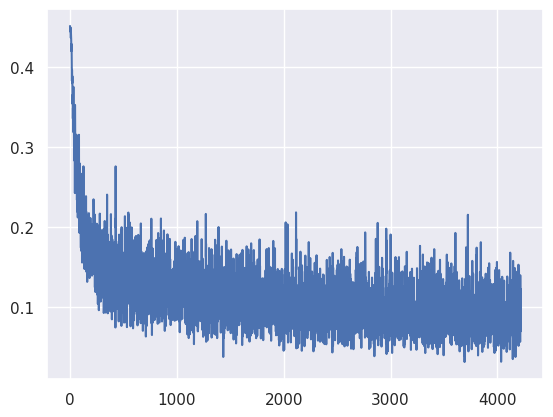

wandb: Agent Starting Run: oi2wg4sh with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.1
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	size_hidden_layer: 32
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:16<00:00,  1.63s/it]

Test set accuracy : 0.8424 | Test set loss : 0.16156051400129934


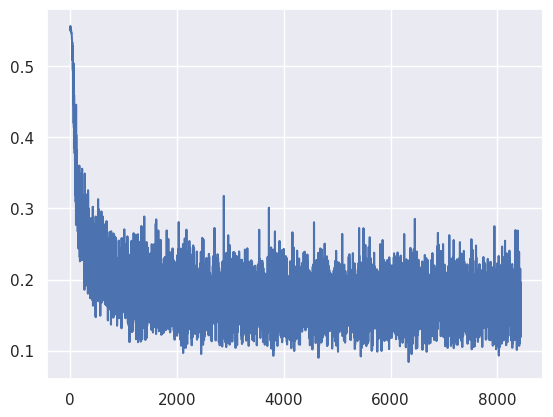

wandb: Agent Starting Run: u17fx13m with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.01
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	size_hidden_layer: 32
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:15<00:00,  1.56s/it]

Test set accuracy : 0.8563 | Test set loss : 0.10537066625703255


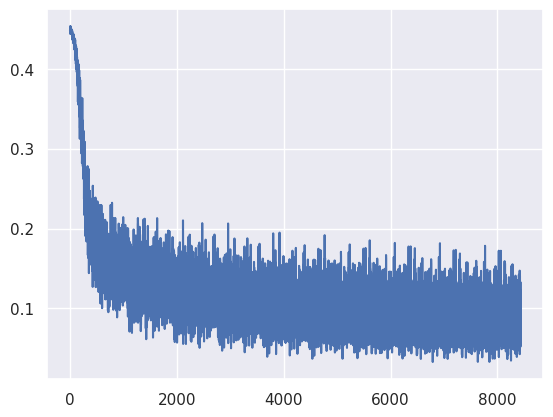

wandb: Agent Starting Run: 92nltl00 with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.1
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	size_hidden_layer: 64
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:34<00:00,  3.41s/it]


Test set accuracy : 0.8664 | Test set loss : 0.09897356852787406


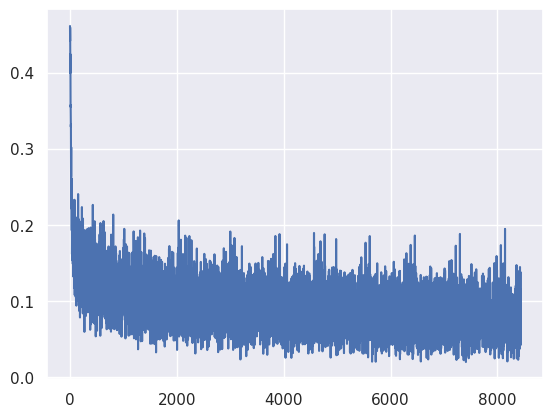

wandb: Agent Starting Run: vsswij17 with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.1
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	size_hidden_layer: 32
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:28<00:00,  2.87s/it]


Test set accuracy : 0.868 | Test set loss : 0.09625500540220695


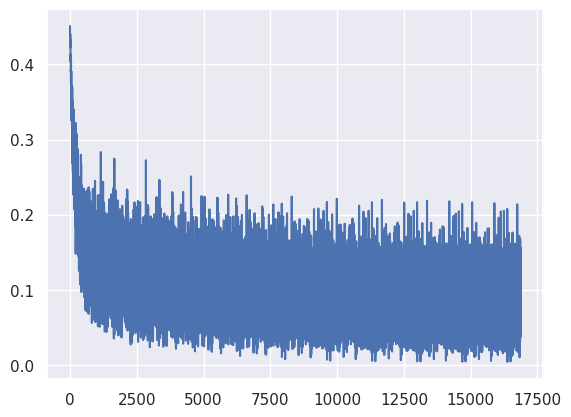

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: feiv2hlz with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.1
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	size_hidden_layer: 32
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random


100%|██████████| 10/10 [00:21<00:00,  2.13s/it]


Test set accuracy : 0.8515 | Test set loss : 0.11013498853650576


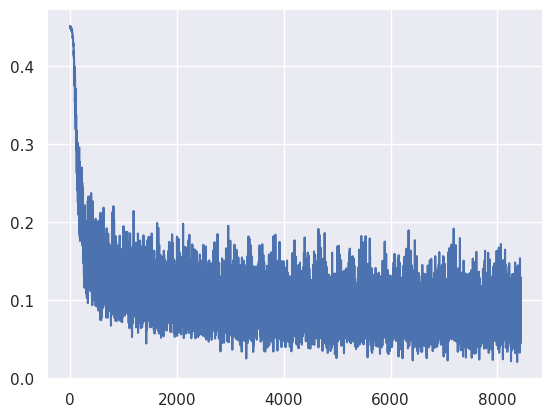

wandb: Agent Starting Run: opmi7m95 with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.1
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	size_hidden_layer: 32
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:21<00:00,  2.13s/it]

Test set accuracy : 0.8629 | Test set loss : 0.09931931714183506


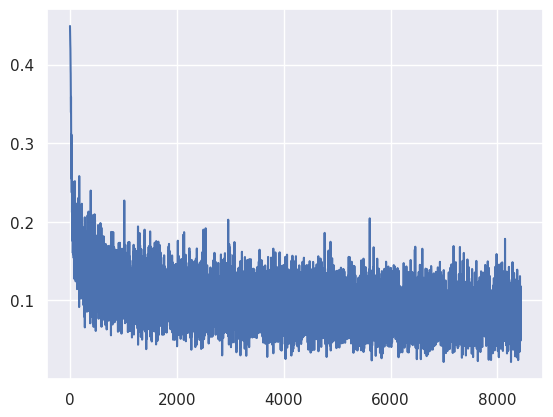

wandb: Agent Starting Run: 1dfnuy55 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	size_hidden_layer: 32
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:21<00:00,  2.18s/it]


Test set accuracy : 0.8327 | Test set loss : 0.12191899339842611


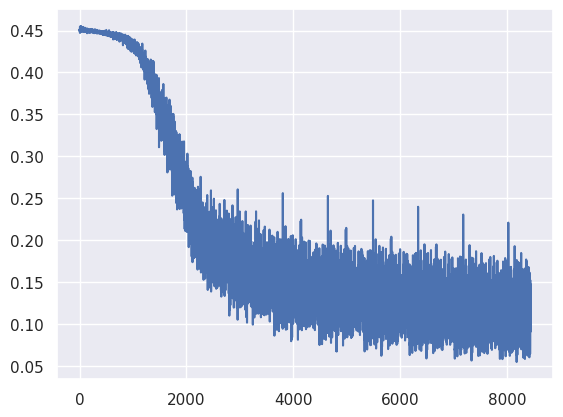

wandb: Agent Starting Run: kei43izt with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.1
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:41<00:00,  4.17s/it]


Test set accuracy : 0.8577 | Test set loss : 0.10159904806917013


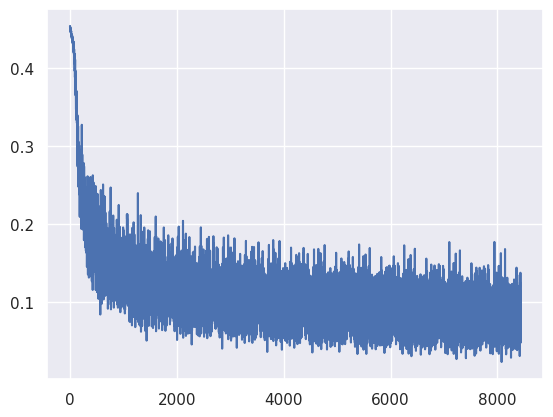

wandb: Agent Starting Run: hwjes7ip with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.1
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	size_hidden_layer: 32
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random


100%|██████████| 10/10 [00:25<00:00,  2.59s/it]


Test set accuracy : 0.8442 | Test set loss : 0.11379936499517614


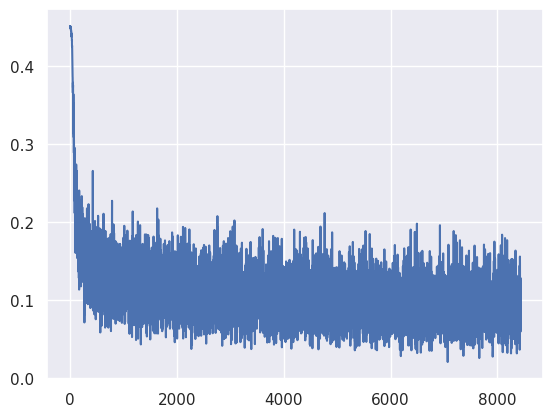

wandb: Agent Starting Run: 2pjmxj1t with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.01
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	size_hidden_layer: 64
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:25<00:00,  2.59s/it]


Test set accuracy : 0.8604 | Test set loss : 0.1016450547766372


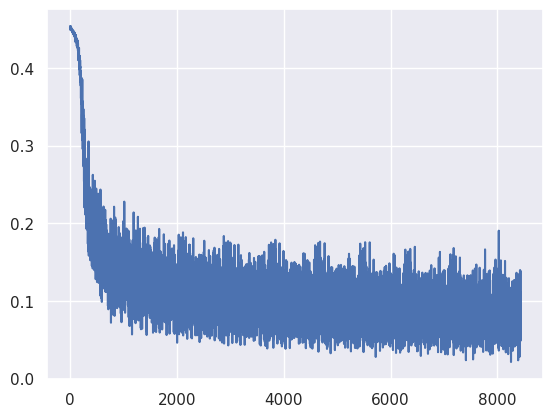

wandb: Agent Starting Run: v76cvks9 with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.1
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	size_hidden_layer: 32
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random


100%|██████████| 10/10 [00:32<00:00,  3.20s/it]


Test set accuracy : 0.8234 | Test set loss : 0.13089628453655167


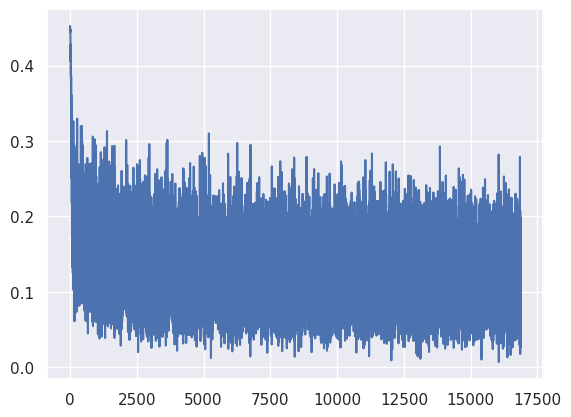

wandb: Agent Starting Run: 8aqva712 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.01
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	size_hidden_layer: 64
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:22<00:00,  2.29s/it]


Test set accuracy : 0.8161 | Test set loss : 0.13459330781350573


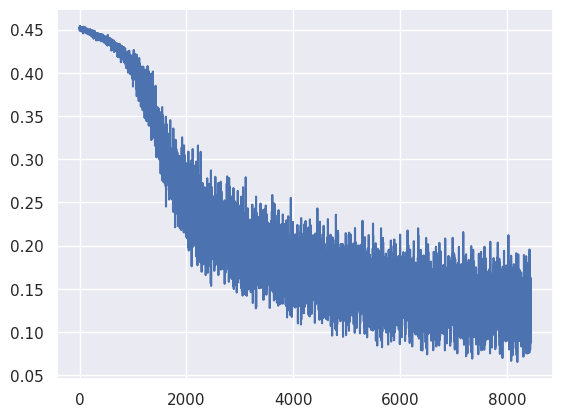

wandb: Agent Starting Run: tbtviw6o with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.1
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	size_hidden_layer: 32
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random


100%|██████████| 10/10 [00:16<00:00,  1.65s/it]

Test set accuracy : 0.8468 | Test set loss : 0.11021653649176635


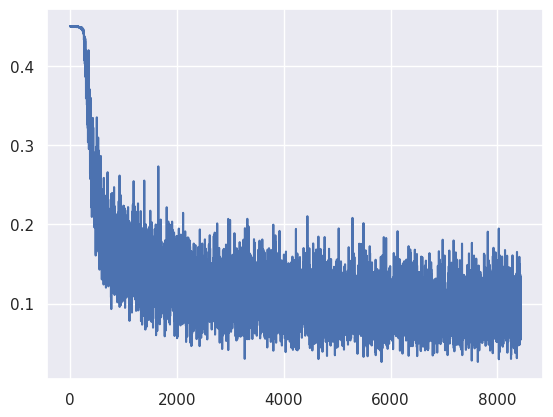

wandb: Agent Starting Run: 2r7jeoi2 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.1
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	size_hidden_layer: 32
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:20<00:00,  2.02s/it]


Test set accuracy : 0.8502 | Test set loss : 0.11299672347502476


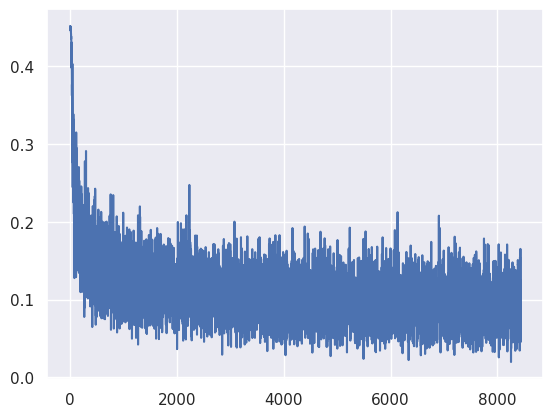

wandb: Agent Starting Run: 2ws5vsip with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.1
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random


100%|██████████| 10/10 [00:52<00:00,  5.24s/it]


Test set accuracy : 0.8599 | Test set loss : 0.10266655162228176


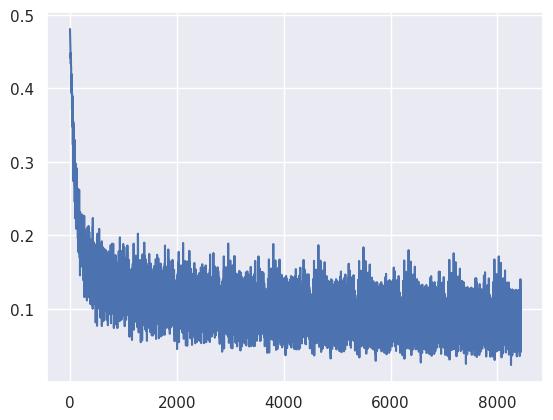

wandb: Agent Starting Run: sdl4xi50 with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.1
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random


100%|██████████| 10/10 [01:08<00:00,  6.85s/it]


Test set accuracy : 0.8608 | Test set loss : 0.10729057449994521


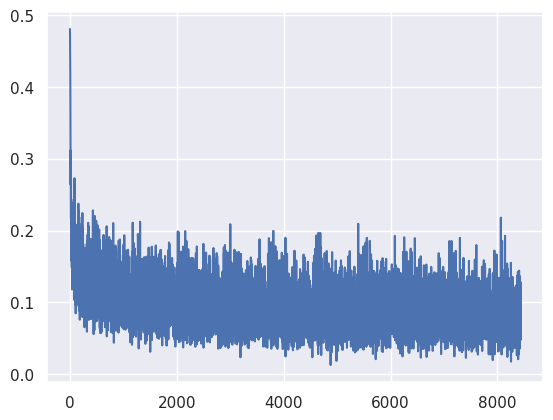

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cb2b32ih with config:
wandb: 	activation_fn: sigmoid
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.1
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	size_hidden_layer: 32
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:37<00:00,  3.78s/it]


Test set accuracy : 0.846 | Test set loss : 0.1139124329928303


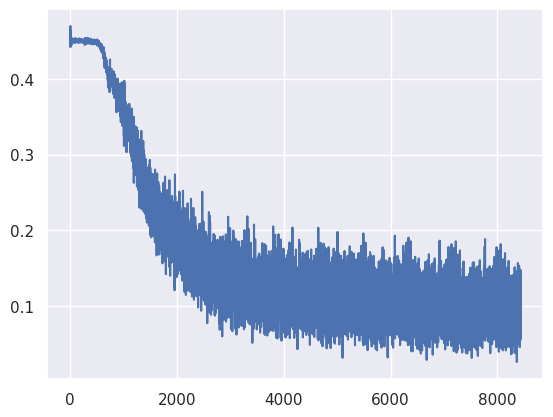

wandb: Agent Starting Run: lait2rnf with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.1
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	size_hidden_layer: 32
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]

Test set accuracy : 0.851 | Test set loss : 0.10963113656812645


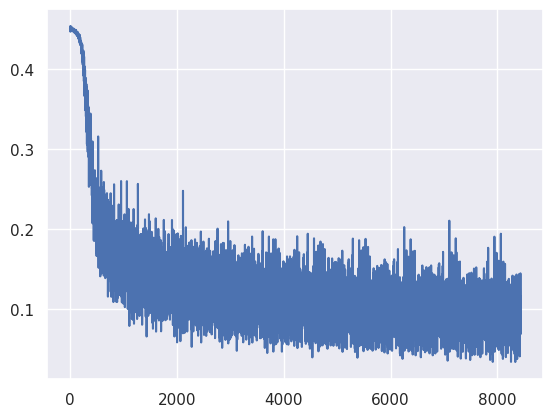

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l357jsec with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.1
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	size_hidden_layer: 64
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:22<00:00,  2.21s/it]


Test set accuracy : 0.8484 | Test set loss : 0.15137691465407854


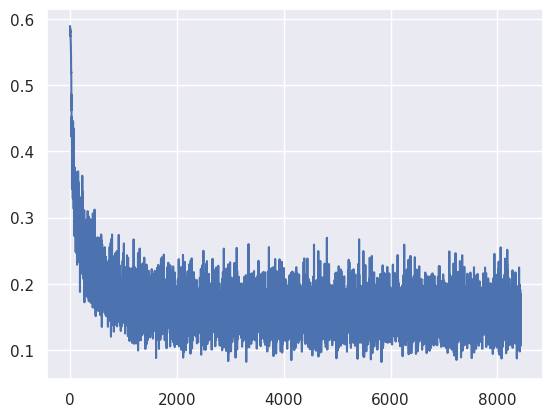

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ch0glzt0 with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.1
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	size_hidden_layer: 32
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:24<00:00,  2.41s/it]


Test set accuracy : 0.8607 | Test set loss : 0.09938600686604095


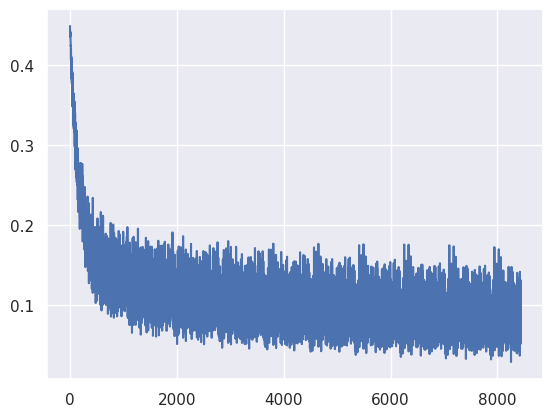

wandb: Agent Starting Run: yqhula8y with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	no_epochs: 5
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	size_hidden_layer: 32
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 5/5 [00:11<00:00,  2.26s/it]

Test set accuracy : 0.8498 | Test set loss : 0.10857638979763366


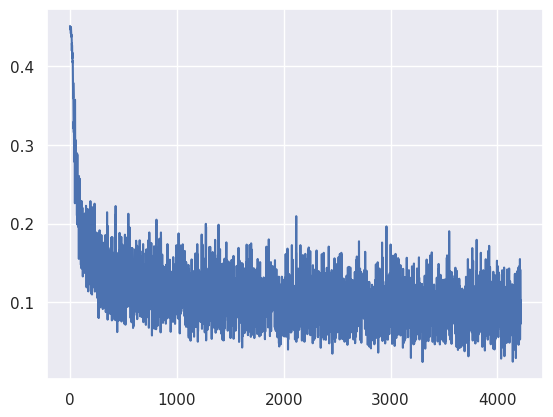

wandb: Agent Starting Run: un9sx5g9 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.1
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random


100%|██████████| 10/10 [01:11<00:00,  7.13s/it]


Test set accuracy : 0.8491 | Test set loss : 0.11192758653920243


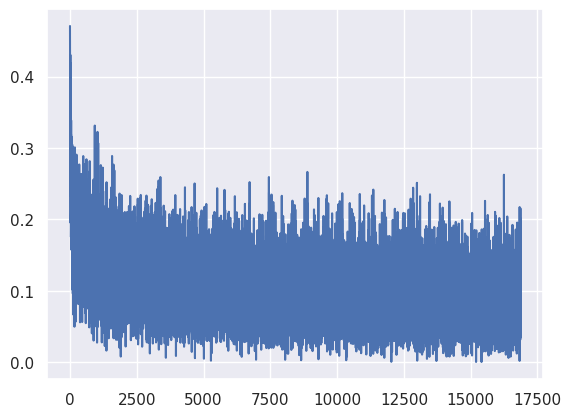

wandb: Agent Starting Run: gujtdmd2 with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.1
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	size_hidden_layer: 64
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random


100%|██████████| 10/10 [00:39<00:00,  3.92s/it]


Test set accuracy : 0.8535 | Test set loss : 0.10669562745712531


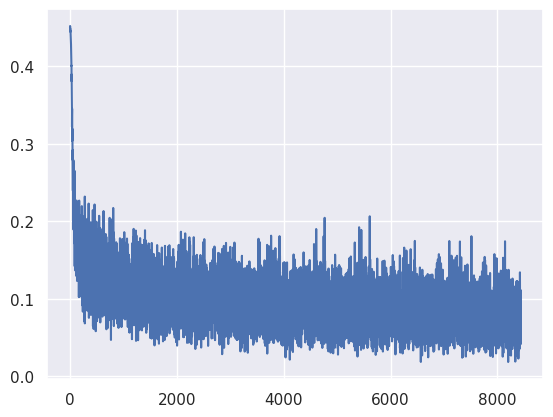

wandb: Agent Starting Run: e5tqdl5z with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.1
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	size_hidden_layer: 64
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:23<00:00,  2.38s/it]


Test set accuracy : 0.8671 | Test set loss : 0.0976655317965847


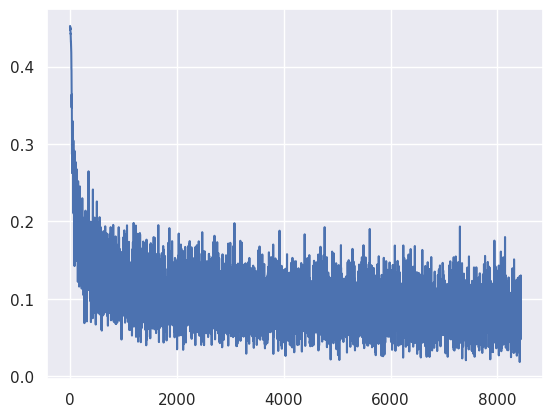

wandb: Agent Starting Run: 4f8es9gc with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.1
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:56<00:00,  5.67s/it]


Test set accuracy : 0.8488 | Test set loss : 0.10821179354092364


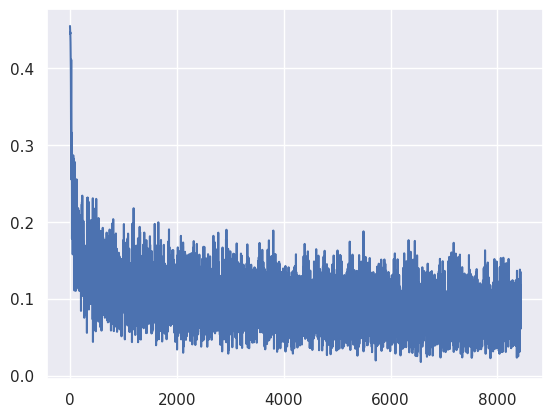

wandb: Agent Starting Run: bra5ginq with config:
wandb: 	activation_fn: sigmoid
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.1
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	size_hidden_layer: 64
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:50<00:00,  5.05s/it]


Test set accuracy : 0.1 | Test set loss : 0.4506072751397002


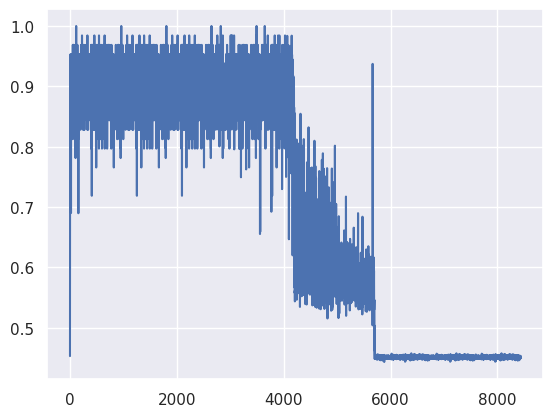

wandb: Agent Starting Run: b1g29e79 with config:
wandb: 	activation_fn: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.01
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	size_hidden_layer: 64
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:29<00:00,  2.92s/it]


Test set accuracy : 0.8615 | Test set loss : 0.10268275765380055


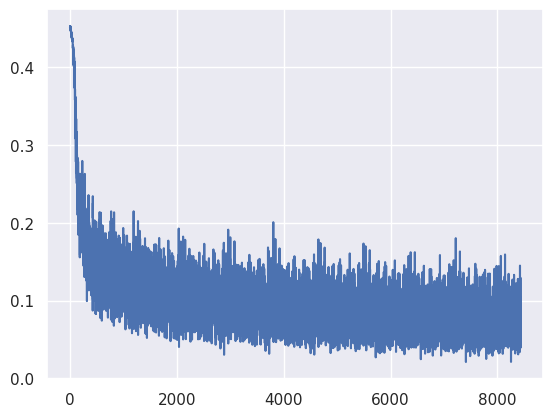

wandb: Agent Starting Run: ssi8e1wp with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.01
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	size_hidden_layer: 64
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:34<00:00,  3.42s/it]


Test set accuracy : 0.8639 | Test set loss : 0.10036872126992227


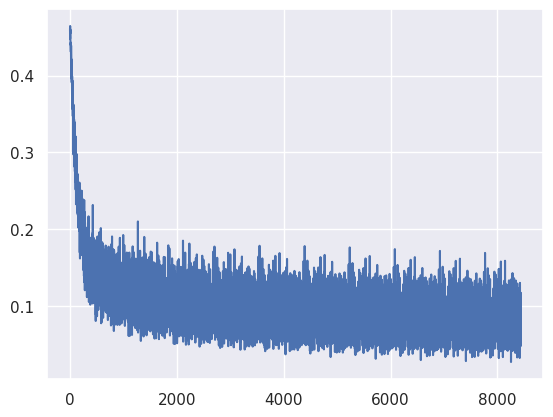

wandb: Agent Starting Run: gv83jikc with config:
wandb: 	activation_fn: sigmoid
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.01
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [01:38<00:00,  9.81s/it]


Test set accuracy : 0.1542 | Test set loss : 0.4475446290986391


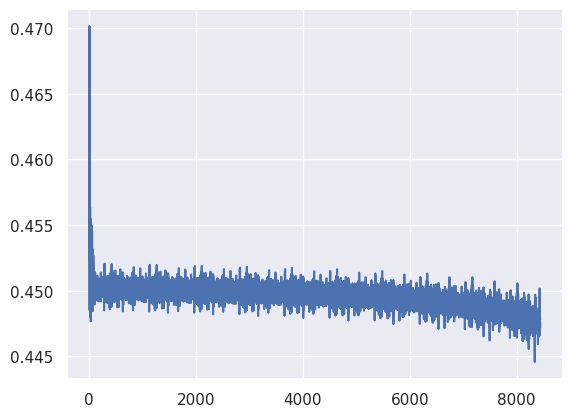

wandb: Agent Starting Run: ilvdik6s with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.1
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [01:07<00:00,  6.73s/it]


Test set accuracy : 0.868 | Test set loss : 0.09454367571011393


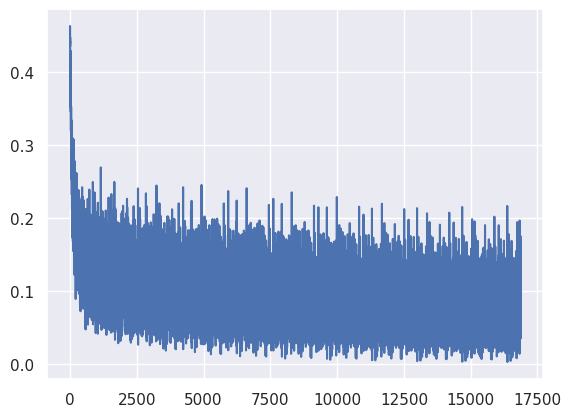

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y4wke63f with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.01
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:53<00:00,  5.40s/it]


Test set accuracy : 0.8596 | Test set loss : 0.10221556898033086


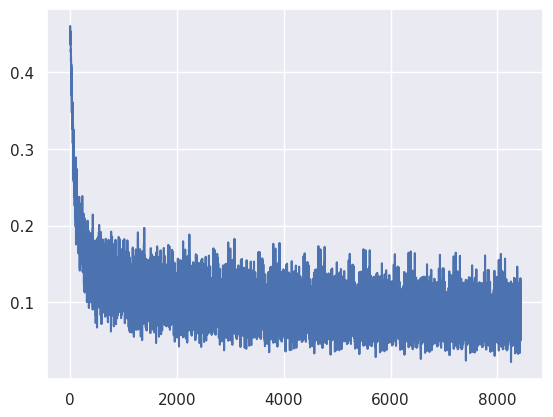

wandb: Agent Starting Run: jluen15v with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.1
wandb: 	no_epochs: 10
wandb: 	no_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	size_hidden_layer: 128
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: xavier


100%|██████████| 10/10 [00:55<00:00,  5.50s/it]


Test set accuracy : 0.8622 | Test set loss : 0.10316442479307743


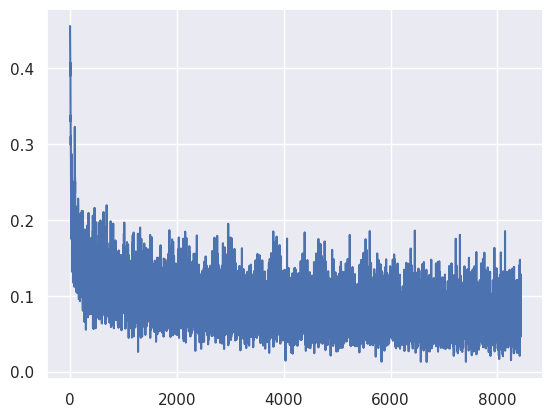

wandb: Ctrl + C detected. Stopping sweep.


In [ ]:
# Questions 8 -- Running a sweep across different hyperparameter configurations with squared error as the loss function
# ---------------- Uncomment the below code to run -----------------

sweep_id = wandb.sweep(sweep_config,project="assignment_1", entity="duenchombo1-indian-institute-of-technology-madras")
wandb.agent(sweep_id, lambda : sweep_wrapper(trainX_tr, trainY_tr, validX_tr, validY_tr, testX_tr, testY_tr, 'squared-error'))

In [ ]:
# Loading the MNIST dataset
from keras.datasets import mnist

# Load dataset (train data and test data)
(trainX_2, trainy_2), (testX_2, testy_2) = mnist.load_data()

# Summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

# Number of classes in the MNIST (Digit) dataset
N_CLASSES_2 = np.unique(trainy_2).shape[0]    # 10 as known from the keras documentation

# Transforming dataset to a form that can be used in the neural network functions
trainX_split_2, trainY_split_2, validX_split_2, validY_split_2 = train_validation_split(trainX_2, trainy_2, 0.9)
trainX_tr_2, trainY_tr_2 = transform_NN_IO(trainX_split_2, trainY_split_2, N_CLASSES_2)
validX_tr_2, validY_tr_2 = transform_NN_IO(validX_split_2, validY_split_2, N_CLASSES_2)
testX_tr_2, testY_tr_2 = transform_NN_IO(testX_2, testy_2, N_CLASSES_2)

In [ ]:
# Training neural networks for the MNIST dataset

def do_mnist_cross_entropy(trainX, trainY, validX = None, validY = None, testX = None, testY = None):
  # Function to train neural network (with cross entropy loss function) for MNIST dataset with three best configuration of hyperparameters,
  # predicted from experiments on fashion-MNIST
  run = wandb.init(project="assignment_1", entity="duenchombo1-indian-institute-of-technology-madras", reinit=True)
  network, *_ = train_wrapper(trainX, trainY, 'momentum', 64, 1e-2, 10, 4, 128, 'xavier', 'relu', 'cross-entropy',
                              0.0005, validX, validY, testX, testY, 'L2')
  run.finish()

  run = wandb.init(project="assignment_1", entity="duenchombo1-indian-institute-of-technology-madras", reinit=True)
  network, *_ = train_wrapper(trainX, trainY, 'momentum', 64, 1e-2, 10, 4, 64, 'xavier', 'relu', 'cross-entropy',
                              0.0005, validX, validY, testX, testY, 'L2')
  run.finish()

  run = wandb.init(project="assignment_1", entity="duenchombo1-indian-institute-of-technology-madras", reinit=True)
  network, *_ = train_wrapper(trainX, trainY, 'nadam', 64, 1e-3, 10, 4, 64, 'xavier', 'relu', 'cross-entropy',
                              0.0005, validX, validY, testX, testY, 'L2')
  run.finish()


def do_mnist_squared_error(trainX, trainY, validX = None, validY = None, testX = None, testY = None):
  # Function to train neural network (with cross entropy loss function) for MNIST dataset with three best configuration of hyperparameters,
  # predicted from experiments on fashion-MNIST
  run = wandb.init(project="assignment_1", entity="duenchombo1-indian-institute-of-technology-madras", reinit=True)
  network, *_ = train_wrapper(trainX, trainY, 'adam', 64, 1e-3, 10, 4, 128, 'random', 'relu', 'squared-error',
                              0, validX, validY, testX, testY, 'L2')
  run.finish()

  run = wandb.init(project="assignment_1", entity="duenchombo1-indian-institute-of-technology-madras", reinit=True)
  network, *_ = train_wrapper(trainX, trainY, 'nadam', 64, 1e-3, 10, 4, 128, 'random', 'relu', 'squared-error',
                              0, validX, validY, testX, testY, 'L2')
  run.finish()

  run = wandb.init(project="assignment_1", entity="duenchombo1-indian-institute-of-technology-madras", reinit=True)
  network, *_ = train_wrapper(trainX, trainY, 'momentum', 64, 1e-1, 10, 4, 128, 'xavier', 'relu', 'squared-error',
                              0, validX, validY, testX, testY, 'L2')
  run.finish()


# Question 10 -- Training neural networks on MNIST dataset after experimenting with fashion-MNIST dataset and figuring out 3 best hyperparameter configurations
# ---------------- Uncomment the below code to run -----------------

# For cross entropy loss
do_mnist_cross_entropy(trainX_tr_2, trainY_tr_2, validX_tr_2, validY_tr_2, testX_tr_2, testY_tr_2)
# For squared error loss
do_mnist_squared_error(trainX_tr_2, trainY_tr_2, validX_tr_2, validY_tr_2, testX_tr_2, testY_tr_2)